<h1 style='color: blue; font-size: 50px; font-weight: bold;'> Case Data Master 2024 - Leonardo Aderaldo Vargas - T789785
</h1>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
</p>  

O Case proposto apresenta o histórico de dois anos (2015-2017) de uma empresa que oferece serviço de streaming de música baseado em assinatura.

Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente. Os usuários podem cancelar ativamente sua associação a qualquer momento. 

Para este cenário, temos os seguintes desafios:

1) Problema de Classificação:

- Sabendo que existe a seguinte ação de retenção para clientes: Quando detectamos que um cliente não renova a assinatura, oferecemos 3 meses grátis. Porém, identificamos que essa ação é muito reativa e entendemos que uma abordagem proativa seria mais efetiva.
- Sendo assim, é proposto que você crie um modelo classificador para prever clientes que serão um churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no período analisado e 3 meses depois desse período ele não é mais ativo, ou porque cancelou ou não renovou a assinatura) e indique os clientes que serão direcionados para ação de forma proativa
- Assumindo que, usando a ação de forma proativa, 50% dos clientes que iriam cancelar (Verdadeiro Positivo) respondem de forma positiva e continuam ativos por mais um ano, qual sua avaliação sobre sua solução?
- Mínimo esperado: Criação de Target, Feature Engineering, Feature Selection, Predictive Modeling, Quantidade de clientes retidos e resultado financeiro da ação.


2) Problema de Clusterização

- Considerando o problema escolhido (Churn), realize uma análise não-supervisionada dos clientes com objetivo de aprofundar a compreensão sobre características deles.

- Algumas sugestões: análise de clientes com diferentes perfis de uso da plataforma, com as variadas estimações de churn, análise de perfis com diferentes volatidade/incerteza nas respostas de churn, análise de erros sistemáticos cometidos pelos modelos do case supervisionado, análise da variação temporal no comportamento dos clientes da base.

<font color='purple' style='font-size: 40px;'> Bibliotecas </font>
<hr style='border: 2px solid purple;'>

In [1]:

## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from skopt import BayesSearchCV

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score


# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

<font color='yellow' style='font-size: 40px;'> Importação de Dados </font>
<hr style='border: 2px solid yellow;'>

### 1) Base Members

> 1. msno: user id

> 2. city: cidade

> 3. bd: idade --> essa coluna tem outliers desde -7000 até 2015

> 4. registered_via: tipo de registro

> 5. registration_init_time: data do registro inicial no formato %Y%m%d

> 6. gender: gênero

> 7. is_ativo: assinatura ativa (Target Classificador Problema 1)

> 8. safra: safra

### 2) Base Transacations

> 1. msno: user id

> 2. payment_method_id: método de pagamento

> 3. payment_plan_days: quantidade de dias de afiliação

> 4. plan_list_price: preço

> 5. actual_amount_paid: montante pago

> 6. is_auto_renew: flag renovação automática

> 7. transaction_date: data da transação no formato %Y%m%d

> 8. membership_expire_date: data de expiração da afiliação

> 9. is_cancel: flag que indica se o usuário cancelou ou não a afiliação nesta transação

### 3) Base User Logs

> 1. msno: user id

> 2. safra

> 3. num_25: quantidade de músicas tocadas por menos de 25% da duração da música

> 4. num_50: quantidade de músicas tocadas entre 25% e 50% da duração da música

> 5. num_75: quantidade de músicas tocadas entre 50% e 75% da duração da música

> 6. num_985: quantidade de músicas tocadas entre 75% até 98.5% da duração da música

> 7. num_100: quantidade de músicas tocadas entre 98.5% até 100% da duração da música

> 8. num_unq: quantidade única de músicas já tocadas

> 9. total_scs: número total de segundos tocados

<font color='red' style='font-size: 40px;'> 1) Definição da Target</font>
<hr style='border: 2px solid red;'>

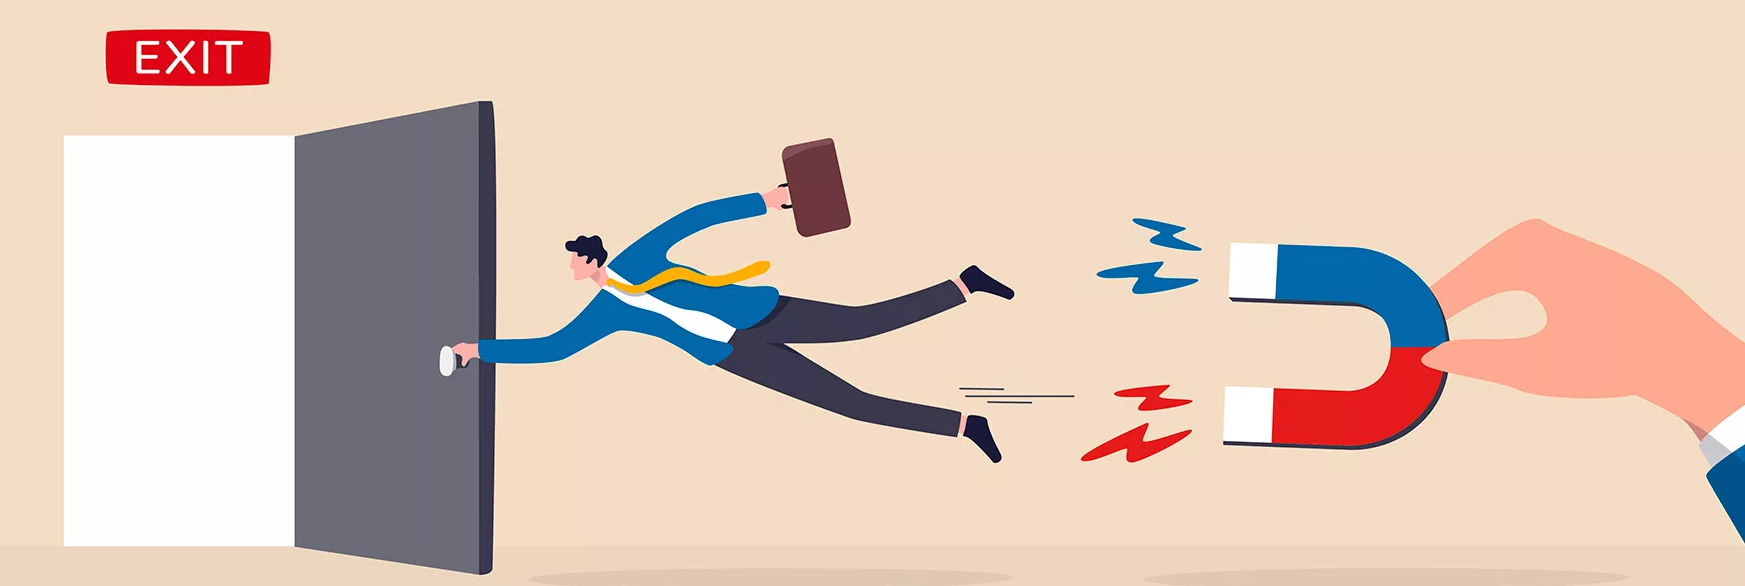

# <font color='green' style='font-size: 30px;'> 1.1) Criação da Target </font>
<hr style='border: 2px solid green;'>

> 1. Para a criação da Target, avaliou-se se o cliente era ativo em M0 e deixou de ser ou em M3

> 2. Posteriormente, excluiu-se da amostra as observações de clientes inativos em M0, pois eles sequer eram clientes nos meses de referência
> 3. Decidiu-se aplicar uma amostragem aleatória de 30% do público para o desenvolvimento 

- A justificativa de criar uma amostra se dá pelo fato da base verdadeira ser muito grande, impossibilitando de ser trabalhada em sua totalidade por limitações de hardware

- Pela Lei dos Grandes Números, sabe-se que à medida que o tamanho da amostra aumenta, o valor esperado das observações da amostra se aproxima do valor esperado da população.

- Sendo assim, pelo tamanho suficiente da amostra, sabe-se que ela assemelha-se muito a população, garantindo que todo o case possa ser analisado através de uma amostra.


In [2]:
def plota_barras(lista_variaveis, hue, df, linhas, colunas, titulo, rotation):        

    k = 0
    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', color='#1FB3E5')
    ax.set_title(f'{titulo}')
    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
    ax.set_ylabel(f'Quantidade', fontsize = 14)
    total = []
    for bar in ax.patches:
        height = bar.get_height()
        total.append(height)
    total = builtins.sum(total)
    
    sizes = []
    for bar in ax.patches:
        height = bar.get_height()
        sizes.append(height)
        ax.text(bar.get_x() + bar.get_width()/1.6,
                height,
                f'{builtins.round((height/total)*100, 2)}%',
                ha = 'center',
                fontsize = 12
        )
    ax.set_ylim(0, builtins.max(sizes)*1.1)
    ax.set_xticklabels(df[lista_variaveis[k]].unique(), rotation = rotation, ha='right', fontsize=10)
    # Formatação manual dos rótulos do eixo y para remover a notação científica
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)
    # Adicionamos os nomes das categorias no eixo x
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

    plt.tight_layout()
    plt.show()

In [5]:
# Puxa tabela de Membros e cria variável de CHURN
tabela_de_membros = pd.read_parquet('../00_DataMaster/data/members.parquet')[["msno", "safra", "is_ativo"]].sort_values(by = ["msno", "safra"], ascending = True)
tabela_churn_m3 = tabela_de_membros.copy()
tabela_churn_m3['churn'] = np.where(tabela_churn_m3['is_ativo'] == 1, 0, 1) # Marcando o cliente como Ativo ou Inativo para criar o CHURN
tabela_churn_m3['safra'] = pd.to_datetime(tabela_churn_m3['safra'], format="%Y%m") - pd.DateOffset(months=3) # Voltando 3 meses para facilitar o cruzamento e poder avaliar se o cliente foi de fato um CHURN ou não
tabela_churn_m3['safra'] = tabela_churn_m3['safra'].dt.strftime("%Y%m")

# Puxando informações de quem é CHURN e era ativo no mês de referência
tabela_de_membros = tabela_de_membros.merge(tabela_churn_m3[["msno", "safra", 'churn']], how='left', on=['msno', 'safra'])
tabela_de_membros = tabela_de_membros.loc[(tabela_de_membros['is_ativo'] == 1) & (~tabela_de_membros['safra'].isin(['201610', '201611', '201612']))][["msno", "safra", 'churn']]

In [7]:
# Amostra aleatória
amostra_aleatoria = tabela_de_membros[["msno"]].drop_duplicates().sample(frac = 0.3, random_state = 42, replace = False)
tabela_de_membros_amostra_aleatoria = tabela_de_membros.loc[tabela_de_membros["msno"].isin(list(amostra_aleatoria["msno"].unique()))]

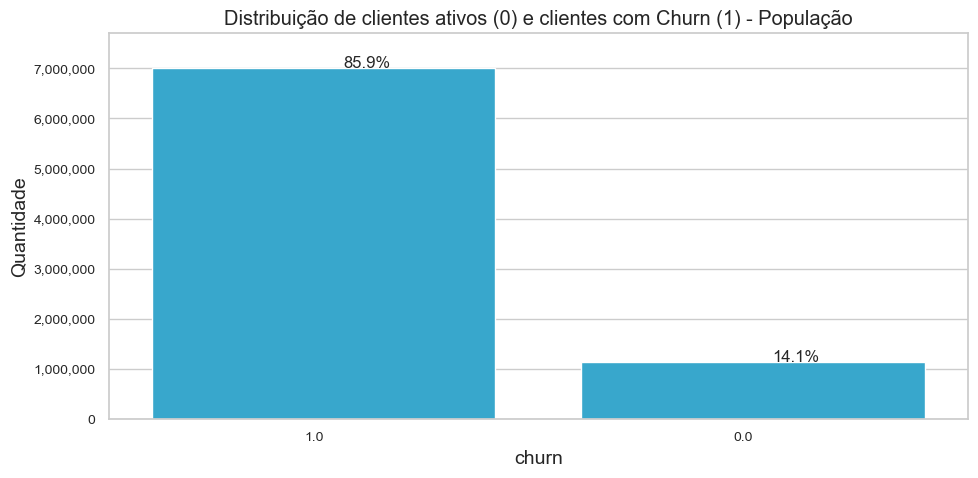

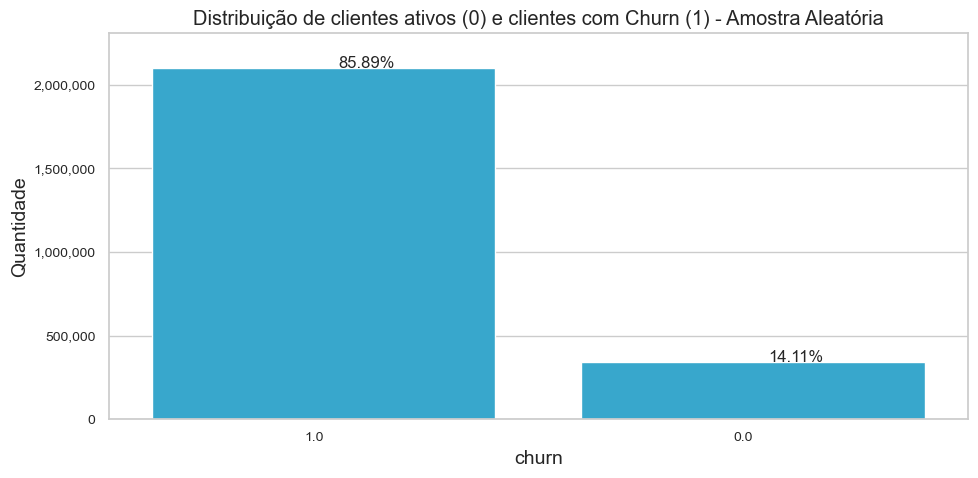

In [10]:
plota_barras(['churn'], False, tabela_de_membros, 1, 1, 'Distribuição de clientes ativos (0) e clientes com Churn (1) - População', 0)
plota_barras(['churn'], False, tabela_de_membros_amostra_aleatoria, 1, 1, 'Distribuição de clientes ativos (0) e clientes com Churn (1) - Amostra Aleatória', 0)

In [11]:
tabela_de_membros_amostra_aleatoria.to_parquet("../00_DataMaster/data/amostra_aleatoria_com_target.parquet", index = False)

# <font color='green' style='font-size: 30px;'> 1.4) Análise da Target</font>
<hr style='border: 2px solid green;'>

> 1. Como exposto nos gráficos abaixo, a distribuição entre clientes com CHURN e sem CHURN não é proporcional, portanto, estaremos lidando com um problema de desbalanceamento de classes e isso deverá ser tratado futuramente

> 2. Percebe-se também a presença de um pico de Churn muito mais alto nas safras 201601 e 201602 quando comparado a outros meses, portanto, serão desconsideradas no modelo por apresentarem patamares muito elevado


In [12]:
def plota_barras(lista_variaveis, hue, df, linhas, colunas, titulo, rotation):        

    k = 0
    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', color='#1FB3E5')
    ax.set_title(f'{titulo}')
    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
    ax.set_ylabel(f'Quantidade', fontsize = 14)
    total = []
    for bar in ax.patches:
        height = bar.get_height()
        total.append(height)
    total = builtins.sum(total)
    
    sizes = []
    for bar in ax.patches:
        height = bar.get_height()
        sizes.append(height)
        ax.text(bar.get_x() + bar.get_width()/1.6,
                height,
                f'{builtins.round((height/total)*100, 2)}%',
                ha = 'center',
                fontsize = 12
        )
    ax.set_ylim(0, builtins.max(sizes)*1.1)
    ax.set_xticklabels(df[lista_variaveis[k]].unique(), rotation = rotation, ha='right', fontsize=10)
    # Formatação manual dos rótulos do eixo y para remover a notação científica
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)
    # Adicionamos os nomes das categorias no eixo x
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

    plt.tight_layout()
    plt.show()

In [26]:
def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

A quantidade de amostras com Churn é 344492
A quantidade de amostras sem Churn é 2097832


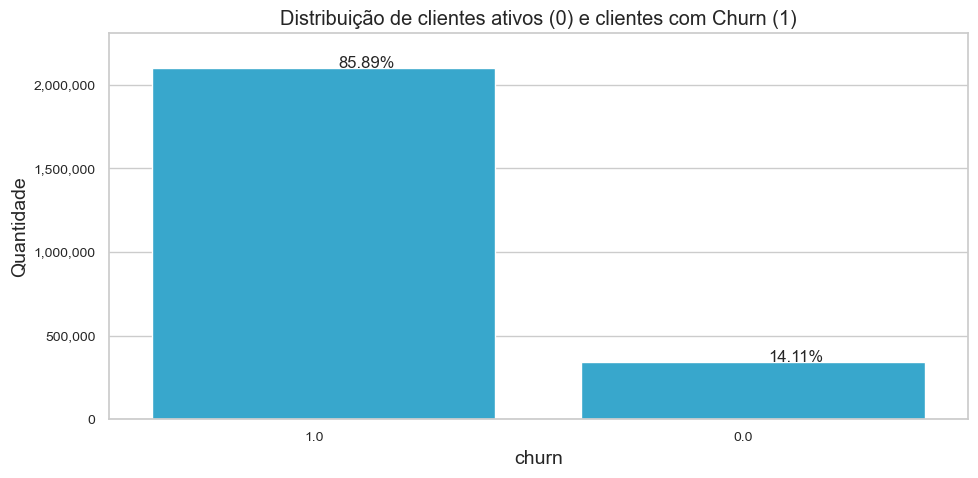

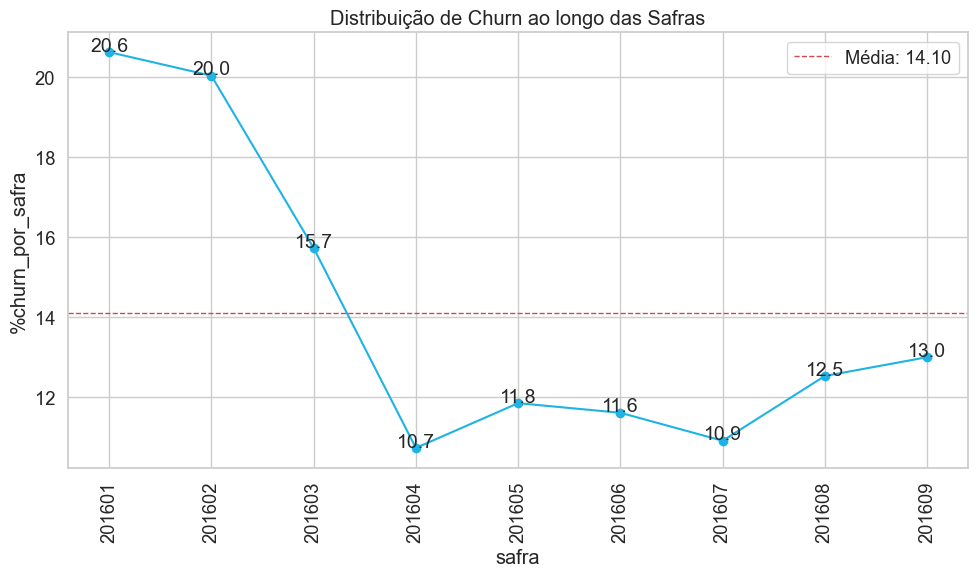

In [14]:
# RETIRANDO A SAFRA DE 2016-12-01 POIS ELA NÃO POSSUI TARGET

amostra_aleatoria_com_target = pd.read_parquet("../00_DataMaster/data/amostra_aleatoria_com_target.parquet")
#amostra_aleatoria_com_target["safra"] = amostra_aleatoria_com_target["safra"].apply(lambda x: x.strftime('%Y%m'))

# VOLUMETRIA
quantidade_de_amostras_com_churn = amostra_aleatoria_com_target.loc[amostra_aleatoria_com_target["churn"] == 1].shape[0]
quantidade_de_amostras_sem_churn = amostra_aleatoria_com_target.loc[amostra_aleatoria_com_target["churn"] == 0].shape[0]

print(f"A quantidade de amostras com Churn é {quantidade_de_amostras_com_churn}")
print(f"A quantidade de amostras sem Churn é {quantidade_de_amostras_sem_churn}")

plota_barras(['churn'], False, amostra_aleatoria_com_target, 1, 1, 'Distribuição de clientes ativos (0) e clientes com Churn (1)', 0)

# VOLUMETRIA AO LONGO DAS SAFRAS
churn_por_safra = amostra_aleatoria_com_target[["msno", "safra", "churn"]].groupby("safra").agg({"churn":"sum", "msno":"count"}).reset_index()
churn_por_safra["%churn_por_safra"] = round(churn_por_safra["churn"]/churn_por_safra["msno"]*100, 2)

plota_grafico_linhas(churn_por_safra, "safra", "%churn_por_safra", False, "Distribuição de Churn ao longo das Safras")

<font color='red' style='font-size: 40px;'> 2) Seleção das Amostras de Treinamento, Validação, Teste e OOT </font>
<hr style='border: 2px solid red;'>

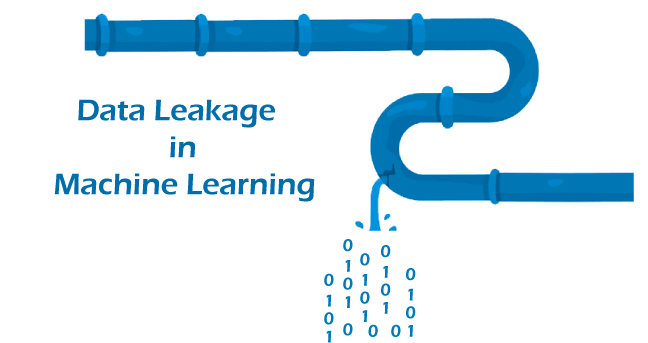

# <font color='green' style='font-size: 30px;'> 2.1) Puxando informações para a amostra aleatória </font>
<hr style='border: 2px solid green;'>

> 1. Como selecionamos uma amostra aleatória, devemos puxar as demais variáveis para iniciarmos efetivamente o case

> 2. Embora hajam safras mais antigas para as tabelas de Transações e User Logs, para as análises iniciais, optou-se por garantir manter as variáveis no mesmo intervalo temporal da Target (201601~201611)


In [15]:
# Amostra Aleatória
amostra_aleatoria_com_target = pd.read_parquet("../00_DataMaster/data/amostra_aleatoria_com_target.parquet")
amostra_aleatoria_com_target["safra"] = amostra_aleatoria_com_target["safra"].apply(lambda x:str(x))

# Tabela de Membros
tabela_de_membros = pd.read_parquet("../00_DataMaster/data/members.parquet").drop("is_ativo", axis = 1)
tabela_de_membros["safra"] = tabela_de_membros["safra"].apply(lambda x:str(x))

# Tabela de Transações
tabela_de_transacoes = pd.read_parquet("../00_DataMaster/data/transactions.parquet")
tabela_de_transacoes["safra"] = tabela_de_transacoes["safra"].apply(lambda x:str(x))
tabela_de_transacoes = tabela_de_transacoes.loc[tabela_de_transacoes["safra"].isin(['201601', '201602', '201603', '201604', '201605', '201606','201607', '201608', '201609', '201610', '201611'])]

# Tabela de User Logs
tabela_user_logs = pd.read_parquet("../00_DataMaster/data/user_logs.parquet")
tabela_user_logs["safra"] = tabela_user_logs["safra"].apply(lambda x:str(x))
tabela_user_logs = tabela_user_logs.loc[tabela_user_logs["safra"].isin(['201601', '201602', '201603', '201604', '201605', '201606','201607', '201608', '201609', '201610', '201611'])]


In [16]:
df_case_data_masters = amostra_aleatoria_com_target.merge(tabela_de_membros, on = ["msno", "safra"], how = "left")
df_case_data_masters = df_case_data_masters.merge(tabela_de_transacoes, on = ["msno", "safra"], how = "left")
df_case_data_masters = df_case_data_masters.merge(tabela_user_logs, on = ["msno", "safra"], how = "left")

In [17]:
df_case_data_masters.to_parquet("../00_DataMaster/data/df_case_data_masters.parquet", index = False)

# <font color='green' style='font-size: 30px;'> 2.2) Separação em Treino, Validação, Teste e OOT </font>
<hr style='border: 2px solid green;'>

> 1. A fim de evitar Data Leakage, decidiu-se separar os dados em treino, validação, teste e oot

> 2. Para cenário, separou-se da seguinte maneira:

- Treino + Validação --> 80% dos IDs entre 201603 e 201608, sendo 90% para Treinamento do Modelo e 10% para Validação.
- Teste --> 20% dos IDs do treino
- OOT --> Todos os IDs para 201609

> 3. Escolheu-se treinar o modelo com 201603 ~ 201608 para termos uma distribuiçao de churn relativamente constante ao longo dos meses; ao passo que 201609 ficou como OOT para avaliarmos se o modelo é estável

### Considerações

-  '201601', --> Distribuição de Churn muito distinta
-  '201602', --> Distribuição de Churn muito distinta
-  '201603', --> TREINAMENTO/TESTE
-  '201604', --> TREINAMENTO/TESTE
-  '201605', --> TREINAMENTO/TESTE
-  '201606', --> TREINAMENTO/TESTE
-  '201607', --> TREINAMENTO/TESTE
-  '201608', --> TREINAMENTO/TESTE
-  '201609', --> OOT
-  '201610', --> Safra incompleta para ser usada como Target
-  '201611', --> Safra incompleta para ser usada como Target
-  '201612' --> Safra incompleta para ser usada como Target

A quantidade de amostras no Treino (201603~201608) é: 1153551
A quantidade de amostras na Validação (201603~201608) é: 128905
A quantidade de amostras no Teste (201603~201608) é: 320996
A quantidade de amostras no OOT (201609) é: 297213


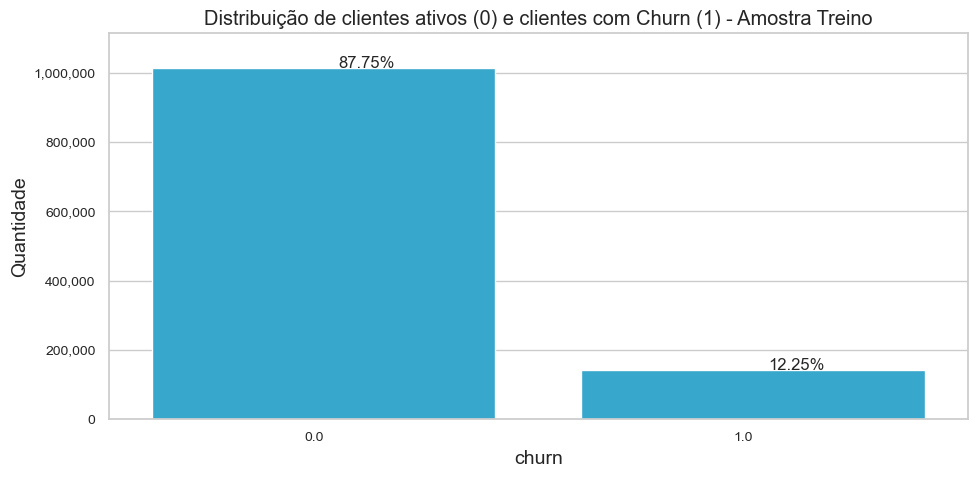

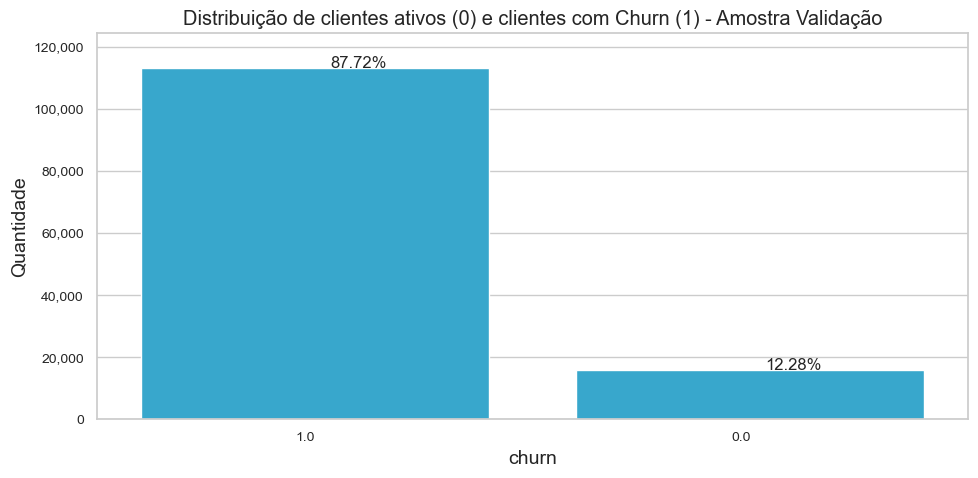

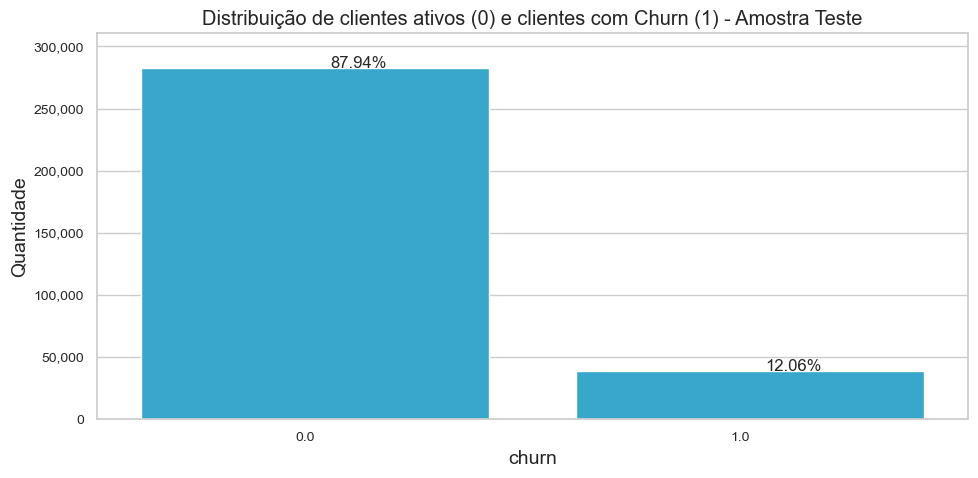

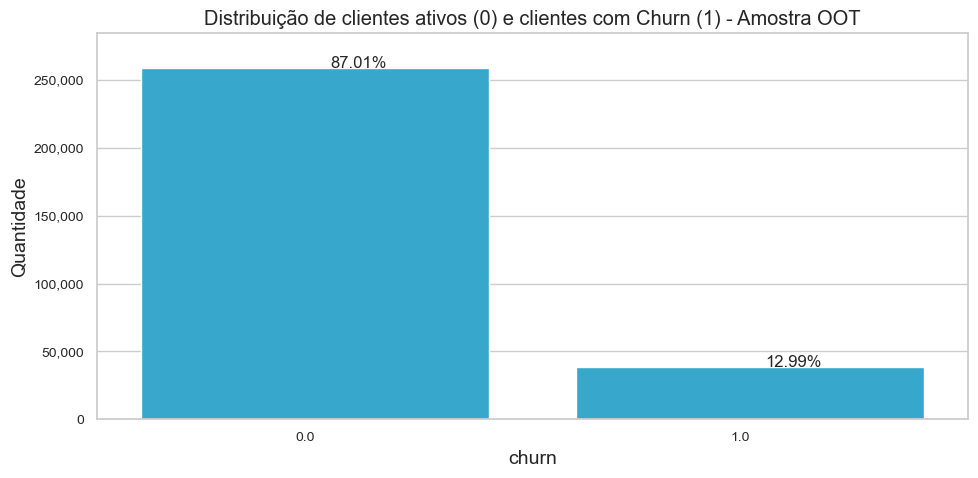

In [18]:
df_case_data_masters = pd.read_parquet("../00_DataMaster/data/df_case_data_masters.parquet")

amostra_treino_validacao = (
    df_case_data_masters
        .loc[~df_case_data_masters["safra"].isin(["201601", "201602", "201609", "201610", "201611"])]
        [["msno"]]
        .drop_duplicates()
        .sample(frac = 0.8, random_state = 42, replace = False)
)

train = (
    amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)
    [["msno"]]
    .drop_duplicates()
) 

valid = (
    amostra_treino_validacao.loc[~amostra_treino_validacao["msno"].isin(list(train["msno"].unique()))]
    [["msno"]]
    .drop_duplicates()
)

test = (
    df_case_data_masters
        .loc[
            (~df_case_data_masters["safra"].isin(["201601", "201602", "201609", "201610", "201611"])) & 
            (~df_case_data_masters["msno"].isin(list(train["msno"].unique()))) & 
            (~df_case_data_masters["msno"].isin(list(valid["msno"].unique())))
        ]
        [["msno"]]
        .drop_duplicates()
)

oot = (
    df_case_data_masters
        .loc[
            (df_case_data_masters["safra"].isin(["201609"]))
        ]
        [["msno"]]
        .drop_duplicates()
)

df_train = train.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602", "201609", "201610", "201611"])], on = "msno", how = "left")
df_valid = valid.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602", "201609", "201610", "201611"])], on = "msno", how = "left")
df_test = test.merge(df_case_data_masters.loc[~df_case_data_masters["safra"].isin(["201601", "201602", "201609", "201610", "201611"])], on = "msno", how = "left")
df_oot = oot.merge(df_case_data_masters.loc[df_case_data_masters["safra"].isin(["201609"])], on = "msno", how = "left")

print(f"A quantidade de amostras no Treino (201603~201608) é: {df_train.shape[0]}")
print(f"A quantidade de amostras na Validação (201603~201608) é: {df_valid.shape[0]}")
print(f"A quantidade de amostras no Teste (201603~201608) é: {df_test.shape[0]}")
print(f"A quantidade de amostras no OOT (201609) é: {df_oot.shape[0]}")

amostras = [df_train, df_valid, df_test, df_oot]
tipo = ["Treino", "Validação", "Teste", "OOT"]
i = 0
for amostra in amostras:

    plota_barras(['churn'], False, amostra, 1, 1, f'Distribuição de clientes ativos (0) e clientes com Churn (1) - Amostra {tipo[i]}', 0)

    i = i + 1

In [20]:
df_train.to_parquet("../00_DataMaster/data/df_train.parquet", index = False)
df_valid.to_parquet("../00_DataMaster/data/df_valid.parquet", index = False)
df_test.to_parquet("../00_DataMaster/data/df_test.parquet", index = False)
df_oot.to_parquet("../00_DataMaster/data/df_oot.parquet", index = False)

<font color='red' style='font-size: 40px;'> 3)  Análise Exploratória - Feita apenas com a Amostra de **TREINO**</font>
<hr style='border: 2px solid red;'>

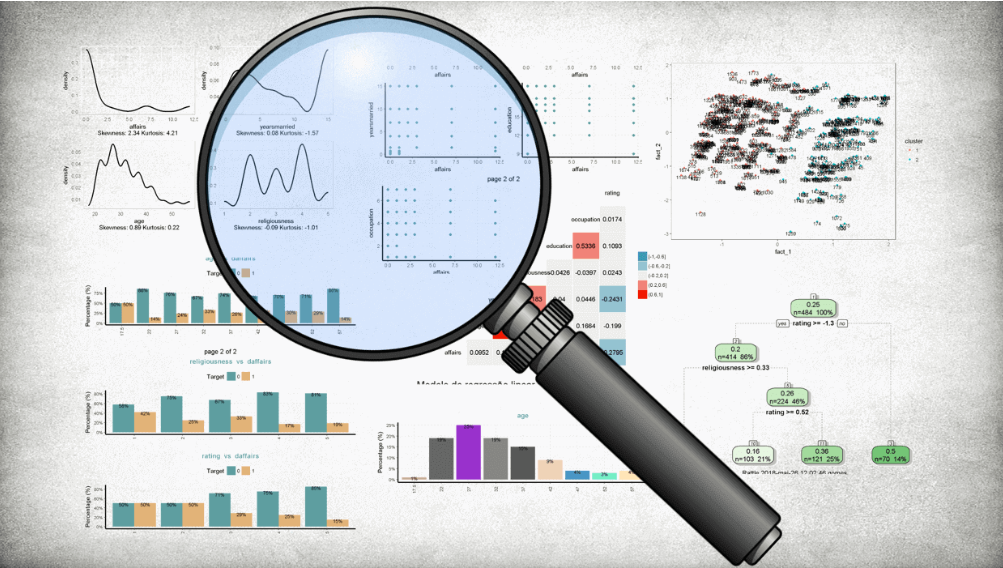

In [13]:
df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")
df_valid = pd.read_parquet("../00_DataMaster/data/df_valid.parquet")
df_test = pd.read_parquet("../00_DataMaster/data/df_test.parquet")
df_oot = pd.read_parquet("../00_DataMaster/data/df_oot.parquet")

colunas_ordenadas = [
    "msno", "churn", "safra", 'is_cancel',
    'is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id', 
    'payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
    "registration_init_time", "transaction_date", "membership_expire_date"
] 

df_train = df_train[colunas_ordenadas]
df_valid = df_valid[colunas_ordenadas]
df_test = df_test[colunas_ordenadas]
df_oot = df_oot[colunas_ordenadas]

# <font color='green' style='font-size: 30px;'> 3.1) Identificação de tipos de variáveis </font>
<hr style='border: 2px solid green;'>

> 1. Inicialmente, decidiu-se analisar quantos valores distintos há em cada variável

> 2. Variáveis com menos valores distintos tendem a ser categóricas, ao passo que muitos valores distintos tendem a ser contínuas

> 3. Além disso, somado a descrição da variável, pode-se inferir seu tipo com mais acurácia

> 4. Notou-se também que algumas variáveis estão em um formato não condizente (idade em string, por exemplo). Para corrigir isso, modificou-se o tipo das variáveis de maneira a corrigí-las.

In [14]:
def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]


In [15]:
# Dados das variáveis e suas descrições
data = {
    'base': [
        'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members', 'Base Members',
        'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions', 'Base Transactions',
        'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs', 'Base User Logs'
    ],
    'variavel': [
        'msno', 'city', 'bd', 'registered_via', 'registration_init_time', 'gender', 'is_ativo', 'safra',
        'msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'transaction_date', 'membership_expire_date', 'is_cancel',
        'msno', 'safra', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'
    ],
    'descricao': [
        'user id', 'cidade', 'idade --> essa coluna tem outliers desde -7000 até 2015', 'tipo de registro', 'data do registro inicial no formato %Y%m%d', 'gênero', 'assinatura ativa (Target Classificador Problema 1)', 'safra',
        'user id', 'método de pagamento', 'quantidade de dias de afiliação', 'preço', 'montante pago', 'flag renovação automática', 'data da transação no formato %Y%m%d', 'data de expiração da afiliação', 'flag que indica se o usuário cancelou ou não a afiliação nesta transação',
        'user id', 'safra', 'quantidade de músicas tocadas por menos de 25% da duração da música', 'quantidade de músicas tocadas entre 25% e 50% da duração da música', 'quantidade de músicas tocadas entre 50% e 75% da duração da música', 'quantidade de músicas tocadas entre 75% até 98.5% da duração da música', 'quantidade de músicas tocadas entre 98.5% até 100% da duração da música', 'quantidade única de músicas já tocadas', 'numero total de segundos tocados'
    ]
}

df_variaveis_descricoes = pd.DataFrame(data)
df_variaveis_tipos = pd.DataFrame(df_train.dtypes).reset_index().rename({"index":"variavel", 0:"tipagem"}, axis = 1)

# Dados dos tipos das variáveis
target = ["churn"]
user_id = ["msno"]
variaveis_de_data = ["safra", "registration_init_time", "transaction_date", "membership_expire_date"]
variaveis_categoricas_continuas = {}

for var in df_train.drop(target + user_id + variaveis_de_data, axis=1).columns:
    variaveis_categoricas_continuas[var] = int(df_train[var].nunique())

variaveis_categoricas_continuas_df = pd.DataFrame(list(variaveis_categoricas_continuas.items()), columns=['variavel', 'quantidade_valores_distintos']).sort_values(by = "quantidade_valores_distintos", ascending = True)
variaveis_categoricas_continuas_df = variaveis_categoricas_continuas_df.merge(df_variaveis_descricoes, on = "variavel", how = "left")
variaveis_categoricas_continuas_df = variaveis_categoricas_continuas_df.merge(df_variaveis_tipos, on = 'variavel', how = 'left')
variaveis_categoricas_continuas_df = variaveis_categoricas_continuas_df[['variavel','quantidade_valores_distintos', 'tipagem', 'base', 'descricao']]

display(variaveis_categoricas_continuas_df)


variavel  quantidade_valores_distintos  tipagem               base                                                                 descricao
0            is_cancel                             2   object  Base Transactions  flag que indica se o usuário cancelou ou não a afiliação nesta transação
1        is_auto_renew                             2   object  Base Transactions                                                 flag renovação automática
2               gender                             2   object       Base Members                                                                    gênero
3       registered_via                             5   object       Base Members                                                          tipo de registro
4                 city                            21   object       Base Members                                                                    cidade
5    payment_plan_days                            25   object  Base Transactions                                           quantidade de dias de afiliação
6    payment_method_id                            33   object  Base Transactions                                                       método de pagamento
7   actual_amount_paid                            38   object  Base Transactions                                                             montante pago
8      plan_list_price                            38   object  Base Transactions                                                                     preço
9                   bd                           168   object       Base Members                   idade --> essa coluna tem outliers desde -7000 até 2015
10              num_75                           504  float64     Base User Logs        quantidade de músicas tocadas entre 50% e 75% da duração da música
11              num_50                           795  float64     Base User Logs        quantidade de músicas tocadas entre 25% e 50% da duração da música
12             num_985                           877  float64     Base User Logs    quantidade de músicas tocadas entre 75% até 98.5% da duração da música
13              num_25                          2397  float64     Base User Logs       quantidade de músicas tocadas por menos de 25% da duração da música
14             num_unq                          5599  float64     Base User Logs                                    quantidade única de músicas já tocadas
15             num_100                          7072  float64     Base User Logs   quantidade de músicas tocadas entre 98.5% até 100% da duração da música
16          total_secs                       1030473  float64     Base User Logs                                          numero total de segundos tocados

In [16]:
# Fazendo o tratamento para facilitar a análise exploratória
df_train["is_auto_renew"] = muda_tipagem_variavel(df_train, "is_auto_renew", "int")
df_train["is_cancel"] = muda_tipagem_variavel(df_train, "is_cancel", "int")
df_train["bd"] = muda_tipagem_variavel(df_train, "bd", "int")
df_train["registered_via"] = muda_tipagem_variavel(df_train, "registered_via", "int")
df_train["payment_plan_days"] = muda_tipagem_variavel(df_train, "payment_plan_days", "float")
df_train["plan_list_price"] = muda_tipagem_variavel(df_train, "plan_list_price", "float")
df_train["actual_amount_paid"] = muda_tipagem_variavel(df_train, "actual_amount_paid", "float")

# Organizando tipos de variáveis
variaveis_desconsideradas = ['is_cancel', "transaction_date", "membership_expire_date"]
variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']
variaveis_continuas = ['payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
variaveis_de_data = ["registration_init_time"]
safra = ["safra"]
target = ["churn"]
user_id = ["msno"]

# <font color='green' style='font-size: 30px;'> 3.2) Identificação inconsistências nas variáveis </font>
<hr style='border: 2px solid green;'>

> 1. Muitas variáveis possuem diversos valores nulos

> 2. Ao que tudo indica, existem três tipos de nulos:

- Variáveis cadastrais nulas
- Variáveis de consumo nulas
- Variáveis cadastrais e de consumo nulas

> 3. Na etapa de pré-processamento devemos levar isso em consideração e tratá-los de alguma forma

- Quantidade de registros nulos na base 

Existem 17 variáveis no Dataset
Existem 4 variáveis sem registros nulos no Dataset


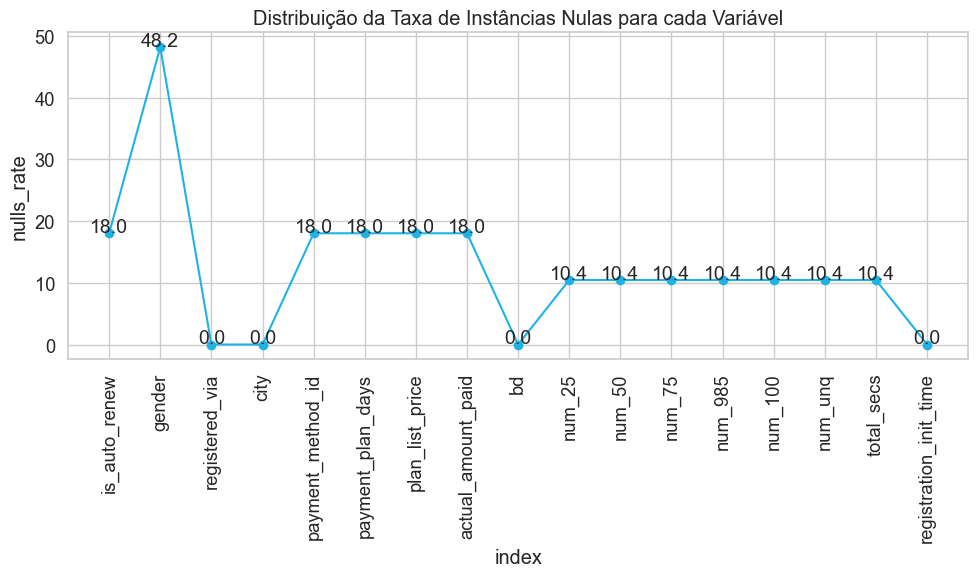

In [27]:
df_nulls = (
    pd.DataFrame(
        df_train
        .drop(["msno", "safra", "churn"] + variaveis_desconsideradas, axis = 1)
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_train.shape[0])*100, 2)

print(f'Existem {len(df_nulls)} variáveis no Dataset')
df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
columns_not_nulls = list(df_not_nulls_nulls['index'])
print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 3.3) Análise de Variáveis Contínuas </font>
<hr style='border: 2px solid green;'>

> 1. Nesta etapa, objetiva-se entender o padrão das variáveis contínuas

> 2. Inicialmente, decidiu-se analisar a distribuição de cada uma delas a fim de entender se há Outliers incomuns (erros) em cada variável. Para isso, pode-se avaliar os percentis de cada variável, excluindo os dois extremos (p5 e p95, por exemplo)

> 3. Além disso, podemos entender se existe correlação entre as variáveis, pois se existir e ela for muito forte, uma dessas variáveis poderá ser eliminada durante o processo de treinamento do Modelo

> 4. Finalmente, pode-se avaliar a diferença de distribuição de cada variável em relação aas amostras Churn e Não Churn, pois isso mostraria variáveis com potencial de discriminação entre ambas as classes

- Análise de Distribuição

In [18]:
def analisa_distribuicao_via_percentis(df, variaveis):
    def sublinha_percentis(s):
        is_1_percentile = s.name == '1%'
        is_99_8_percentile = s.name == '99%'
        if is_1_percentile or is_99_8_percentile:
            return ['background-color: blue'] * len(s)
        else:
            return [''] * len(s)

    percentis = df[variaveis].describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).style.apply(sublinha_percentis, axis=1)    

    return percentis

In [19]:
### Retirando amostras nulas para ver a distribuição
df_eda_continuas = df_train[variaveis_continuas].dropna().copy()
for col in df_eda_continuas[variaveis_continuas]:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x:float(x))

analisa_distribuicao_via_percentis(df_eda_continuas, variaveis_continuas)

- Analisando se há diferença significativa entre clientes Churn e Não Churn 

In [32]:
def compara_medias_amostras(df, variaveis_continuas):  
    num_variaveis = len(variaveis_continuas)
    num_pares = (num_variaveis + 1) // 2  # Número de pares de variáveis para subplots
    fig, axes = plt.subplots(num_pares, 2, figsize=(14, 4 * num_pares))

    # Ajusta para o caso onde há apenas uma variável
    if num_pares == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(num_pares):
        if 2 * i < num_variaveis:
            variavel1 = variaveis_continuas[2 * i]
            percentis1 = df[variavel1].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_1 = percentis1['1%']
            p99_1 = percentis1['99%']
            df_raw1 = df.loc[(df[variavel1] > p1_1) & (df[variavel1] < p99_1)].copy()
            df_com_churn1 = df_raw1.loc[df_raw1["churn"] == 1]
            df_sem_churn1 = df_raw1.loc[df_raw1["churn"] == 0]
            
            medias_amostrais_com_churn1 = []
            medias_amostrais_sem_churn1 = []
            
            for j in range(5000):
                amostra_churn1 = random.choices(df_com_churn1[variavel1].values, k=1000)
                media_amostra_churn1 = np.mean(amostra_churn1)
                medias_amostrais_com_churn1.append(media_amostra_churn1)

                amostra_sem_churn1 = random.choices(df_sem_churn1[variavel1].values, k=1000)
                media_amostra_sem_churn1 = np.mean(amostra_sem_churn1)
                medias_amostrais_sem_churn1.append(media_amostra_sem_churn1)

            ax_hist1 = axes[i, 0]
            ax_hist1.hist(medias_amostrais_com_churn1, bins=30, alpha=0.5, label='Churn', linewidth=5, color="red")
            ax_hist1.hist(medias_amostrais_sem_churn1, bins=30, alpha=0.5, label='Sem Churn', linewidth=5, color="green")
            ax_hist1.legend(loc='upper right')
            ax_hist1.set_xlabel('Valores')
            ax_hist1.set_ylabel('Frequência')
            ax_hist1.set_title(f'Distribuição das Médias Amostrais de "{variavel1}" ')
            ax_hist1.grid(True)
        
        if 2 * i + 1 < num_variaveis:
            variavel2 = variaveis_continuas[2 * i + 1]
            percentis2 = df[variavel2].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_2 = percentis2['1%']
            p99_2 = percentis2['99%']
            df_raw2 = df.loc[(df[variavel2] > p1_2) & (df[variavel2] < p99_2)].copy()
            df_com_churn2 = df_raw2.loc[df_raw2["churn"] == 1]
            df_sem_churn2 = df_raw2.loc[df_raw2["churn"] == 0]
            
            medias_amostrais_com_churn2 = []
            medias_amostrais_sem_churn2 = []
            
            for j in range(5000):
                amostra_churn2 = random.choices(df_com_churn2[variavel2].values, k=1000)
                media_amostra_churn2 = np.mean(amostra_churn2)
                medias_amostrais_com_churn2.append(media_amostra_churn2)

                amostra_sem_churn2 = random.choices(df_sem_churn2[variavel2].values, k=1000)
                media_amostra_sem_churn2 = np.mean(amostra_sem_churn2)
                medias_amostrais_sem_churn2.append(media_amostra_sem_churn2)

            ax_hist2 = axes[i, 1]
            ax_hist2.hist(medias_amostrais_com_churn2, bins=30, alpha=0.5, label='Churn', linewidth=5, color="red")
            ax_hist2.hist(medias_amostrais_sem_churn2, bins=30, alpha=0.5, label='Sem Churn', linewidth=5, color="green")
            ax_hist2.legend(loc='upper right')
            ax_hist2.set_xlabel('Valores')
            ax_hist2.set_ylabel('Frequência')
            ax_hist2.set_title(f'Distribuição das Médias Amostrais de "{variavel2}" ')
            ax_hist2.grid(True)

    plt.tight_layout()
    plt.show()


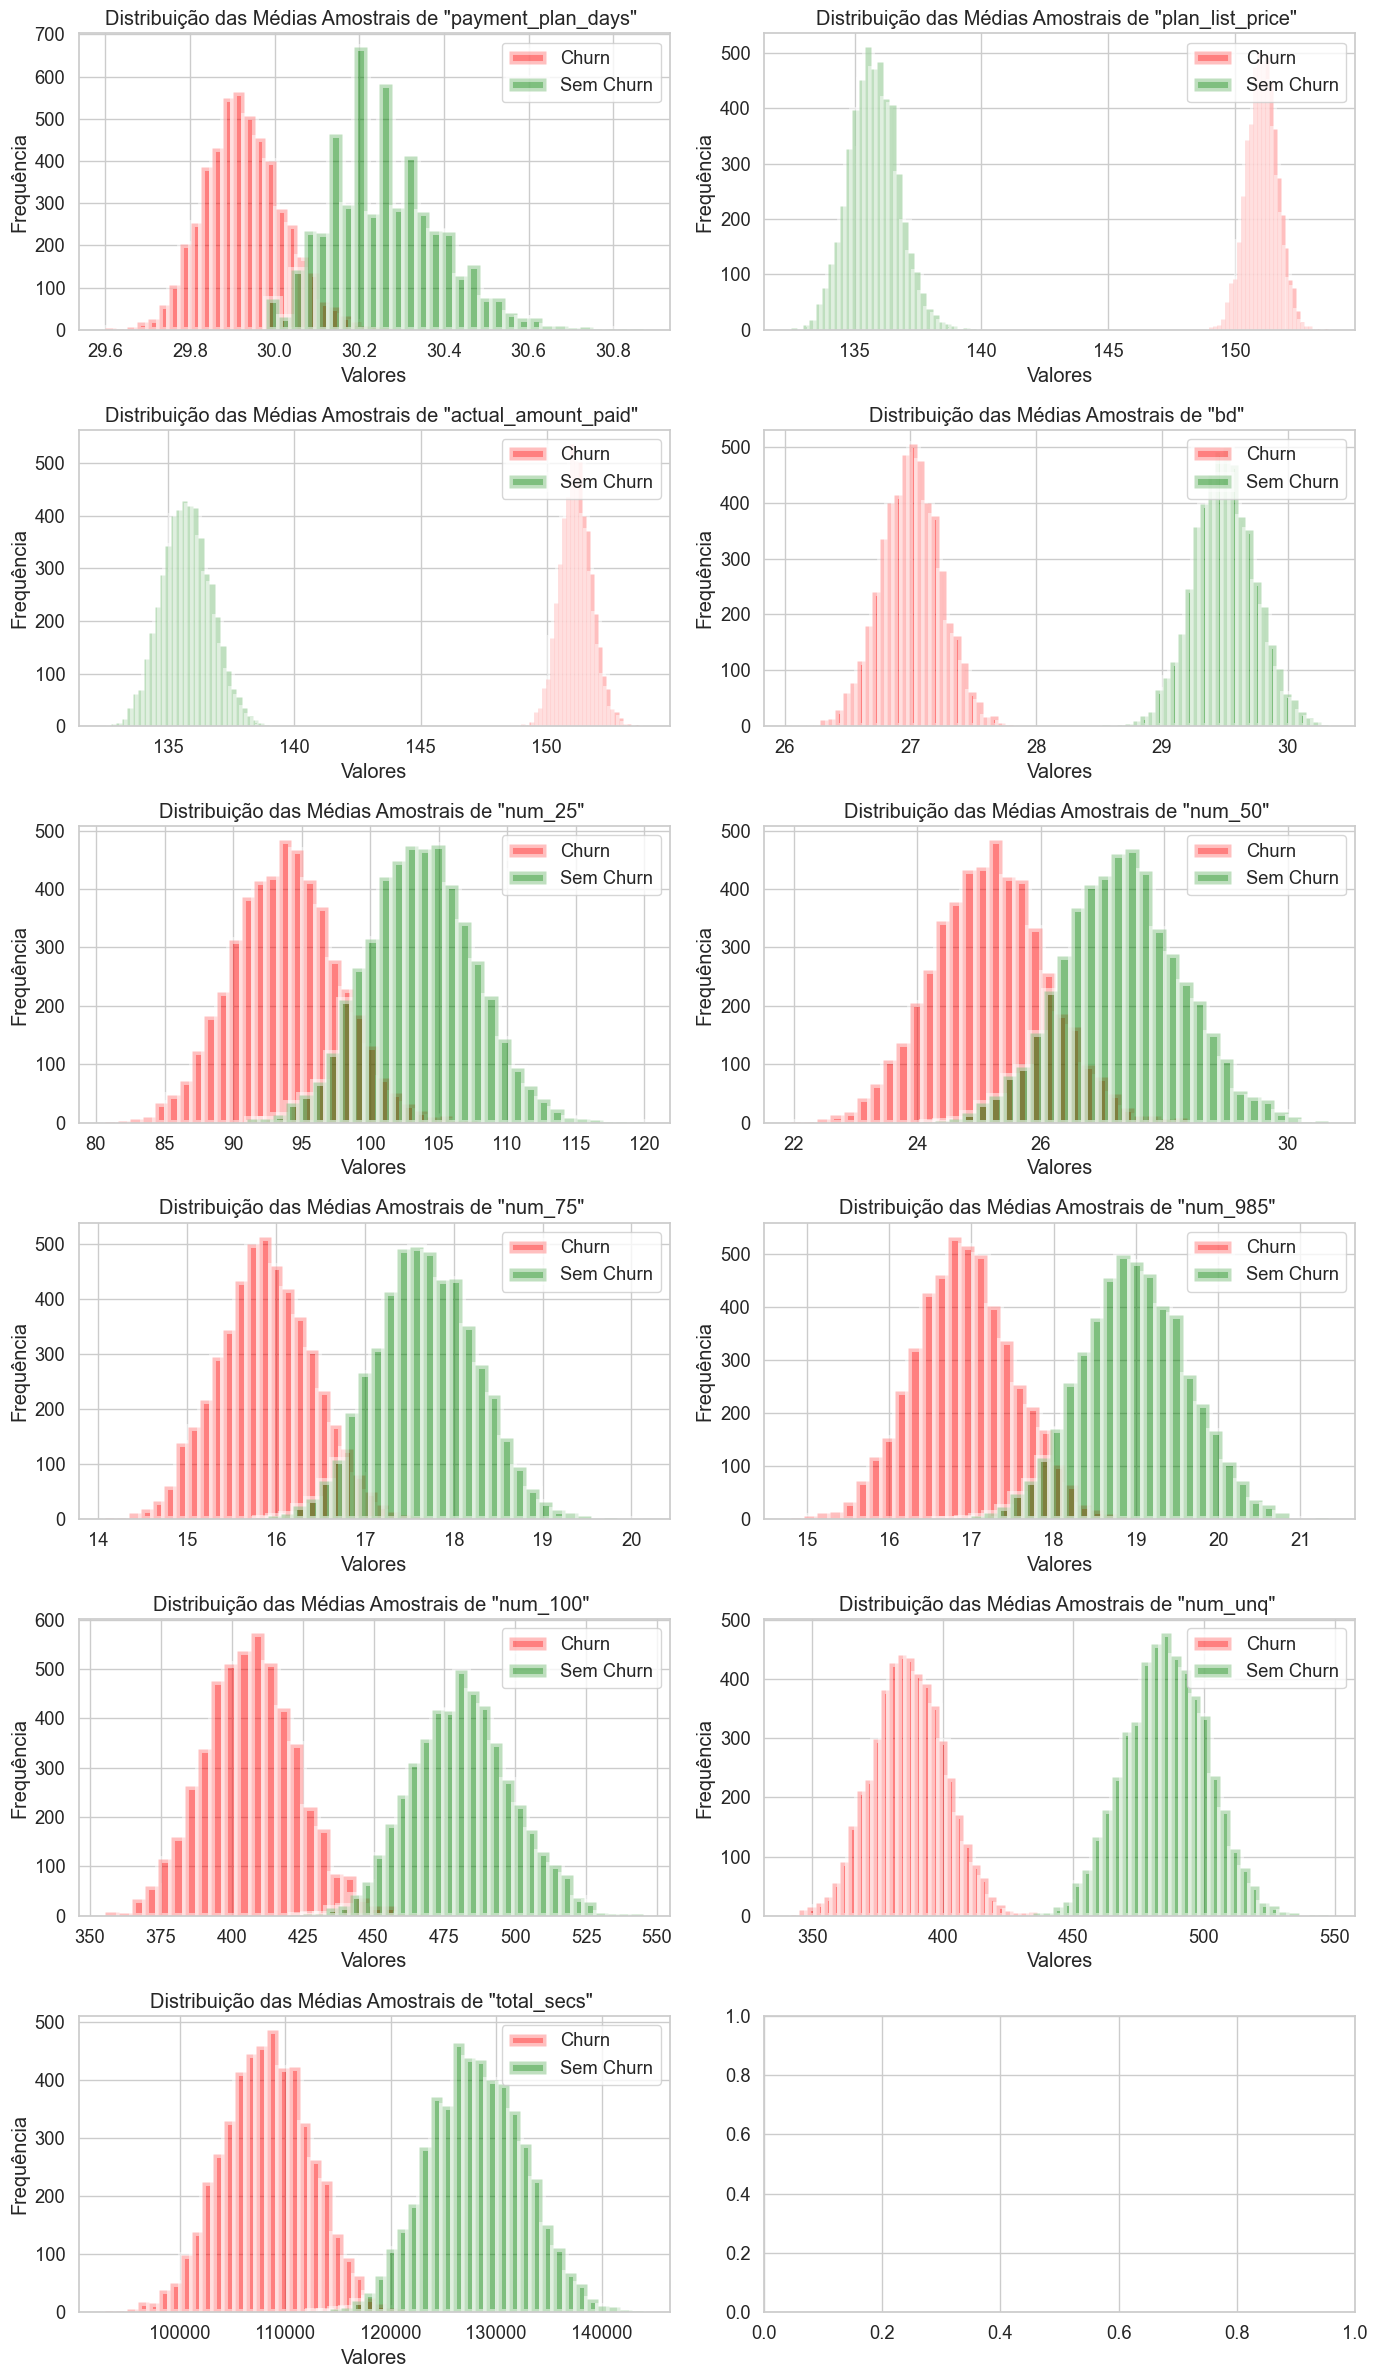

In [33]:
df_eda_continuas = df_train[variaveis_continuas + ["churn"]].dropna().copy()
for col in variaveis_continuas:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x: float(x))

compara_medias_amostras(df_eda_continuas, variaveis_continuas)

# <font color='green' style='font-size: 30px;'> 3.4) Análise de Variáveis Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. A respeito da análise de variáveis categóricas, decidiu-se utilizar o WOE (Weight of Evidence). 

> 2. O WOE é uma métrica a qual identifica aassociação entre uma determinada classse e a variável resposta. Neste caso, a classe "A" da variável categórica pode ter ou não uma associação forte em relação ao cliente abandonar a empresa.

> 3. Valores positivos de WOE indicam que a categoria está associada a um maior risco de churn, enquanto valores negativos indicam menor risco

- Análise por Weight of Evidence

In [34]:
def woe(df, feature, target):
    churn = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'churn'}, axis = 1)
    sem_churn = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_churn'}, axis = 1)

    woe = churn.merge(sem_churn, on = feature, how = 'left')
    woe['percent_churn'] = woe['churn']/woe['churn'].sum()
    woe['percent_sem_churn'] = woe['sem_churn']/woe['sem_churn'].sum()
    woe['woe'] = round(np.log(woe['percent_churn']/woe['percent_sem_churn']), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    
    weight_of_evidence = woe['woe'].unique()


    x = list(woe[feature])
    y = list(woe['woe'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker='o', linestyle='--', linewidth=2, color='#1FB3E5')

    for label, value in zip(x, y):
        plt.text(x=label, y=value, s=str(value), fontsize=10, color='red', ha='left', va='center', rotation=45)

    plt.title(f'Weight of Evidence da variável "{feature}"', fontsize=14)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Weight of Evidence', fontsize=14)
    plt.xticks(ha='right', fontsize=10, rotation=45)
    plt.show()

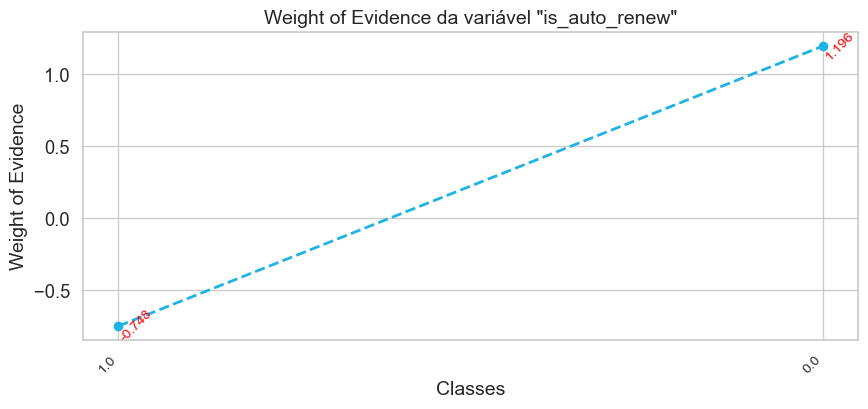

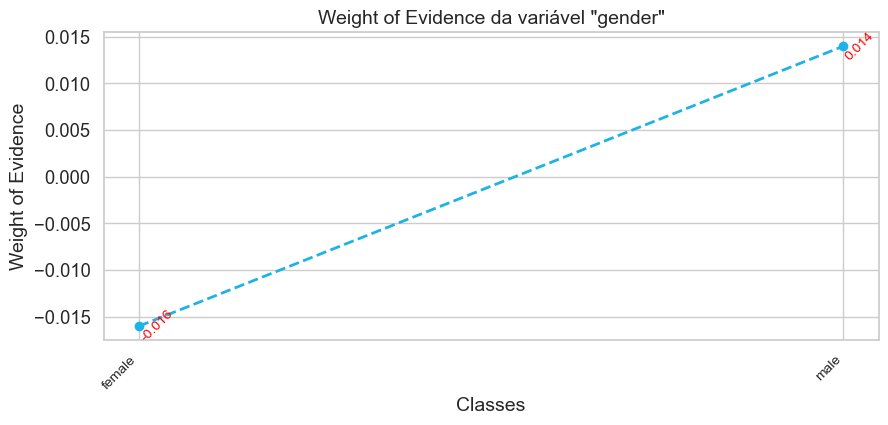

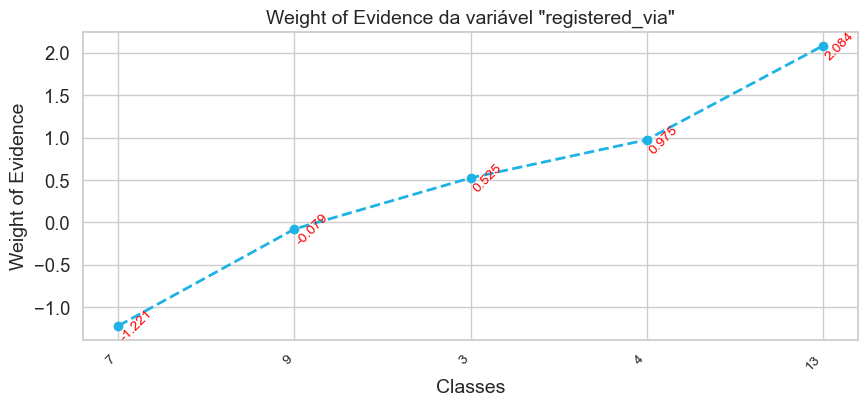

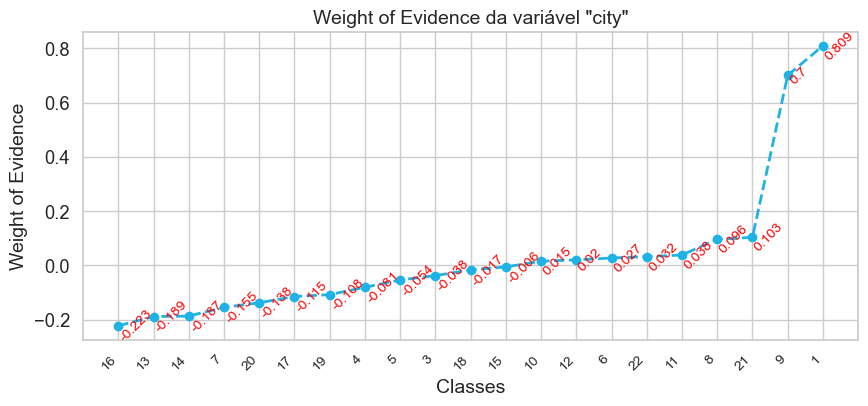

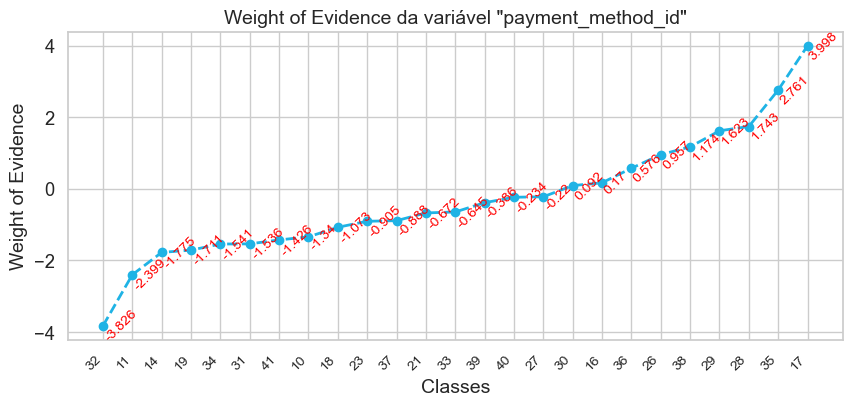

In [35]:
df_eda_categoricas = df_train[variaveis_categoricas + ["churn"]].dropna().copy()
for col in df_eda_categoricas[variaveis_categoricas].columns:
    df_eda_categoricas[col] = df_eda_categoricas[col].apply(lambda x:str(x))
    woe(df_eda_categoricas, col, "churn")

<font color='red' style='font-size: 40px;'> 4)  Feature Engineering </font>
<hr style='border: 2px solid red;'>

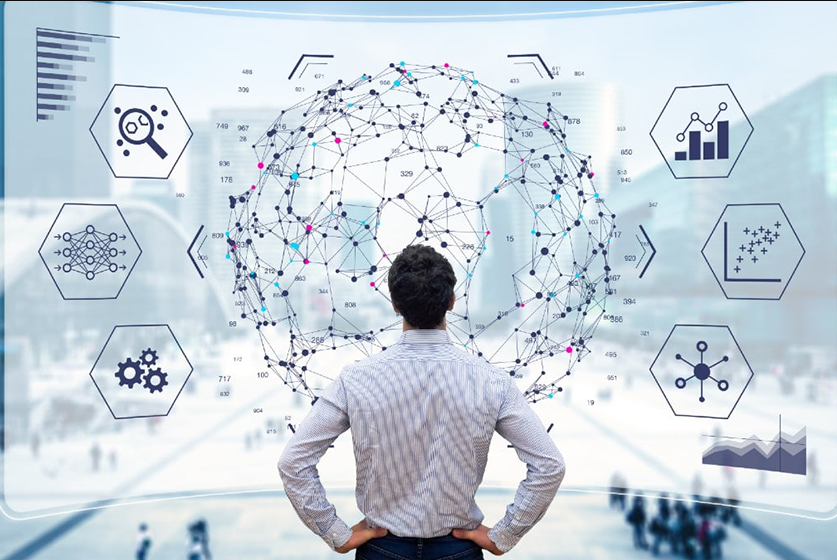

### 1) Base Members

> 1. msno: user id

> 2. city: cidade

> 3. bd: idade --> essa coluna tem outliers desde -7000 até 2015

> 4. registered_via: tipo de registro

> 5. registration_init_time: data do registro inicial no formato %Y%m%d

> 6. gender: gênero

> 7. is_ativo: assinatura ativa (Target Classificador Problema 1)

> 8. safra: safra

### 2) Base Transacations

> 1. msno: user id

> 2. payment_method_id: método de pagamento

> 3. payment_plan_days: quantidade de dias de afiliação

> 4. plan_list_price: preço

> 5. actual_amount_paid: montante pago

> 6. is_auto_renew: flag renovação automática

> 7. transaction_date: data da transação no formato %Y%m%d

> 8. membership_expire_date: data de expiração da afiliação

> 9. is_cancel: flag que indica se o usuário cancelou ou não a afiliação nesta transação

> 10. safra: safra

### 3) Base User Logs

> 1. msno: user id

> 2. num_25: quantidade de músicas tocadas por menos de 25% da duração da música

> 3. num_50: quantidade de músicas tocadas entre 25% e 50% da duração da música

> 4. num_75: quantidade de músicas tocadas entre 50% e 75% da duração da música

> 5. num_985: quantidade de músicas tocadas entre 75% até 98.5% da duração da música

> 6. num_100: quantidade de músicas tocadas entre 98.5% até 100% da duração da música

> 7. num_unq: quantidade única de músicas já tocadas

> 8. total_scs: número total de segundos tocados

> 9. safra: safra

In [36]:
### Puxando informações de Treino, Validação, Teste e OOT

df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")
df_valid = pd.read_parquet("../00_DataMaster/data/df_valid.parquet")
df_test = pd.read_parquet("../00_DataMaster/data/df_test.parquet")
df_oot = pd.read_parquet("../00_DataMaster/data/df_oot.parquet")


colunas_ordenadas = [
    "msno", "churn", "safra", 
    'is_auto_renew', 'is_cancel', 'gender', 'registered_via', 'city', 'payment_method_id', 
    'payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
    "registration_init_time", "transaction_date", "membership_expire_date"
] 

df_train = df_train[colunas_ordenadas]
df_valid = df_valid[colunas_ordenadas]
df_test = df_test[colunas_ordenadas]
df_oot = df_oot[colunas_ordenadas]

# <font color='green' style='font-size: 30px;'> 4.1) Feautre 1 - Quantidade de meses desde a data de registro  </font>
<hr style='border: 2px solid green;'>

> 1. Podemos avaliar a data de registro do cliente e entender quais são clientes que estão registrados há muito tempo, assim como os novos clientes 

> 2. Pode ser que o tempo de registro nos traga alguma informação interessante

In [37]:
def months_as_a_registered(df):

    df["registration_init_time"] = df["registration_init_time"].apply(lambda x:str(x)[:6])

    # Converter as colunas para objetos datetime
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m')
    df['safra'] = pd.to_datetime(df['safra'], format='%Y%m')

    # Calcular a diferença de meses
    df['months_as_a_registered'] = (df['safra'].dt.year - df['registration_init_time'].dt.year) * 12 + (df['safra'].dt.month - df['registration_init_time'].dt.month)
    df["safra"] = df["safra"].apply(lambda x:str(x)[:7].replace("-", ""))

    return df['months_as_a_registered']

In [38]:
df_train['months_as_a_registered'] = months_as_a_registered(df_train)

# <font color='green' style='font-size: 30px;'> 4.2) Features 3 - Prorporção de músicas com ao menos 50% do tempo escutado  </font>
<hr style='border: 2px solid green;'>


> 1. Pela análise exploratória, notou-se forte correlação entre a quantidade de músicas tocadas sob uma certa duração e a duração subsequente. Isso significa que num_25 está muito correlacionada com num_50, ao passo que esta é muito correlacionada com num_75

> 2. Mesmo assim, num_25 não tem tanta correlação com num_100. Além disso, pelos gráficos mostrados na análise de bootstrap vimos que o num_25 e num_50 possuíam uma sobreposição de distribuições para o público com churn e sem churn, ao passo que o num_75, num_985 e num_100 não possuíam essa sobreposição.

> 3. Dada a situação, significa que há uma certa diferença entre pessoas que terminam de escutar suas músicas e aquelas que não terminam, portanto, criaremos uma variável que represente isso

In [39]:
def num_more_than_50(df):

    df["num_less_than_50"] = df["num_25"] + df["num_50"]
    df["num_more_than_50"] = df["num_75"] + df["num_985"] + df["num_100"]
    df["%num_more_than_50"] = round(df["num_more_than_50"]/(df["num_more_than_50"]+df["num_less_than_50"])*100, 2)

    return df["%num_more_than_50"]


In [40]:
df_train["%num_more_than_50"] = num_more_than_50(df_train)

# <font color='green' style='font-size: 30px;'> 4.3) Criação de Features envolvendo tempo  </font>
<hr style='border: 2px solid green;'>

> 1. Como temos acesso a safras antigas, pode-se criar variáveis atreladas ao tempo

> 2. Esse tipo de variável é importante pois ela consegue suavizar a variável pura, de modo que grandes picos/vales fiquem menos expressos. Isso é bom, visto que passamos para o modelo o comportamento comum do cliente, e não possíveis outliers, conferindo maior estabilidade ao modelo

> 3. Decidiu-se salvar um .parquet com as features processadas para facilitar o desenvolvimento do projeto, pois o cálculo das médias móveis demorava em torno de 15min

In [41]:
def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]

In [42]:
def media_movel(df, feature, window):

    df[f"{feature}_mov_avg_m{window}"] = df.groupby('msno')[feature].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
                                           
    return df[f"{feature}_mov_avg_m{window}"]

In [46]:
def max_movel(df, feature, window):

    df[f"{feature}_mov_max_m{window}"] = df.groupby('msno')[feature].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
    
    return df[f"{feature}_mov_max_m{window}"]

In [47]:
def min_movel(df, feature, window):

    df[f"{feature}_mov_min_m{window}"] = df.groupby('msno')[feature].rolling(window=window, min_periods=1).min().reset_index(level=0, drop=True)
    
    return df[f"{feature}_mov_min_m{window}"]

In [44]:
### Puxando informações das safras antigas

tabela_de_transacoes = pd.read_parquet("../00_DataMaster/data/transactions.parquet")
tabela_de_transacoes["safra"] = tabela_de_transacoes["safra"].apply(lambda x:str(x))
tabela_de_transacoes = tabela_de_transacoes[["msno", "safra", "payment_plan_days", "actual_amount_paid"]].sort_values(by=['msno', 'safra'], ascending = True)
tabela_de_transacoes["payment_plan_days"] = muda_tipagem_variavel(tabela_de_transacoes, "payment_plan_days", "float")
tabela_de_transacoes["actual_amount_paid"] = muda_tipagem_variavel(tabela_de_transacoes, "actual_amount_paid", "float")

tabela_user_logs = pd.read_parquet("../00_DataMaster/data/user_logs.parquet")
tabela_user_logs["%num_more_than_50"] = num_more_than_50(tabela_user_logs)
tabela_user_logs["safra"] = tabela_user_logs["safra"].apply(lambda x:str(x))
tabela_user_logs = tabela_user_logs[["msno", "safra", 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]].sort_values(by=['msno', 'safra'], ascending = True)

# Criando Features envolvendo tempo

for feature in ['actual_amount_paid']:
    tabela_de_transacoes[f"{feature}_mov_avg_m{6}"] = media_movel(tabela_de_transacoes, feature, 6)

for feature in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]:
    tabela_user_logs[f"{feature}_mov_avg_m{6}"] = media_movel(tabela_user_logs, feature, 6)

# Salvando em um .parquet para facilitar o pré-processamento

tabela_de_transacoes_media_movel = tabela_de_transacoes.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", "safra", 'actual_amount_paid_mov_avg_m6',

]]
tabela_user_logs_media_movel = tabela_user_logs.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", 
       "safra", 
       'num_25_mov_avg_m6', 
       'num_50_mov_avg_m6', 
       'num_75_mov_avg_m6', 
       'num_985_mov_avg_m6', 
       'num_100_mov_avg_m6', 
       'num_unq_mov_avg_m6', 
       '%num_more_than_50_mov_avg_m6', 

]]

tabela_de_transacoes_media_movel.to_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet", index = False)
tabela_user_logs_media_movel.to_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet", index = False)

del tabela_de_transacoes
del tabela_user_logs
del tabela_de_transacoes_media_movel
del tabela_user_logs_media_movel

In [48]:
### Puxando informações das safras antigas

tabela_de_transacoes = pd.read_parquet("../00_DataMaster/data/transactions.parquet")
tabela_de_transacoes["safra"] = tabela_de_transacoes["safra"].apply(lambda x:str(x))
tabela_de_transacoes = tabela_de_transacoes[["msno", "safra", "payment_plan_days", "actual_amount_paid"]].sort_values(by=['msno', 'safra'], ascending = True)
tabela_de_transacoes["payment_plan_days"] = muda_tipagem_variavel(tabela_de_transacoes, "payment_plan_days", "float")
tabela_de_transacoes["actual_amount_paid"] = muda_tipagem_variavel(tabela_de_transacoes, "actual_amount_paid", "float")

tabela_user_logs = pd.read_parquet("../00_DataMaster/data/user_logs.parquet")
tabela_user_logs["%num_more_than_50"] = num_more_than_50(tabela_user_logs)
tabela_user_logs["safra"] = tabela_user_logs["safra"].apply(lambda x:str(x))
tabela_user_logs = tabela_user_logs[["msno", "safra", 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]].sort_values(by=['msno', 'safra'], ascending = True)

# Criando Features envolvendo tempo

for feature in ['actual_amount_paid']:
    tabela_de_transacoes[f"{feature}_mov_max_m{6}"] = max_movel(tabela_de_transacoes, feature, 6)

for feature in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]:
    tabela_user_logs[f"{feature}_mov_max_m{6}"] = max_movel(tabela_user_logs, feature, 6)

# Salvando em um .parquet para facilitar o pré-processamento

tabela_de_transacoes_max_movel = tabela_de_transacoes.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", "safra", 'actual_amount_paid_mov_max_m6',

]]
tabela_user_logs_max_movel = tabela_user_logs.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", 
       "safra", 
       'num_25_mov_max_m6', 
       'num_50_mov_max_m6', 
       'num_75_mov_max_m6', 
       'num_985_mov_max_m6', 
       'num_100_mov_max_m6', 
       'num_unq_mov_max_m6', 
       '%num_more_than_50_mov_max_m6', 

]]

tabela_de_transacoes_max_movel.to_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet", index = False)
tabela_user_logs_max_movel.to_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet", index = False)

del tabela_de_transacoes
del tabela_user_logs
del tabela_de_transacoes_max_movel
del tabela_user_logs_max_movel

In [49]:
### Puxando informações das safras antigas

tabela_de_transacoes = pd.read_parquet("../00_DataMaster/data/transactions.parquet")
tabela_de_transacoes["safra"] = tabela_de_transacoes["safra"].apply(lambda x:str(x))
tabela_de_transacoes = tabela_de_transacoes[["msno", "safra", "payment_plan_days", "actual_amount_paid"]].sort_values(by=['msno', 'safra'], ascending = True)
tabela_de_transacoes["payment_plan_days"] = muda_tipagem_variavel(tabela_de_transacoes, "payment_plan_days", "float")
tabela_de_transacoes["actual_amount_paid"] = muda_tipagem_variavel(tabela_de_transacoes, "actual_amount_paid", "float")

tabela_user_logs = pd.read_parquet("../00_DataMaster/data/user_logs.parquet")
tabela_user_logs["%num_more_than_50"] = num_more_than_50(tabela_user_logs)
tabela_user_logs["safra"] = tabela_user_logs["safra"].apply(lambda x:str(x))
tabela_user_logs = tabela_user_logs[["msno", "safra", 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]].sort_values(by=['msno', 'safra'], ascending = True)

# Criando Features envolvendo tempo

for feature in ['actual_amount_paid']:
    tabela_de_transacoes[f"{feature}_mov_min_m{6}"] = min_movel(tabela_de_transacoes, feature, 6)

for feature in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', "num_unq", "%num_more_than_50"]:
    tabela_user_logs[f"{feature}_mov_min_m{6}"] = min_movel(tabela_user_logs, feature, 6)

# Salvando em um .parquet para facilitar o pré-processamento

tabela_de_transacoes_min_movel = tabela_de_transacoes.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", "safra", 'actual_amount_paid_mov_min_m6',

]]
tabela_user_logs_min_movel = tabela_user_logs.sort_values(by = ["msno", "safra"], ascending = True)[[
       "msno", 
       "safra", 
       'num_25_mov_min_m6', 
       'num_50_mov_min_m6', 
       'num_75_mov_min_m6', 
       'num_985_mov_min_m6', 
       'num_100_mov_min_m6', 
       'num_unq_mov_min_m6', 
       '%num_more_than_50_mov_min_m6', 

]]

tabela_de_transacoes_min_movel.to_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet", index = False)
tabela_user_logs_min_movel.to_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet", index = False)

del tabela_de_transacoes
del tabela_user_logs
del tabela_de_transacoes_min_movel
del tabela_user_logs_min_movel

In [50]:
def get_temporal_features(df):

    tabela_de_transacoes_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet")
    tabela_user_logs_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet")

    tabela_de_transacoes_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet")
    tabela_user_logs_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet")

    tabela_de_transacoes_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet")
    tabela_user_logs_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet")

    df = df.merge(tabela_de_transacoes_media_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_media_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_max_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_max_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_min_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_min_movel, on = ["msno", "safra"], how = "left")

    return df

In [51]:
df_train = get_temporal_features(df_train)

# <font color='green' style='font-size: 30px;'> 4.4) Features 4 - Agrupamento das cidades e dos métodos de pagamento com base no WOE  </font>
<hr style='border: 2px solid green;'>


> 1. Pela análise exploratória, viu-se que existem cidades com maior tendência ao CHURN e outras com menos. Sendo assim, pode-se agrupar categorias com WOE semelhante

> 2. Esse agrupamento é importante pois reduz a quantidade de categorias, auxiliando na inserção de viés ao modelo e reduzindo o Overfitting sem perder informações relevantes

> 3. Seguindo a mesma linha de raciocínio, aplicou-se o mesmo método para os métodos de pagamento

In [76]:
def transform_to_percentiles(df, n, variavel_continua):
    # Calcula os limites dos percentiles
    percentile_limits = [i / n for i in range(n+1)] 
    
    # Aplica a função qcut para transformar a variável em percentiles
    percentiles = pd.qcut(df[variavel_continua], q=n, labels=False, duplicates='drop')
    
    return percentiles

In [55]:
def agrupa_categorias_cidade_pelo_woe(df):

    df['city'] = (
                np.where(df['city'].isin(['13', '14', '16', '7', '20']), 0, 
                np.where(df['city'].isin(['17', '4', '5', '18']), 1, 
                np.where(df['city'].isin(['19', '3', '15', '10']), 2, 
                np.where(df['city'].isin(['12', '11', '6', '22']), 3, 
                np.where(df['city'].isin(['8', '21', '9', '1']), 4, 
                np.nan)))))
    )

    return df['city']

def agrupa_categorias_metodo_pagamento_pelo_woe(df):

    df['payment_method_id'] = (
                np.where(df['payment_method_id'].isin(['32', '14', '10', '19', '31']), 0, 
                np.where(df['payment_method_id'].isin(['34', '41', '18', '37', '21']), 1, 
                np.where(df['payment_method_id'].isin(['23', '33', '39', '27']), 2, 
                np.where(df['payment_method_id'].isin(['40', '30', '16', '36', '26']), 3, 
                np.where(df['payment_method_id'].isin(['38', '29', '28', '35', '17']), 4, 
                np.nan)))))
    )

    return df['payment_method_id']

In [54]:
# Calcula o Woe para cada classe
for feature in ["city", "payment_method_id"]:
    churn = df_train.dropna().loc[df_train.dropna()["churn"] == 1].groupby(feature, as_index = False)["churn"].count().rename({"churn":'churn'}, axis = 1)
    sem_churn = df_train.dropna().loc[df_train.dropna()["churn"] == 0].groupby(feature, as_index = False)["churn"].count().rename({"churn":'sem_churn'}, axis = 1)

    woe = churn.merge(sem_churn, on = feature, how = 'left')
    woe['percent_churn'] = woe['churn']/woe['churn'].sum()
    woe['percent_sem_churn'] = woe['sem_churn']/woe['sem_churn'].sum()
    woe['woe'] = round(np.log(woe['percent_churn']/woe['percent_sem_churn']), 3)

    # Cria os percentis para agrupar classes de WOE semelhante e calcula o WOE médio

    woe["percentiles"] = transform_to_percentiles(woe[[feature, "woe"]], 5, "woe")
    woe_groupped = woe.groupby("percentiles", as_index = False)["woe"].mean().rename({"woe":f"woe_mean_{feature}"}, axis = 1)
    woe = woe.merge(woe_groupped, on = "percentiles", how = "left")
    woe = woe[[feature, "woe", "percentiles", f"woe_mean_{feature}"]]
    woe.sort_values(by = "woe", ascending = True, inplace = True)

    display(woe)


city   woe  percentiles  woe_mean_city
4    13 -0.19            0          -0.17
5    14 -0.19            0          -0.17
7    16 -0.19            0          -0.17
18    7 -0.16            0          -0.17
11   20 -0.12            0          -0.17
8    17 -0.11            1          -0.07
15    4 -0.08            1          -0.07
16    5 -0.06            1          -0.07
9    18 -0.02            1          -0.07
10   19 -0.02            2          -0.01
14    3 -0.01            2          -0.01
6    15 -0.01            2          -0.01
1    10  0.01            2          -0.01
3    12  0.02            3           0.03
2    11  0.03            3           0.03
17    6  0.03            3           0.03
13   22  0.04            3           0.03
19    8  0.10            4           0.43
12   21  0.12            4           0.43
20    9  0.75            4           0.43
0     1  0.76            4           0.43

payment_method_id   woe  percentiles  woe_mean_payment_method_id
14                32 -3.78            0                       -2.21
1                 14 -1.92            0                       -2.21
0                 10 -1.88            0                       -2.21
5                 19 -1.79            0                       -2.21
13                31 -1.69            0                       -2.21
16                34 -1.67            1                       -1.23
23                41 -1.50            1                       -1.23
4                 18 -1.22            1                       -1.23
19                37 -0.95            1                       -1.23
6                 21 -0.82            1                       -1.23
7                 23 -0.82            2                       -0.57
15                33 -0.68            2                       -0.57
21                39 -0.47            2                       -0.57
9                 27 -0.29            2                       -0.57
22                40 -0.27            3                        0.29
12                30  0.04            3                        0.29
2                 16  0.16            3                        0.29
18                36  0.60            3                        0.29
8                 26  0.92            3                        0.29
20                38  1.20            4                        2.22
11                29  1.65            4                        2.22
10                28  1.76            4                        2.22
17                35  2.44            4                        2.22
3                 17  4.05            4                        2.22

In [56]:
df_train['city'] = agrupa_categorias_cidade_pelo_woe(df_train)
df_train['payment_method_id'] = agrupa_categorias_metodo_pagamento_pelo_woe(df_train)

<font color='red' style='font-size: 40px;'> 5)  Pré-Processamento </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 5.1) Aplicando o Feature Enginerring  </font>
<hr style='border: 2px solid green;'>

> 1. Puxando todas as variáveis de entrada do Modelo

In [3]:
def months_as_a_registered(df):

    df["registration_init_time"] = df["registration_init_time"].apply(lambda x:str(x)[:6])

    # Converter as colunas para objetos datetime
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m')
    df['safra'] = pd.to_datetime(df['safra'], format='%Y%m')

    # Calcular a diferença de meses
    df['months_as_a_registered'] = (df['safra'].dt.year - df['registration_init_time'].dt.year) * 12 + (df['safra'].dt.month - df['registration_init_time'].dt.month)
    df["safra"] = df["safra"].apply(lambda x:str(x)[:7].replace("-", ""))

    return df['months_as_a_registered']

def num_more_than_50(df):

    df["num_less_than_50"] = df["num_25"] + df["num_50"]
    df["num_more_than_50"] = df["num_75"] + df["num_985"] + df["num_100"]
    df["%num_more_than_50"] = round(df["num_more_than_50"]/(df["num_more_than_50"]+df["num_less_than_50"])*100, 2)

    return df["%num_more_than_50"]

def agrupa_categorias_cidade_pelo_woe(df):

    df['city'] = (
                np.where(df['city'].isin(['13', '14', '16', '7', '20']), 0, 
                np.where(df['city'].isin(['17', '4', '5', '18']), 1, 
                np.where(df['city'].isin(['19', '3', '15', '10']), 2, 
                np.where(df['city'].isin(['12', '11', '6', '22']), 3, 
                np.where(df['city'].isin(['8', '21', '9', '1']), 4, 
                np.nan)))))
    )

    return df['city']

def agrupa_categorias_metodo_pagamento_pelo_woe(df):

    df['payment_method_id'] = (
                np.where(df['payment_method_id'].isin(['32', '14', '10', '19', '31']), 0, 
                np.where(df['payment_method_id'].isin(['34', '41', '18', '37', '21']), 1, 
                np.where(df['payment_method_id'].isin(['23', '33', '39', '27']), 2, 
                np.where(df['payment_method_id'].isin(['40', '30', '16', '36', '26']), 3, 
                np.where(df['payment_method_id'].isin(['38', '29', '28', '35', '17']), 4, 
                np.nan)))))
    )

    return df['payment_method_id']

def get_temporal_features(df):

    tabela_de_transacoes_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet")
    tabela_user_logs_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet")

    tabela_de_transacoes_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet")
    tabela_user_logs_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet")

    tabela_de_transacoes_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet")
    tabela_user_logs_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet")

    df = df.merge(tabela_de_transacoes_media_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_media_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_max_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_max_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_min_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_min_movel, on = ["msno", "safra"], how = "left")

    return df
    


In [4]:
### Puxando informações de Treino

df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")

colunas_ordenadas = [
    "msno", "churn", "safra", 
    'is_auto_renew', 'is_cancel', 'gender', 'registered_via', 'city', 'payment_method_id', 
    'payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
    "registration_init_time", "transaction_date", "membership_expire_date"
] 

df_train = df_train[colunas_ordenadas]

# Aplicando Feature Engineering
df_train['months_as_a_registered'] = months_as_a_registered(df_train)
df_train['%num_more_than_50'] = num_more_than_50(df_train)
df_train['city'] = agrupa_categorias_cidade_pelo_woe(df_train)
df_train['payment_method_id'] = agrupa_categorias_metodo_pagamento_pelo_woe(df_train)
df_train = get_temporal_features(df_train)

# # Organizando

variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']

variaveis_continuas = [
    'bd',
    'months_as_a_registered',
    'payment_plan_days', 
    'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
    'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
    'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
    'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
    'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
    'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
    'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
    '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
]
safra = ["safra"]
target = ["churn"]
user_id = ["msno"]

df_train = df_train[target + user_id + safra + variaveis_categoricas + variaveis_continuas]

# <font color='green' style='font-size: 30px;'> 5.2) Correção da Tipagem de Dados </font>
<hr style='border: 2px solid green;'>

> 1. Corrigindo a tipagem dos dados 

In [5]:
def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]

In [6]:
df_train["is_auto_renew"] = muda_tipagem_variavel(df_train, "is_auto_renew", "int")
df_train["bd"] = muda_tipagem_variavel(df_train, "bd", "int")
df_train["registered_via"] = muda_tipagem_variavel(df_train, "registered_via", "int")
df_train["payment_plan_days"] = muda_tipagem_variavel(df_train, "payment_plan_days", "float")
df_train["actual_amount_paid"] = muda_tipagem_variavel(df_train, "actual_amount_paid", "float")

# <font color='green' style='font-size: 30px;'> 5.3) Tratamento dos registros inconsistentes (Erros de Cadastro ou Nulos)</font>
<hr style='border: 2px solid green;'>

> 1. Como vimos anteriormente, valores abaixo do p1 e acima do p99 são Outliers extremos. Para algumas variáveis, embora sejam Outliers extremos, ainda sim são valores possíveis, contudo, algumas delas possuem domínio específico. Por exemplo, a variável de "bd" diz respeito à idade do cliente, portanto, obrigatoriamente ela deve ser maior que 0 e não deveria alcançar números muito altos dada a expectativa de vida do ser humano.

> 2. Sendo assim, para as variáveis contínuas optou-se por substituir valores menores que p1 e p99 ou nulos pela **mediana dos dados agrupado pela cidade**. A escolha do agrupamento pela cidade foi porque ela não possuía dados nulos, discriminava Churn e conceitualmente faz sentido pois em muitos casos há similaridades entre pessoas da mesma cidade.

> 3. Quanto aos variáveis categóricas, criou-se uma nova categoria chamada "nulo", pois pode ser que essa categoria nos retorne algum tipo de informação sobre o cliente ser um potencial churn.

In [7]:
def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(18, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(18, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [8]:
def analisa_distribuicao_via_percentis(df, variaveis):
    def sublinha_percentis(s):
        is_1_percentile = s.name == '1%'
        is_99_8_percentile = s.name == '99.8%'
        if is_1_percentile or is_99_8_percentile:
            return ['background-color: blue'] * len(s)
        else:
            return [''] * len(s)

    percentis = df[variaveis].describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.995, 0.998]).style.apply(sublinha_percentis, axis=1)    

    return percentis

In [9]:
def pre_processamento_categoricas_nulas(df):
    variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']

    def aplica_tratamento_categorica_nulas(df, feature):
        df[feature] = np.where(df[feature].isnull(), 999, df[feature])
        return df[feature]

    for categorica in variaveis_categoricas:
        df[categorica] = aplica_tratamento_categorica_nulas(df, categorica)

    return df

def pre_processamento_continuas_nulas(df, calcula_mediana=False):
    variaveis_continuas = [
        'bd',
        'months_as_a_registered',
        'payment_plan_days', 
        'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6', 
        'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
        'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
        'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
        'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
        'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
        'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
        '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
    ]

    def calcular_e_salvar_mediana_por_cidade(df):
        variaveis_continuas = [
            'bd',
            'months_as_a_registered',
            'payment_plan_days', 
            'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
            'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
            'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
            'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
            'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
            'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
            'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
            '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
        ]
        
        cidades = df['city'].unique()
        for cidade in cidades:
            mediana_df = df[df['city'] == cidade][variaveis_continuas].median().reset_index()
            mediana_df.columns = ['variavel', 'mediana']
            mediana_df.to_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx", index=False)

    if calcula_mediana:
        calcular_e_salvar_mediana_por_cidade(df)
        print(f'Salvando a Mediana com dados de treinamento...')

    for cidade in df['city'].unique():
        mediana_dict = pd.read_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx").set_index('variavel')['mediana'].to_dict()
        for feature in variaveis_continuas:
            percentis = df[feature].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1 = percentis['1%']
            p99 = percentis['99%']
            df[feature] = np.where((df[feature].isnull() | (df[feature] <= p1) | (df[feature] >= p99)), mediana_dict[feature], df[feature])
            
        return df


In [10]:
pre_processamento_continuas_nulas(df_train, True)
df_train = pre_processamento_categoricas_nulas(df_train)
df_train = pre_processamento_continuas_nulas(df_train)
print("Tratamento de Nulos Concluído!!!")

Salvando a Mediana com dados de treinamento...
Tratamento de Nulos Concluído!!!


In [11]:
### Retirando amostras nulas para ver a distribuição
df_eda_continuas = df_train[variaveis_continuas].dropna().copy()
for col in df_eda_continuas[variaveis_continuas]:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x:float(x))

analisa_distribuicao_via_percentis(df_eda_continuas, variaveis_continuas)

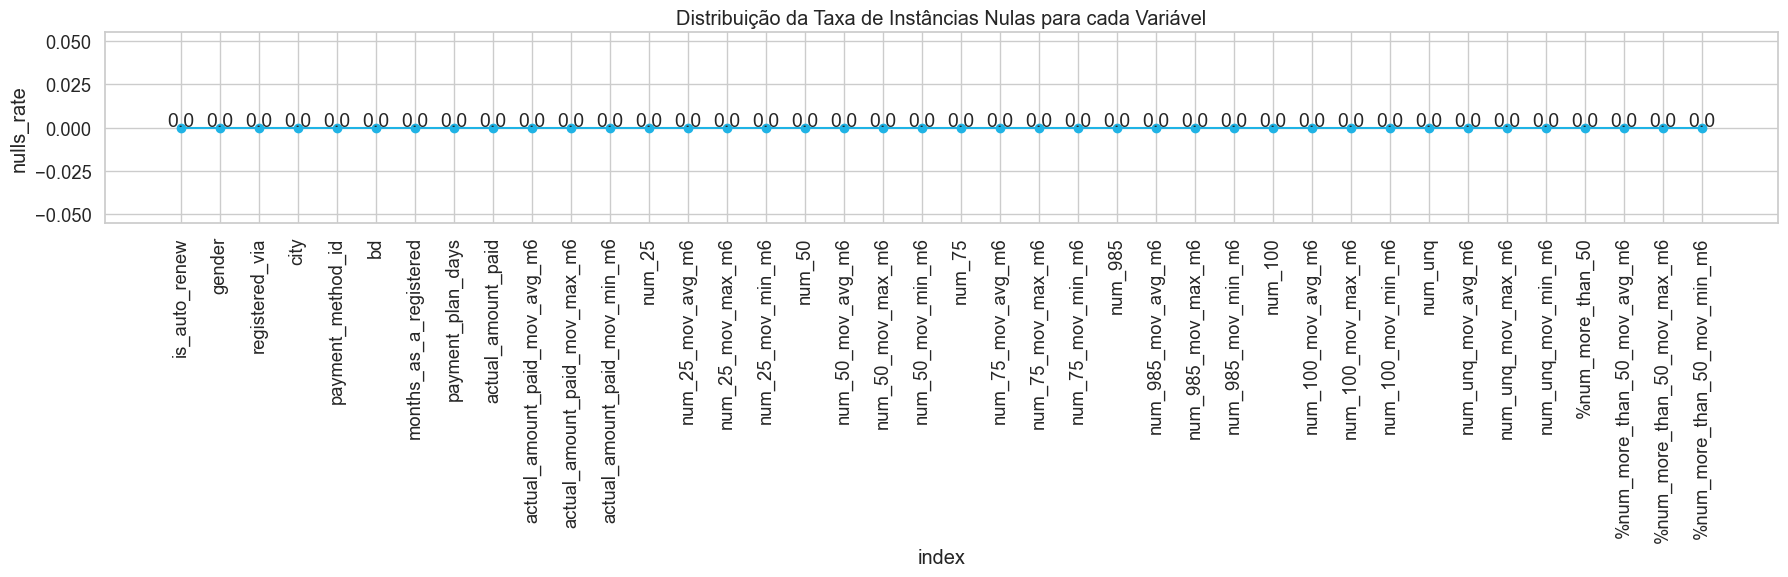

In [12]:
df_nulls = (
    pd.DataFrame(
        df_train
        .drop(["msno", "safra", "churn"], axis = 1)
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_train.shape[0])*100, 2)
plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 5.4) Encoder de Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. Muitos algoritmos não aceitam categorias durante o treinamento, portanto, temos de trocar as categorias por números. 

> 2. Sendo assim, a idéia é usar o WOE como Target Encoder, pois ele garante a mudança da categoria por um valor numérico que a represente corretamente, mantendo sua relação quanto a Target

> 3. Além disso, ele é capaz de reduzir a dimensionalidade quando comparado a outros Encoders, como o Binary ou o One Hot, por exemplo

In [13]:
def woe_training(df, feature):
    churn = df.dropna().loc[df.dropna()["churn"] == 1].groupby(feature, as_index = False)["churn"].count().rename({"churn":'churn'}, axis = 1)
    sem_churn = df.dropna().loc[df.dropna()["churn"] == 0].groupby(feature, as_index = False)["churn"].count().rename({"churn":'sem_churn'}, axis = 1)

    woe = churn.merge(sem_churn, on = feature, how = 'left')
    woe['percent_churn'] = woe['churn']/woe['churn'].sum()
    woe['percent_sem_churn'] = woe['sem_churn']/woe['sem_churn'].sum()
    woe['woe'] = round(np.log(woe['percent_churn']/woe['percent_sem_churn']), 3)
    woe = woe[[feature, "woe"]]
    woe.rename({f"{feature}":"variavel"}, axis = 1)
    woe.sort_values(by = "woe", ascending = True, inplace = True)
    woe.to_excel(f"../00_DataMaster/pre_processing/target_encoder_{feature}.xlsx", index = False)
    print(f"Excel com o WOE da variável {feature} Salvo!!")

In [14]:
def target_encoder_woe(df):

    woe_is_auto_renew = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_is_auto_renew.xlsx").set_index('is_auto_renew')['woe'].to_dict()
    woe_gender = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_gender.xlsx").set_index('gender')['woe'].to_dict()
    woe_registered_via = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_registered_via.xlsx").set_index('registered_via')['woe'].to_dict()
    woe_city = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_city.xlsx").set_index('city')['woe'].to_dict()
    woe_payment_method_id = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_payment_method_id.xlsx").set_index('payment_method_id')['woe'].to_dict()

    df["is_auto_renew"] = df['is_auto_renew'].map(woe_is_auto_renew)
    df["gender"] = df['gender'].map(woe_gender)
    df["registered_via"] = df['registered_via'].map(woe_registered_via).fillna(0) # CONTINGÊNCIA POIS UMA DAS CATEGORIAS TINHA 20 REGISTROS E NÃO TINHA CHURN, ENTÃO O WOE SERÁ 0 COMO CONTINGÊNCIA
    df["city"] = df['city'].map(woe_city)
    df["payment_method_id"] = df['payment_method_id'].map(woe_payment_method_id)

    return df

In [15]:
for categorica in variaveis_categoricas:
    woe_training(df_train, categorica)

df_train = target_encoder_woe(df_train)
print('Target Encoder concluído com sucesso!')

Excel com o WOE da variável is_auto_renew Salvo!!
Excel com o WOE da variável gender Salvo!!
Excel com o WOE da variável registered_via Salvo!!
Excel com o WOE da variável city Salvo!!
Excel com o WOE da variável payment_method_id Salvo!!
Target Encoder concluído com sucesso!


In [16]:
df_train.head()

churn                                          msno   safra  is_auto_renew  gender  registered_via  city  payment_method_id    bd  months_as_a_registered  payment_plan_days  actual_amount_paid  actual_amount_paid_mov_avg_m6  actual_amount_paid_mov_max_m6  actual_amount_paid_mov_min_m6  num_25  num_25_mov_avg_m6  num_25_mov_max_m6  num_25_mov_min_m6  num_50  num_50_mov_avg_m6  num_50_mov_max_m6  num_50_mov_min_m6  num_75  num_75_mov_avg_m6  num_75_mov_max_m6  num_75_mov_min_m6  num_985  num_985_mov_avg_m6  num_985_mov_max_m6  num_985_mov_min_m6  num_100  num_100_mov_avg_m6  num_100_mov_max_m6  num_100_mov_min_m6  num_unq  num_unq_mov_avg_m6  num_unq_mov_max_m6  num_unq_mov_min_m6  %num_more_than_50  %num_more_than_50_mov_avg_m6  %num_more_than_50_mov_max_m6  %num_more_than_50_mov_min_m6
0   0.00  31onXs2GF3sXT+Ay7ST5Mt3jHo5jSF3qPmGTC+XO3Hw=  201608          -1.07    0.27           -1.05  0.29              -1.38 46.00                   58.00              30.00              149.00                         149.00                         149.00                         149.00   66.00              75.00             137.00              25.00   19.00              21.33              39.00               7.00   12.00              13.33              24.00               4.00    13.00               13.67               25.00                4.00   368.00              397.17              657.00              156.00   410.00              437.67              708.00              185.00              80.67                         79.07                         89.11                         67.88
1   1.00  wMWkd29IVF5j0YwoVQzjtboYb6jfKczaJOuc0J+PzoM=  201603          -1.07   -0.37           -1.05 -0.33              -1.38 27.00                   12.00              30.00              149.00                         149.00                         149.00                         149.00   66.00              75.00             137.00              25.00   19.00              21.33              39.00               7.00   12.00              13.33              24.00               4.00    13.00               13.67               25.00                4.00   368.00              397.17              657.00              156.00   410.00              437.67              708.00              185.00              80.67                         79.07                         89.11                         67.88
2   1.00  wMWkd29IVF5j0YwoVQzjtboYb6jfKczaJOuc0J+PzoM=  201607          -1.07   -0.37           -1.05 -0.33              -1.38 27.00                   16.00              30.00              149.00                         149.00                         149.00                         149.00   66.00              75.00             137.00              25.00   19.00              21.33              39.00               7.00   12.00              13.33              24.00               4.00    13.00               13.67               25.00                4.00   368.00              397.17              657.00              156.00   410.00              437.67              708.00              185.00              80.67                         79.07                         89.11                         67.88
3   1.00  wMWkd29IVF5j0YwoVQzjtboYb6jfKczaJOuc0J+PzoM=  201608          -1.07   -0.37           -1.05 -0.33              -1.38 27.00                   17.00              30.00              149.00                         149.00                         149.00                         149.00   66.00              75.00             137.00              25.00   19.00              21.33              39.00               7.00   12.00              13.33              24.00               4.00    13.00               13.67               25.00                4.00   368.00              397.17              657.00              156.00   410.00              437.67              708.00              185.00              80.67                         79.07                         89.11                         67.88
4  

<font color='red' style='font-size: 40px;'> 6)  Feature Selection </font>
<hr style='border: 2px solid red;'>

In [17]:
######################### FEATURE ENGINEERING #####################################################
def months_as_a_registered(df):

    df["registration_init_time"] = df["registration_init_time"].apply(lambda x:str(x)[:6])

    # Converter as colunas para objetos datetime
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m')
    df['safra'] = pd.to_datetime(df['safra'], format='%Y%m')

    # Calcular a diferença de meses
    df['months_as_a_registered'] = (df['safra'].dt.year - df['registration_init_time'].dt.year) * 12 + (df['safra'].dt.month - df['registration_init_time'].dt.month)
    df["safra"] = df["safra"].apply(lambda x:str(x)[:7].replace("-", ""))

    return df['months_as_a_registered']

def num_more_than_50(df):

    df["num_less_than_50"] = df["num_25"] + df["num_50"]
    df["num_more_than_50"] = df["num_75"] + df["num_985"] + df["num_100"]
    df["%num_more_than_50"] = round(df["num_more_than_50"]/(df["num_more_than_50"]+df["num_less_than_50"])*100, 2)

    return df["%num_more_than_50"]

def agrupa_categorias_cidade_pelo_woe(df):

    df['city'] = (
                np.where(df['city'].isin(['13', '14', '16', '7', '20']), 0, 
                np.where(df['city'].isin(['17', '4', '5', '18']), 1, 
                np.where(df['city'].isin(['19', '3', '15', '10']), 2, 
                np.where(df['city'].isin(['12', '11', '6', '22']), 3, 
                np.where(df['city'].isin(['8', '21', '9', '1']), 4, 
                np.nan)))))
    )

    return df['city']

def agrupa_categorias_metodo_pagamento_pelo_woe(df):

    df['payment_method_id'] = (
                np.where(df['payment_method_id'].isin(['32', '14', '10', '19', '31']), 0, 
                np.where(df['payment_method_id'].isin(['34', '41', '18', '37', '21']), 1, 
                np.where(df['payment_method_id'].isin(['23', '33', '39', '27']), 2, 
                np.where(df['payment_method_id'].isin(['40', '30', '16', '36', '26']), 3, 
                np.where(df['payment_method_id'].isin(['38', '29', '28', '35', '17']), 4, 
                np.nan)))))
    )

    return df['payment_method_id']

def get_temporal_features(df):

    tabela_de_transacoes_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet")
    tabela_user_logs_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet")

    tabela_de_transacoes_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet")
    tabela_user_logs_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet")

    tabela_de_transacoes_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet")
    tabela_user_logs_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet")

    df = df.merge(tabela_de_transacoes_media_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_media_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_max_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_max_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_min_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_min_movel, on = ["msno", "safra"], how = "left")

    return df

######################### PRÉ-PROCESSAMENTO #####################################################

def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]

def pre_processamento_categoricas_nulas(df):
    variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']

    def aplica_tratamento_categorica_nulas(df, feature):
        df[feature] = np.where(df[feature].isnull(), 999, df[feature])
        return df[feature]

    for categorica in variaveis_categoricas:
        df[categorica] = aplica_tratamento_categorica_nulas(df, categorica)

    return df

def pre_processamento_continuas_nulas(df, calcula_mediana=False):
    variaveis_continuas = [
        'bd',
        'months_as_a_registered',
        'payment_plan_days', 
        'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6', 
        'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
        'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
        'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
        'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
        'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
        'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
        '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
    ]

    def calcular_e_salvar_mediana_por_cidade(df):
        variaveis_continuas = [
            'bd',
            'months_as_a_registered',
            'payment_plan_days', 
            'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
            'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
            'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
            'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
            'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
            'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
            'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
            '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
        ]
        
        cidades = df['city'].unique()
        for cidade in cidades:
            mediana_df = df[df['city'] == cidade][variaveis_continuas].median().reset_index()
            mediana_df.columns = ['variavel', 'mediana']
            mediana_df.to_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx", index=False)

    if calcula_mediana:
        calcular_e_salvar_mediana_por_cidade(df)
        print(f'Salvando a Mediana com dados de treinamento...')

    for cidade in df['city'].unique():
        mediana_dict = pd.read_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx").set_index('variavel')['mediana'].to_dict()
        for feature in variaveis_continuas:
            percentis = df[feature].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1 = percentis['1%']
            p99 = percentis['99%']
            df[feature] = np.where((df[feature].isnull() | (df[feature] <= p1) | (df[feature] >= p99)), mediana_dict[feature], df[feature])
            
        return df


def target_encoder_woe(df):

    woe_is_auto_renew = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_is_auto_renew.xlsx").set_index('is_auto_renew')['woe'].to_dict()
    woe_gender = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_gender.xlsx").set_index('gender')['woe'].to_dict()
    woe_registered_via = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_registered_via.xlsx").set_index('registered_via')['woe'].to_dict()
    woe_city = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_city.xlsx").set_index('city')['woe'].to_dict()
    woe_payment_method_id = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_payment_method_id.xlsx").set_index('payment_method_id')['woe'].to_dict()

    df["is_auto_renew"] = df['is_auto_renew'].map(woe_is_auto_renew)
    df["gender"] = df['gender'].map(woe_gender)
    df["registered_via"] = df['registered_via'].map(woe_registered_via).fillna(0) # CONTINGÊNCIA POIS UMA DAS CATEGORIAS TINHA 20 REGISTROS E NÃO TINHA CHURN, ENTÃO O WOE SERÁ 0 COMO CONTINGÊNCIA
    df["city"] = df['city'].map(woe_city)
    df["payment_method_id"] = df['payment_method_id'].map(woe_payment_method_id)

    return df


# <font color='green' style='font-size: 30px;'> 6.1) Leitura de todos os dados</font>
<hr style='border: 2px solid green;'>

> 1. O primeiro passo é excluir variáveis que não entrarão no modelo. A variável que sofrerá exclusão inicial é a "gender", pois ela apresentava quase 50% dos dados nulos. A necessidade de imputação de 50% dos valores é um risco muito alto, portanto, decidiu-se retirá-la do treinamento

> 2. Viu-se pela análise exploratória que a variável "plan_list_price" era praticamente idêntica à "actual_amount_paid", bem como a "num_unq" era extremamente correlacionada com a "total_secs". Dessa forma, optou-se por remover previamente todas as variáveis que dizem respeito a "plan_list_price" e "total_secs"

> 3. Finalmente, optou-se por manter as variáveis com sufixo "m6" e excluir as que não poussíam, pois elas trazem consigo informações mais consistes dado que são criadas com informações de 6 meses

In [18]:
### Puxando informações de Treino

df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")

colunas_ordenadas = [
    "msno", "churn", "safra", 
    'is_auto_renew', 'is_cancel', 'gender', 'registered_via', 'city', 'payment_method_id', 
    'payment_plan_days', 'plan_list_price','actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
    "registration_init_time", "transaction_date", "membership_expire_date"
] 

df_train = df_train[colunas_ordenadas]

# Aplicando Feature Engineering
df_train['months_as_a_registered'] = months_as_a_registered(df_train)
df_train['%num_more_than_50'] = num_more_than_50(df_train)
df_train['city'] = agrupa_categorias_cidade_pelo_woe(df_train)
df_train['payment_method_id'] = agrupa_categorias_metodo_pagamento_pelo_woe(df_train)
df_train = get_temporal_features(df_train)

# Aplicando Pré-Processamento
df_train["is_auto_renew"] = muda_tipagem_variavel(df_train, "is_auto_renew", "int")
df_train["bd"] = muda_tipagem_variavel(df_train, "bd", "int")
df_train["registered_via"] = muda_tipagem_variavel(df_train, "registered_via", "int")
df_train["payment_plan_days"] = muda_tipagem_variavel(df_train, "payment_plan_days", "float")
df_train["actual_amount_paid"] = muda_tipagem_variavel(df_train, "actual_amount_paid", "float")

df_train = pre_processamento_categoricas_nulas(df_train)
df_train = pre_processamento_continuas_nulas(df_train)

df_train = target_encoder_woe(df_train)

# # Organizando

variaveis_categoricas = ['is_auto_renew', 'registered_via', 'city', 'payment_method_id']

variaveis_continuas = [
        'bd',
        'months_as_a_registered',
        'payment_plan_days', 
        'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
        'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
        'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
        'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
        'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
        'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
        'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
        '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
]

safra = ["safra"]
target = ["churn"]
user_id = ["msno"]

df_train = df_train[target + user_id + safra + variaveis_categoricas + variaveis_continuas]

# <font color='green' style='font-size: 30px;'> 6.2) Random Forest Feature Importance + Análise de Correlação </font>
<hr style='border: 2px solid green;'>

> 1. Inicialmente, utilizou-se uma Random Forest Feature Importance para selecionar as variáveis mais importantes. A "feature importance" (importância das características) é uma medida que avalia o grau de contribuição de cada variável de entrada na capacidade preditiva de um modelo de árvore. Ela fornece uma pontuação ou ranking que indica a relevância relativa de cada variável, atribuindo os melhores scores para as features que mais contribuem para a redução da função de custo

> 2. Além disso, a Random Forest é um modelo Ensemble que baseia-se no Bagging, ou seja, é um modelo robusto ao overfitting 

> 3. A Random Forest foi treinada de maneira simples, justamente para que seja capaz de nos informas as melhores variáveis. Em relação ao class weight escolhido:

- Representatividade dos Dados: Usar a proporção dos dados como ponto de partida é uma abordagem racional, pois diretamente reflete a distribuição real das classes no conjunto de dados. Ajustar o modelo para considerar essa distribuição ajuda a garantir que o modelo esteja melhor preparado para capturar a variabilidade da classe minoritária.

- Base Sólida para Otimização: Começar com a proporção dos dados fornece uma base sólida para o otimizador. Esse ponto de partida é um reflexo justo e realista do desbalanceamento, permitindo que o otimizador faça ajustes incrementais mais precisos e eficazes a partir daí.

> 4. Finalmente, optou-se por remover variáveis altamente correlacionadas (0.9+), mantendo a com maior feature importance dentre elas


In [19]:
def analisa_correlacao(metodo, df):
    plt.figure(figsize=(30, 15))
    mask = np.triu(np.ones_like(df.corr(method=metodo), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=metodo), vmin=-1, vmax=1, cmap='magma', annot=True, fmt='.1f', cbar_kws={"shrink": .8}, mask=mask)
    heatmap.set_title(f"Analisando Correlação de {metodo}")
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    plt.grid(False)
    plt.show()


In [20]:
def aplica_feature_selection(df):
    def separa_feature_target(target, dados):
        x = dados.drop(target, axis = 1)
        y = dados[[target]]

        return x, y

    def remove_features_feature_importance(target, df, class_weight, threshold):
        # Separa entre Features e Target
        x, y = separa_feature_target(target, df)
        
        # Criar o modelo de Random Forest
        model = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=20, class_weight={0:1, 1:class_weight})
        
        # Treinar o modelo
        model.fit(x, y)
        
        # Obter as importâncias das features
        feature_importances = model.feature_importances_
        
        # Selecionar as features com importância maior que zero
        selected_features = list(x.columns[feature_importances > threshold])
        selected_features.append(target)
        
        feature_importance_df = pd.DataFrame({
            'feature': x.columns,
            'importance': feature_importances
        }).sort_values(by='importance', ascending=False)
        feature_importance_df = feature_importance_df.loc[feature_importance_df['importance'] > 0]
        feature_importance_df['importance'] = feature_importance_df['importance'] * 100
        
        return selected_features, feature_importance_df

    def remove_features_altamente_correlacionadas(df, variaveis_importantes_df, threshold_correlacao=0.9):
        # Filtrar variáveis com alta importância
        alta_importancia_features = variaveis_importantes_df['feature'].tolist()
        
        # Selecionar as colunas do DataFrame com as variáveis de interesse
        df_reduzido = df[alta_importancia_features]
        
        # Calcular a matriz de correlação de Spearman
        correlacoes = df_reduzido.corr(method='spearman')
        
        # Encontrar variáveis altamente correlacionadas
        alta_correlacao = np.abs(correlacoes) > threshold_correlacao
        features_para_remover = set()
        
        for i in range(len(alta_correlacao.columns)):
            for j in range(i):
                if alta_correlacao.iloc[i, j] and correlacoes.columns[j] not in features_para_remover:
                    features_para_remover.add(correlacoes.columns[i])
        
        variaveis_filtradas = [col for col in alta_importancia_features if col not in features_para_remover]
        
        return variaveis_filtradas

    # Aplicando Random Forest e selecionado feature com importância > 0
    features, feature_importances = remove_features_feature_importance('churn', df.drop(['msno', 'safra'], axis=1).copy(), 5, 0)
    feature_importances = feature_importances.loc[feature_importances['importance'] > 0]
    
    # Filtrar variáveis altamente correlacionadas e mantendo a que possui maior importância com a target dentre as correlacionadas
    variaveis_selecionadas = remove_features_altamente_correlacionadas(df, feature_importances)
    feature_importances_final = feature_importances[feature_importances['feature'].isin(variaveis_selecionadas)]

    return feature_importances_final



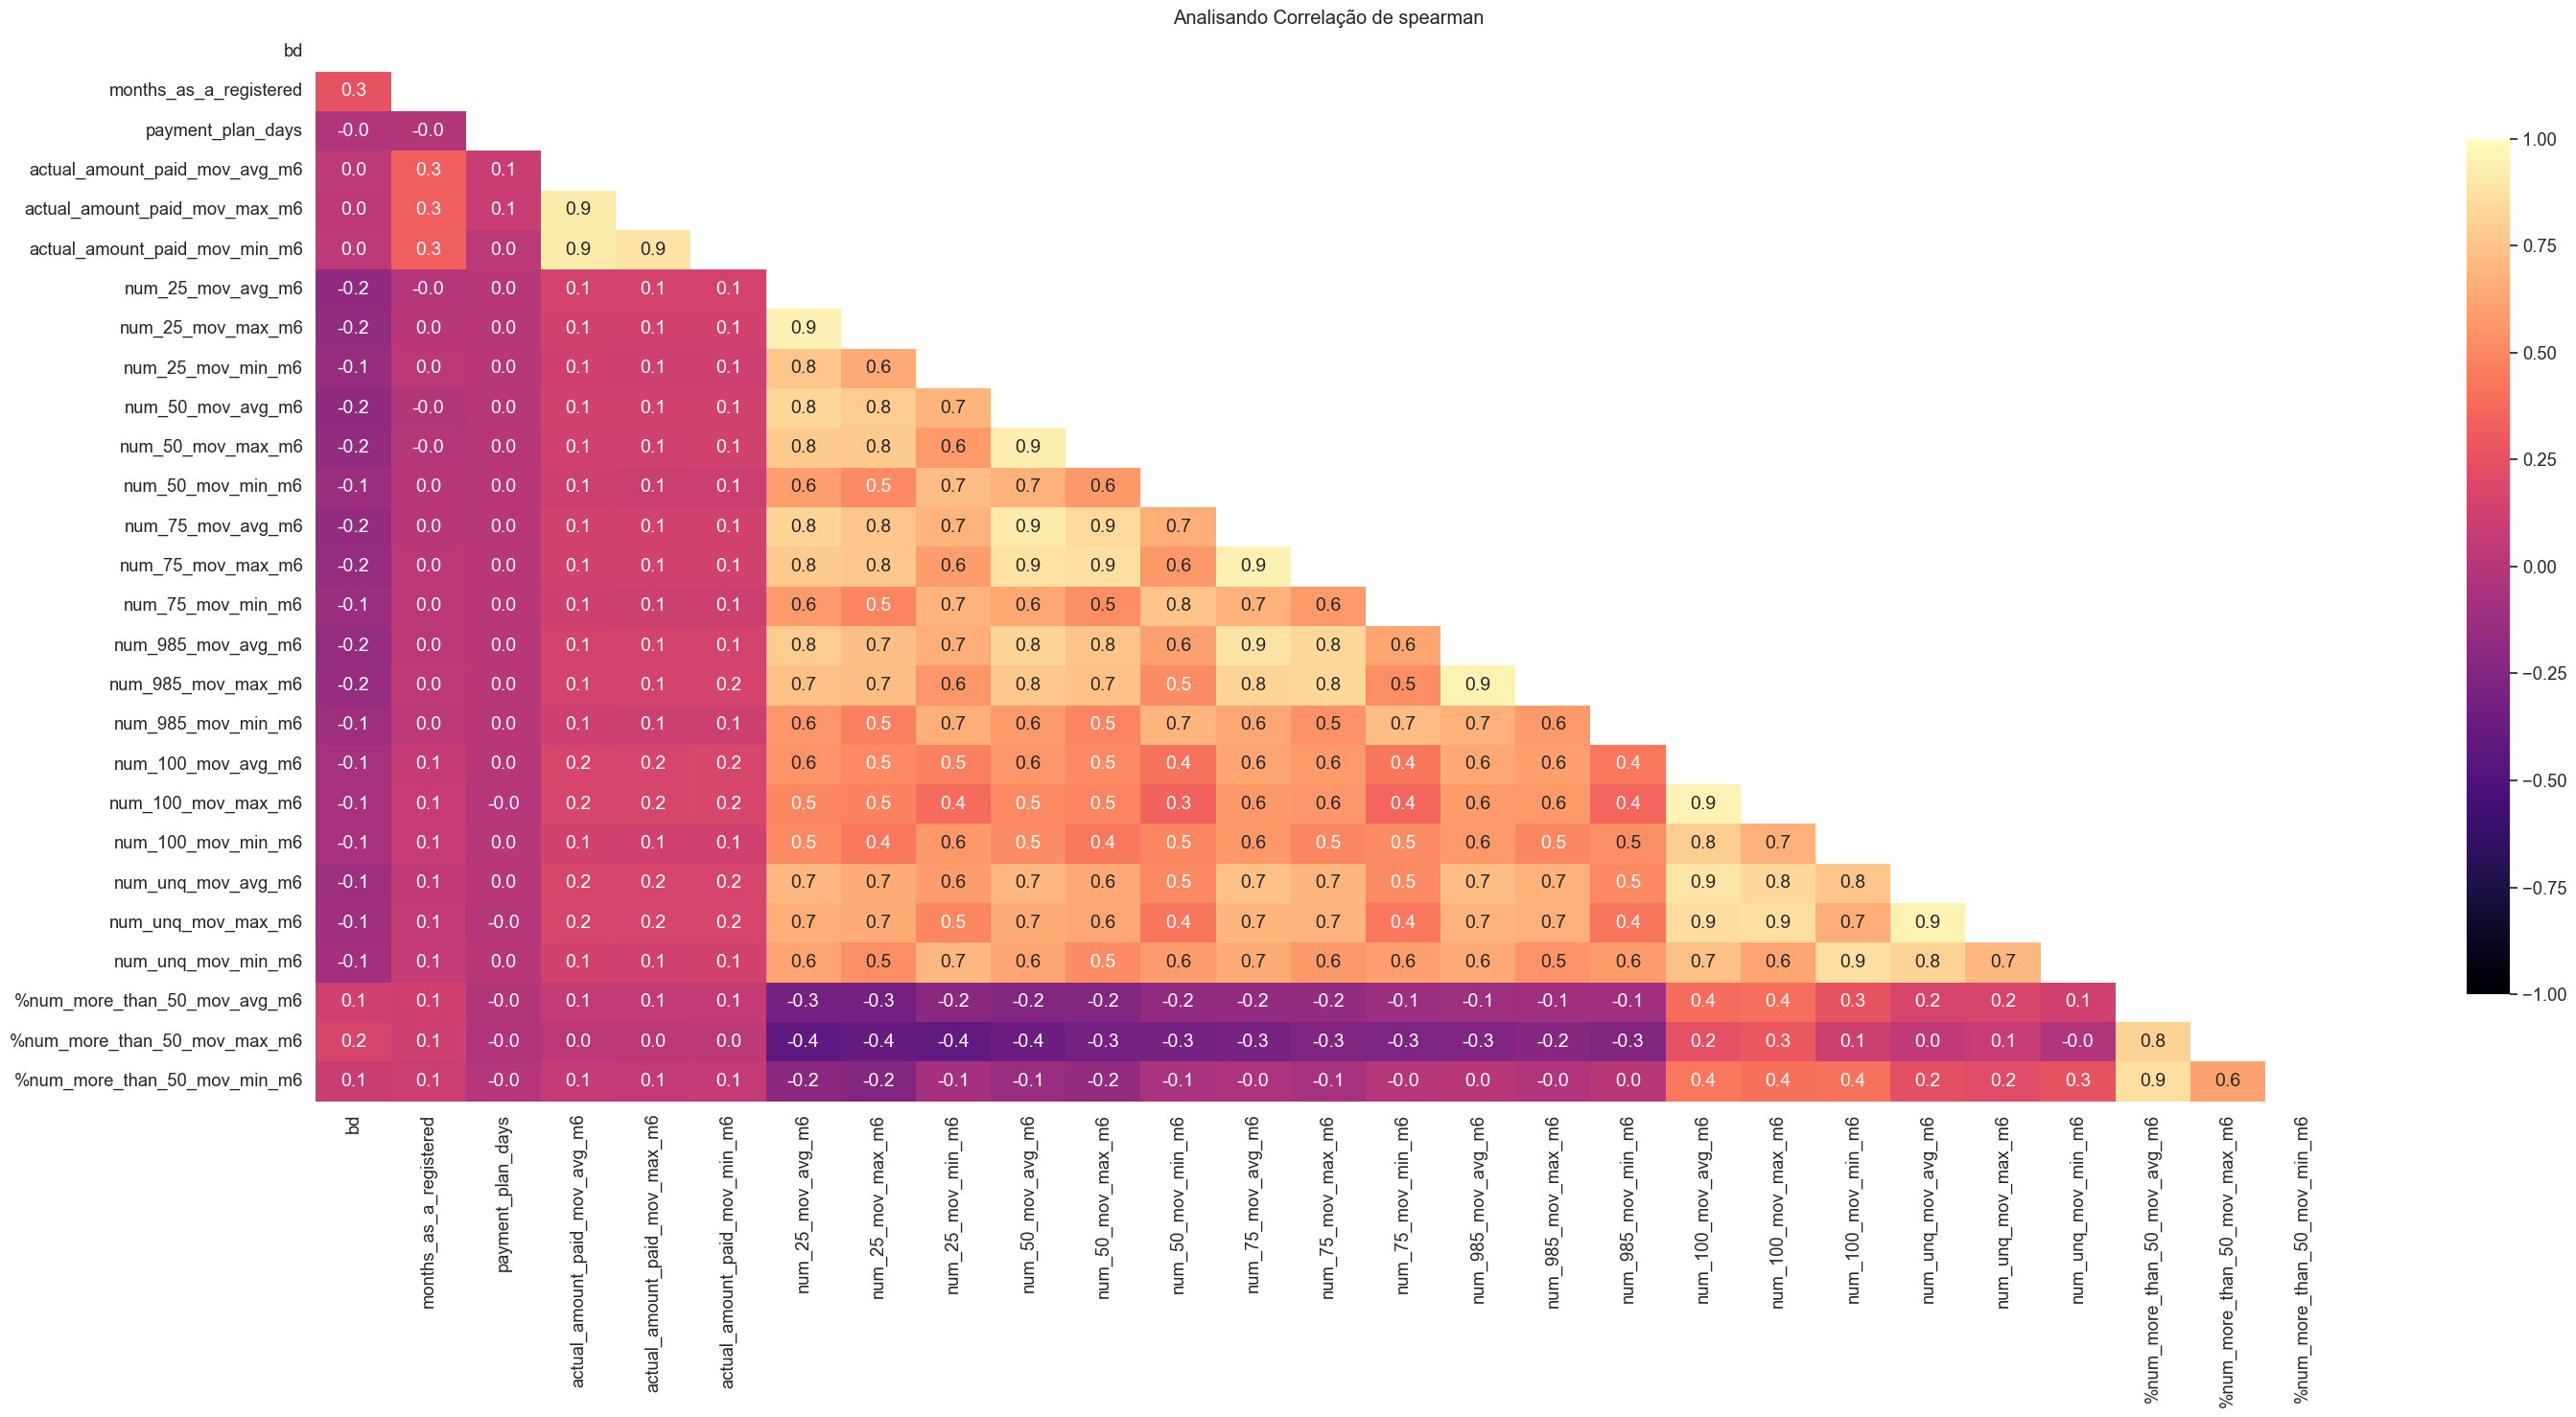

In [21]:
df_eda_continuas = df_train[variaveis_continuas].copy()
for col in df_eda_continuas[variaveis_continuas]:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x:float(x))
analisa_correlacao("spearman", df_eda_continuas[variaveis_continuas])

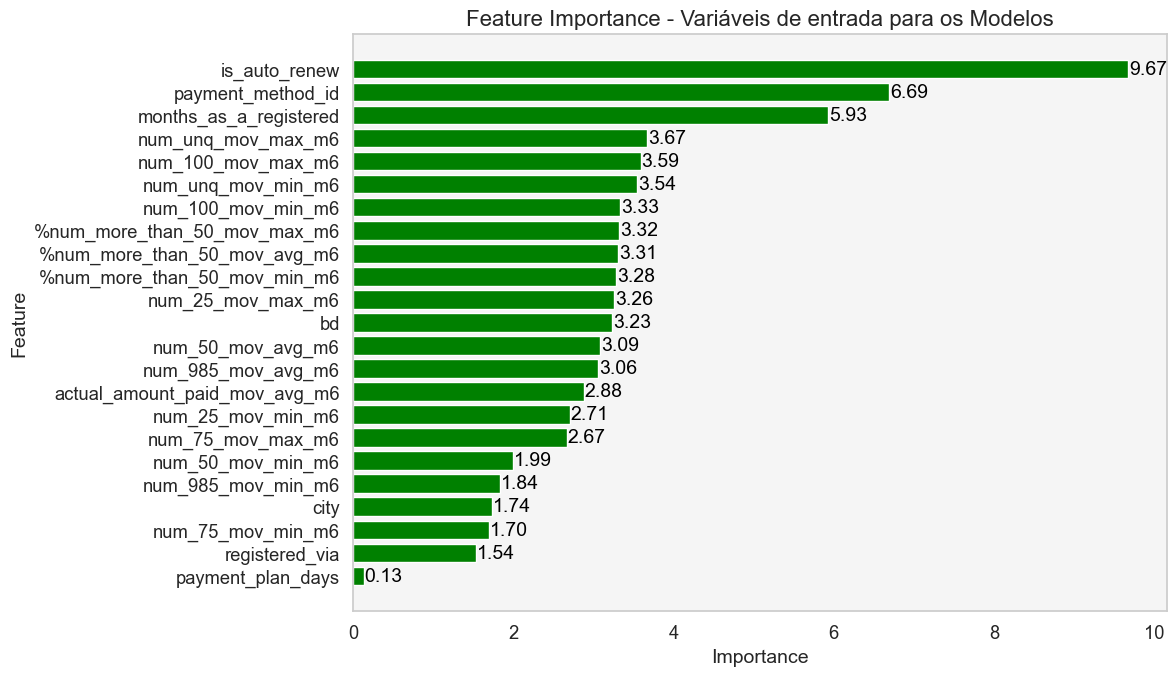

In [22]:
# Seleciona Variaveis Finais que passaram pela Feature Importance + Análise de Correlação
variaveis_finais = aplica_feature_selection(df_train)

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.2)

bars = plt.barh(variaveis_finais['feature'], variaveis_finais['importance'], color='green')
plt.title("Feature Importance - Variáveis de entrada para os Modelos", fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)


plt.tight_layout()
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.gca().invert_yaxis()
plt.show()


<font color='red' style='font-size: 40px;'> 7)  Modelagem (Foco em Aprendizado Supervisionado) </font>
<hr style='border: 2px solid red;'>

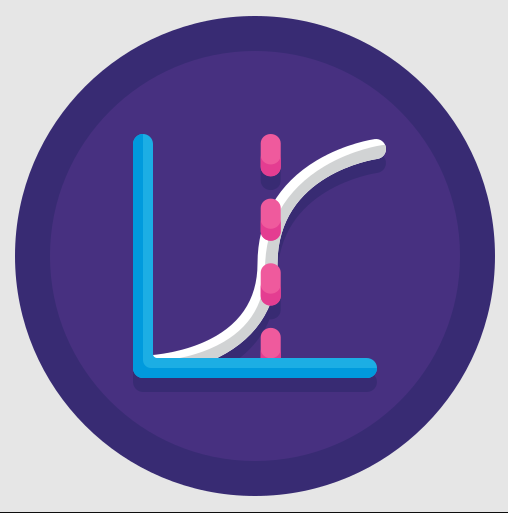

In [181]:
######################### FEATURE ENGINEERING #####################################################
def months_as_a_registered(df):

    df["registration_init_time"] = df["registration_init_time"].apply(lambda x:str(x)[:6])

    # Converter as colunas para objetos datetime
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m')
    df['safra'] = pd.to_datetime(df['safra'], format='%Y%m')

    # Calcular a diferença de meses
    df['months_as_a_registered'] = (df['safra'].dt.year - df['registration_init_time'].dt.year) * 12 + (df['safra'].dt.month - df['registration_init_time'].dt.month)
    df["safra"] = df["safra"].apply(lambda x:str(x)[:7].replace("-", ""))

    return df['months_as_a_registered']

def num_more_than_50(df):

    df["num_less_than_50"] = df["num_25"] + df["num_50"]
    df["num_more_than_50"] = df["num_75"] + df["num_985"] + df["num_100"]
    df["%num_more_than_50"] = round(df["num_more_than_50"]/(df["num_more_than_50"]+df["num_less_than_50"])*100, 2)

    return df["%num_more_than_50"]

def agrupa_categorias_cidade_pelo_woe(df):

    df['city'] = (
                np.where(df['city'].isin(['13', '14', '16', '7', '20']), 0, 
                np.where(df['city'].isin(['17', '4', '5', '18']), 1, 
                np.where(df['city'].isin(['19', '3', '15', '10']), 2, 
                np.where(df['city'].isin(['12', '11', '6', '22']), 3, 
                np.where(df['city'].isin(['8', '21', '9', '1']), 4, 
                np.nan)))))
    )

    return df['city']

def agrupa_categorias_metodo_pagamento_pelo_woe(df):

    df['payment_method_id'] = (
                np.where(df['payment_method_id'].isin(['32', '14', '10', '19', '31']), 0, 
                np.where(df['payment_method_id'].isin(['34', '41', '18', '37', '21']), 1, 
                np.where(df['payment_method_id'].isin(['23', '33', '39', '27']), 2, 
                np.where(df['payment_method_id'].isin(['40', '30', '16', '36', '26']), 3, 
                np.where(df['payment_method_id'].isin(['38', '29', '28', '35', '17']), 4, 
                np.nan)))))
    )

    return df['payment_method_id']

def get_temporal_features(df):

    tabela_de_transacoes_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet")
    tabela_user_logs_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet")

    tabela_de_transacoes_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet")
    tabela_user_logs_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet")

    tabela_de_transacoes_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet")
    tabela_user_logs_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet")

    df = df.merge(tabela_de_transacoes_media_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_media_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_max_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_max_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_min_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_min_movel, on = ["msno", "safra"], how = "left")

    return df

######################### PRÉ-PROCESSAMENTO #####################################################

def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]

def pre_processamento_categoricas_nulas(df):
    variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']

    def aplica_tratamento_categorica_nulas(df, feature):
        df[feature] = np.where(df[feature].isnull(), 999, df[feature])
        return df[feature]

    for categorica in variaveis_categoricas:
        df[categorica] = aplica_tratamento_categorica_nulas(df, categorica)

    return df

def pre_processamento_continuas_nulas(df, calcula_mediana=False):
    variaveis_continuas = [
        'bd',
        'months_as_a_registered',
        'payment_plan_days', 
        'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6', 
        'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
        'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
        'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
        'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
        'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
        'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
        '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
    ]

    def calcular_e_salvar_mediana_por_cidade(df):
        variaveis_continuas = [
            'bd',
            'months_as_a_registered',
            'payment_plan_days', 
            'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
            'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
            'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
            'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
            'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
            'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
            'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
            '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
        ]
        
        cidades = df['city'].unique()
        for cidade in cidades:
            mediana_df = df[df['city'] == cidade][variaveis_continuas].median().reset_index()
            mediana_df.columns = ['variavel', 'mediana']
            mediana_df.to_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx", index=False)

    if calcula_mediana:
        calcular_e_salvar_mediana_por_cidade(df)
        print(f'Salvando a Mediana com dados de treinamento...')

    for cidade in df['city'].unique():
        mediana_dict = pd.read_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx").set_index('variavel')['mediana'].to_dict()
        for feature in variaveis_continuas:
            percentis = df[feature].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1 = percentis['1%']
            p99 = percentis['99%']
            df[feature] = np.where((df[feature].isnull() | (df[feature] <= p1) | (df[feature] >= p99)), mediana_dict[feature], df[feature])
            
        return df


def target_encoder_woe(df):

    woe_is_auto_renew = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_is_auto_renew.xlsx").set_index('is_auto_renew')['woe'].to_dict()
    woe_gender = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_gender.xlsx").set_index('gender')['woe'].to_dict()
    woe_registered_via = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_registered_via.xlsx").set_index('registered_via')['woe'].to_dict()
    woe_city = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_city.xlsx").set_index('city')['woe'].to_dict()
    woe_payment_method_id = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_payment_method_id.xlsx").set_index('payment_method_id')['woe'].to_dict()

    df["is_auto_renew"] = df['is_auto_renew'].map(woe_is_auto_renew)
    df["gender"] = df['gender'].map(woe_gender)
    df["registered_via"] = df['registered_via'].map(woe_registered_via).fillna(0) # CONTINGÊNCIA POIS UMA DAS CATEGORIAS TINHA 20 REGISTROS E NÃO TINHA CHURN, ENTÃO O WOE SERÁ 0 COMO CONTINGÊNCIA
    df["city"] = df['city'].map(woe_city)
    df["payment_method_id"] = df['payment_method_id'].map(woe_payment_method_id)

    return df


# <font color='green' style='font-size: 30px;'> 7.0) Função de Custo </font>
<hr style='border: 2px solid green;'>


> 1. O desafio proposto pode ser traduzido como um problema de otimização de receita. Sendo assim, podemos definir o custo dos acertos e erros do modelo proposto


# $$ \begin{bmatrix} VN & FP \\ FN & VP \end{bmatrix} \begin{bmatrix} 0 & -3_{meses}*(Assinatura) \\ 0 & \frac{12_{meses}(Assinatura)-3_{meses}*(Assinatura)}{2}\end{bmatrix}$$

- RETORNO VN: 0
- CUSTO FN: Deixa de aplicar a ação e perde o cliente, mas não tem custo 0
- CUSTO FP: Aplica a ação incorretamente e deixa de receber o pagamento de clientes que não sairíam por 3 meses
- RETORNO VN: Aplica a ação corretamente, evitando a perda de receita nos dois cenários acima

> 2. Dessa forma, sabe-se que:

- É de suma importância diminuir a taxa tanto dos os FP, bem como aumentar a taxa de VP
- Sendo assim, conclui-se que a métrica mais importante é o AUC
- A Curva ROC representa a Taxa de Verdadeiros Positivos (o verdadeiro churn) vs Taxa de Falsos Positivos (quem não é churn mas foi marcado como churn). Sob ela, existe a AUC, a qual reflete o quão bem o modelo classifica ambas classes (0 e 1) em relação a diversos thresholds, portanto, quanto maior ela for, maior é a taxa de VP e menor a taxa de FP.



# <font color='green' style='font-size: 30px;'> 7.1) Leitura de todos os dados </font>
<hr style='border: 2px solid green;'>

In [182]:
### Puxando informações de Treino + Validação + Teste + OOT

df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")
df_valid = pd.read_parquet("../00_DataMaster/data/df_valid.parquet")
df_test = pd.read_parquet("../00_DataMaster/data/df_test.parquet")
df_oot = pd.read_parquet("../00_DataMaster/data/df_oot.parquet")

# <font color='green' style='font-size: 30px;'> 7.2) Feature Engineering + Pré-Processamento + Feature Selection</font>
<hr style='border: 2px solid green;'>

In [183]:
def aplica_pre_processamento_feature_eng_feature_selection(df):

    # Aplicando Feature Engineering
    df['months_as_a_registered'] = months_as_a_registered(df)
    df['%num_more_than_50'] = num_more_than_50(df)
    df['city'] = agrupa_categorias_cidade_pelo_woe(df)
    df['payment_method_id'] = agrupa_categorias_metodo_pagamento_pelo_woe(df)
    df = get_temporal_features(df)

    # Aplicando Pré-Processamento
    df["is_auto_renew"] = muda_tipagem_variavel(df, "is_auto_renew", "int")
    df["bd"] = muda_tipagem_variavel(df, "bd", "int")
    df["registered_via"] = muda_tipagem_variavel(df, "registered_via", "int")
    df["payment_plan_days"] = muda_tipagem_variavel(df, "payment_plan_days", "float")
    df["actual_amount_paid"] = muda_tipagem_variavel(df, "actual_amount_paid", "float")

    df = pre_processamento_categoricas_nulas(df)
    df = pre_processamento_continuas_nulas(df)

    df = target_encoder_woe(df)

    # Organizando
    variaveis_selecionadas =  [
       'is_auto_renew', 'payment_method_id', 'months_as_a_registered',
       'num_unq_mov_max_m6', 'num_100_mov_max_m6', 'num_unq_mov_min_m6',
       'num_100_mov_min_m6', '%num_more_than_50_mov_max_m6',
       '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_min_m6',
       'num_25_mov_max_m6', 'bd', 'num_50_mov_avg_m6',
       'num_985_mov_avg_m6', 'actual_amount_paid_mov_avg_m6',
       'num_25_mov_min_m6', 'num_75_mov_max_m6', 'num_50_mov_min_m6',
       'num_985_mov_min_m6', 'city', 'num_75_mov_min_m6',
       'registered_via', 'payment_plan_days'
        ]
    mensalidade = ['actual_amount_paid']
    safra = ["safra"]
    target = ["churn"]
    user_id = ["msno"]

    df = df[target + user_id + safra + mensalidade + variaveis_selecionadas]

    return df

In [184]:
df_train = aplica_pre_processamento_feature_eng_feature_selection(df_train)
df_valid = aplica_pre_processamento_feature_eng_feature_selection(df_valid)
df_test = aplica_pre_processamento_feature_eng_feature_selection(df_test)
df_oot = aplica_pre_processamento_feature_eng_feature_selection(df_oot)

# <font color='green' style='font-size: 30px;'> 7.3) Treinamento dos Modelos </font>
<hr style='border: 2px solid green;'>

> 1. Para a parte de modelagem, escolheu-se três modelos: Regressão Logística, Random Forest e XGBoost:

- A Regressão Logística foi escolhida por ser um modelo estável e muito tradicional, com boa capacidade de interpretababilidade 

- A Random Forest é um ensemble o qual utiliza Bagging, portanto, ela reduz expressivamente a variância e previne problemas como Overfitting. 

- O XGBoost é um ensemble de Boosting, logo, possui alto poder preditivo, permitindo que as previsões sejam muito precisas. 


> 2. Realizou-se a consolidação das Métricas de Treino, Teste e Validação Cruzada para cada um dos Modelos: 

- As métricas são consistentes e têm bom desempenho em todos os conjuntos, portanto, isso sugere que o modelo está generalizando bem para dados não vistos e ele é estável, provando que não está superajustado (overfitting).

- Pelos resultados expressos, viu-se que o modelo com melhor performance foi o XGBoost, portanto, ele será levado para a etapa de otimização

In [185]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y

In [186]:
def train_min_max_scaler(df):

    cols = list(df.drop(['churn', 'msno', 'safra', 'actual_amount_paid'], axis = 1).columns)

    df_scaler = df[cols].copy()

    scaler = MinMaxScaler()
    scaler.fit(df_scaler)
    joblib.dump(scaler, "../00_DataMaster/models/scaler.pkl")
    print('Scaler Treinado e Salvo com sucesso!')

In [187]:
def Classificador(classificador, x_train, y_train, x_test, y_test, class_weight):

    # Puxa o Scaler Treinado com os dados de Treino
    scaler = joblib.load("../00_DataMaster/models/scaler.pkl")
    
    cols = list(x_train.drop(['msno', 'safra', 'actual_amount_paid'], axis = 1).columns)

    x_train = x_train[cols]
    x_test = x_test[cols]

    # Define as colunas categóricas e numéricas
    models = {
        'Regressão Logística': make_pipeline(
            ColumnTransformer([
                ('scaler', make_pipeline(scaler), cols)
            ]),
            LogisticRegression(
                random_state=42, # Semente aleatória para reproducibilidade dos resultados
                class_weight={0: 1, 1: class_weight}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
                C=1, # Parâmetro de regularização inversa. Controla a força da regularização.
                penalty='l2', # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
                max_iter=50, # Número máximo de iterações para a convergência do otimizador.
                solver='liblinear' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
                )
        ),
        'Random Forest': make_pipeline(
        RandomForestClassifier(
            random_state=42,            # Semente aleatória para reproducibilidade dos resultados
            criterion='entropy',       # Critério usado para medir a qualidade de uma divisão
            n_estimators=50,           # Número de árvores na floresta (equivalente ao n_estimators no XGBoost)
            max_depth = 6,                # Profundidade máxima de cada árvore
            class_weight={0:1, 1:class_weight},  # Peso das classes em casos desequilibrados
            bootstrap=True               # Se deve ou não amostrar com substituição ao construir árvores
            )
        ),
        'XGBoost': make_pipeline(
        XGBClassifier(
            random_state=42,            # Semente aleatória para reproducibilidade dos resultados
            tree_method = 'gpu_hist',
            n_estimators=50,           # Número de árvores no modelo (equivalente ao n_estimators na Random Forest)
            max_depth = 4,                # Profundidade máxima de cada árvore
            learning_rate = 0.01,         # Taxa de aprendizado - controla a contribuição de cada árvore
            eval_metric='logloss',      # Métrica de avaliação durante o treinamento, 'logloss' é comum para problemas de classificação binária
            objective='binary:logistic',# Define o objetivo do modelo, 'binary:logistic' para classificação binária
            scale_pos_weight=class_weight,  # Peso das classes positivas em casos desequilibrados
            reg_alpha=1,                # Termo de regularização L1 (penalidade nos pesos)
            reg_lambda=1,               # Termo de regularização L2 (penalidade nos quadrados dos pesos)
            gamma=1,                    # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
            colsample_bytree=0.5,       # Fração de características a serem consideradas ao construir cada árvore --> 0.5 significa que 50% das features (seleção aleatória) será considerada
            subsample=0.5,              # Fração de amostras a serem usadas para treinar cada árvore --> 0.5 significa que 50% da amostra de treino (seleção aleatória) será considerada
            )
        )
    }

    if classificador in models:
        model = models[classificador]
    else:
        print('Utilize Regressão Logística, Random Forest ou XGBoost como opções de Classificadores!')

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    return model, y_pred_train, y_pred_test, y_proba_train, y_proba_test

In [188]:
def validacao_cruzada_classificacao(classificador, df, target_column, n_splits, class_weight):

    columns_selected = [
       'is_auto_renew', 'payment_method_id', 'months_as_a_registered',
       'num_unq_mov_max_m6', 'num_100_mov_max_m6', 'num_unq_mov_min_m6',
       'num_100_mov_min_m6', '%num_more_than_50_mov_max_m6',
       '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_min_m6',
       'num_25_mov_max_m6', 'bd', 'num_50_mov_avg_m6',
       'num_985_mov_avg_m6', 'actual_amount_paid_mov_avg_m6',
       'num_25_mov_min_m6', 'num_75_mov_max_m6', 'num_50_mov_min_m6',
       'num_985_mov_min_m6', 'city', 'num_75_mov_min_m6',
       'registered_via', 'payment_plan_days',
       'churn'
        ]
    

    df_raw = df[columns_selected].copy()

    # Inicializar o KFold para dividir os dados
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Listas para armazenar as métricas para cada fold
    accuracy_scores = [] # Lista para armazenar os valores de ACURÁCIA
    precision_scores = [] # Lista para armazenar os valores de PRECISION
    recall_scores = [] # Lista para armazenar os valores de RECALL
    f1_scores = [] # Lista para armazenar os valores de F1
    auc_scores = []  # Lista para armazenar os valores de AUC
    ks_scores = []   # Lista para armazenar os valores de KS
    logloss_scores = [] # Lista para armazenar os valores de LogLoss
    cv_results = []  # Lista para armazenar os resultados da VALIDAÇÃO CRUZADA

    # Loop pelos folds
    for train_idx, test_idx in kfold.split(df_raw):
        # Criar DataFrames de treino e teste
        df_train = df_raw.iloc[train_idx]
        df_test = df_raw.iloc[test_idx]

        # Filtragem das Features que passaram no Feature Selection
        df_train = df_train[columns_selected]
        df_test = df_test[columns_selected]

        # Separação Feature e Target
        x_train, y_train = separa_feature_target('churn', df_train)
        x_test, y_test = separa_feature_target('churn', df_test)

    # Roda Modelos
        models = {
            'Regressão Logística': make_pipeline(
                LogisticRegression(
                    random_state=42, # Semente aleatória para reproducibilidade dos resultados
                    class_weight={0: 1, 1: class_weight}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
                    C=1, # Parâmetro de regularização inversa. Controla a força da regularização.
                    penalty='l2', # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
                    max_iter=50, # Número máximo de iterações para a convergência do otimizador.
                    solver='liblinear' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
                    )
            ),
            'Random Forest': make_pipeline(
            RandomForestClassifier(
                random_state=42,            # Semente aleatória para reproducibilidade dos resultados
                criterion='entropy',       # Critério usado para medir a qualidade de uma divisão
                n_estimators=50,           # Número de árvores na floresta (equivalente ao n_estimators no XGBoost)
                max_depth = 4,                # Profundidade máxima de cada árvore
                class_weight={0:1, 1:class_weight},  # Peso das classes em casos desequilibrados
                bootstrap=True               # Se deve ou não amostrar com substituição ao construir árvores
                )
            ),
            'XGBoost': make_pipeline(
            XGBClassifier(
                random_state=42,            # Semente aleatória para reproducibilidade dos resultados
                tree_method = 'gpu_hist',
                n_estimators=50,           # Número de árvores no modelo (equivalente ao n_estimators na Random Forest)
                max_depth = 4,                # Profundidade máxima de cada árvore
                learning_rate = 0.005,         # Taxa de aprendizado - controla a contribuição de cada árvore
                eval_metric='logloss',      # Métrica de avaliação durante o treinamento, 'logloss' é comum para problemas de classificação binária
                objective='binary:logistic',# Define o objetivo do modelo, 'binary:logistic' para classificação binária
                scale_pos_weight=class_weight,  # Peso das classes positivas em casos desequilibrados
                reg_alpha=1,                # Termo de regularização L1 (penalidade nos pesos)
                reg_lambda=1,               # Termo de regularização L2 (penalidade nos quadrados dos pesos)
                gamma=1,                    # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
                colsample_bytree=0.5,       # Fração de características a serem consideradas ao construir cada árvore --> 0.5 significa que 50% das features (seleção aleatória) será considerada
                subsample=0.5,              # Fração de amostras a serem usadas para treinar cada árvore --> 0.5 significa que 50% da amostra de treino (seleção aleatória) será considerada
                )
            )
        }

        if classificador in models:
            model = models[classificador]
        else:
            print('Utilize Regressão Logística, Random Forest ou XGBoost como opções de Classificadores!')

        # Treinar o modelo usando os dados de treinamento
        model.fit(x_train, y_train)

        # Obter as probabilidades previstas para ambas as classes
        y_proba = model.predict_proba(x_test)

        # Fazer as previsões usando o modelo nos dados de teste
        y_pred = model.predict(x_test)

        # Calcular as métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        y_proba = model.predict_proba(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        ks = max(tpr - fpr)
        logloss = log_loss(y_test, y_proba[:, 1])

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(roc_auc)
        ks_scores.append(ks)
        logloss_scores.append(logloss)

        # Adicionar resultados de validação cruzada ao DataFrame
        fold_results = pd.DataFrame({
            'churn': y_test['churn'].values,
            'y_predict': y_pred,
            'predict_proba_0': y_proba[:, 0],  # Probabilidade da classe 0
            'predict_proba_1': y_proba[:, 1]  # Probabilidade da classe 1
        })
        cv_results.append(fold_results)


    # Calcular a média das métricas para todos os folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores),
    mean_ks = np.mean(ks_scores)
    mean_logloss = np.mean(logloss_scores)

    # Criar um DataFrame com as métricas
    metricas_finais = pd.DataFrame({
        'Acuracia': mean_accuracy,
        'Precisao': mean_precision,
        'Recall': mean_recall,
        'F1-Score': mean_f1,
        'AUC':mean_auc,
        'KS': mean_ks,
        'LogLoss': mean_logloss,
        'Etapa': 'validacao_cruzada',
        'Classificador': classificador
    }, index=[1])

    return metricas_finais, cv_results

In [189]:
def metricas_classificacao(classificador, y_train, y_predict_train, y_test, y_predict_test, y_predict_proba_train, y_predict_proba_test, etapa_1, etapa_2):

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_test = pd.DataFrame(y_predict_proba_test.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Treino
    accuracy_train = accuracy_score(y_train, y_predict_train)
    precision_train = precision_score(y_train, y_predict_train)
    recall_train = recall_score(y_train, y_predict_train)
    f1_train = f1_score(y_train, y_predict_train)
    roc_auc_train = roc_auc_score(y_train['churn'], predict_proba_train['predict_proba_1'])
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train['churn'], predict_proba_train['predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(y_train['churn'], predict_proba_train['predict_proba_1'])
    metricas_treino = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'AUC': roc_auc_train, 
            'KS': ks_train, 
            'LogLoss':logloss_train,
            'Etapa': etapa_1, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Teste
    accuracy_test = accuracy_score(y_test, y_predict_test)
    precision_test = precision_score(y_test, y_predict_test)
    recall_test = recall_score(y_test, y_predict_test)
    f1_test = f1_score(y_test, y_predict_test)
    roc_auc_test = roc_auc_score(y_test['churn'], predict_proba_test['predict_proba_1'])
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test['churn'], predict_proba_test['predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(y_test['churn'], predict_proba_test['predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'AUC': roc_auc_test, 
            'KS': ks_test, 
            'LogLoss':logloss_test,
            'Etapa': etapa_2, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Consolidando
    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais


def metricas_classificacao_modelos_juntos(lista_modelos):
    if len(lista_modelos) > 0:
        metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
    else:
        metricas_modelos = lista_modelos[0]
    # Redefina o índice para torná-lo exclusivo
    df = metricas_modelos.reset_index(drop=True)
    df = df.round(2)

    # Função para formatar as células com base na Etapa
    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    # Mostrando o DataFrame estilizado
    styled_df
    return styled_df

In [190]:
x_train = separa_feature_target('churn', df_train)[0]
y_train = separa_feature_target('churn', df_train)[1]

x_valid = separa_feature_target('churn', df_valid)[0]
y_valid = separa_feature_target('churn', df_valid)[1]

print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

(1153551, 26)
(1153551, 1)
(128905, 26)
(128905, 1)


In [48]:
train_min_max_scaler(df_train, 'train')

Scaler Treinado e Salvo com sucesso!


In [49]:
#Regressão Logística
reg_logistic, y_predict_train_reg_logistic, y_predict_valid_reg_logistic,  y_predict_proba_train_reg_logistic, y_predict_proba_valid_reg_logistic = Classificador(
                                                                                                                                                    'Regressão Logística', 
                                                                                                                                                    x_train, 
                                                                                                                                                    y_train, 
                                                                                                                                                    x_valid, 
                                                                                                                                                    y_valid, 
                                                                                                                                                    12)
metricas_reg_logistic = metricas_classificacao('Regressão Logística', y_train, y_predict_train_reg_logistic, y_valid, y_predict_valid_reg_logistic, y_predict_proba_train_reg_logistic, y_predict_proba_valid_reg_logistic, 'treino', 'validacao')
metricas_validacao_cruzada_reg_logistic, results_validacao_cruzada_reg_logistic = validacao_cruzada_classificacao('Regressão Logística', pd.concat([df_train, df_valid]), 'churn', 5, 12)
print('Rodou Regressão Logística!')
print()

# Random Forest
random_forest, y_predict_train_random_forest, y_predict_valid_random_forest, y_predict_proba_train_random_forest, y_predict_proba_valid_random_forest = Classificador(
                                                                                                                                                    'Random Forest', 
                                                                                                                                                    x_train, 
                                                                                                                                                    y_train, 
                                                                                                                                                    x_valid, 
                                                                                                                                                    y_valid, 
                                                                                                                                                    12)
metricas_random_forest = metricas_classificacao('Random Forest', y_train, y_predict_train_random_forest, y_valid, y_predict_valid_random_forest, y_predict_proba_train_random_forest, y_predict_proba_valid_random_forest, 'treino', 'validacao')
metricas_validacao_cruzada_random_forest, results_validacao_cruzada_random_forest = validacao_cruzada_classificacao('Random Forest', pd.concat([df_train, df_valid]), 'churn', 5, 12)
# print('Rodou Random Forest!')
print()

# XGBoost
xgboost, y_predict_train_xgboost, y_predict_valid_xgboost, y_predict_proba_train_xgboost, y_predict_proba_valid_xgboost = Classificador(
                                                                                                                        'XGBoost', 
                                                                                                                        x_train, 
                                                                                                                        y_train, 
                                                                                                                        x_valid, 
                                                                                                                        y_valid, 
                                                                                                                        12)
metricas_xgboost = metricas_classificacao('XGBoost', y_train, y_predict_train_xgboost, y_valid, y_predict_valid_xgboost, y_predict_proba_train_xgboost, y_predict_proba_valid_xgboost, 'treino', 'validacao')
metricas_validacao_cruzada_xgboost, results_validacao_cruzada_xgboost = validacao_cruzada_classificacao('XGBoost', pd.concat([df_train, df_valid]), 'churn', 5, 12)
print('Rodou XGBoost!')
print()

Rodou Regressão Logística!


Rodou XGBoost!



In [50]:
print('Métricas Finais')
metricas_finais = metricas_classificacao_modelos_juntos(
     [
         metricas_reg_logistic, 
         metricas_validacao_cruzada_reg_logistic,
         metricas_random_forest,
         metricas_validacao_cruzada_random_forest,
         metricas_xgboost,
         metricas_validacao_cruzada_xgboost,
     ]
)
display(metricas_finais)

Métricas Finais


# <font color='green' style='font-size: 30px;'> 7.4) Otimização </font>
<hr style='border: 2px solid green;'>

> 1. Optou-se por utilizar um Algoritmo de Busca Bayesiana para achar a melhor combinação de hiperparâmetros. Esse algoritmo aplica probabilidades condicionais para decidir, no fim, a combinação de hiperparâmetros que possui a maior probabilidade minimizar a função de custo e, consequentemente, maximizar a métrica desejada

> 3. Após a otimização, notou-se uma melhora expressiva do Precision, F1, AUC, KS e LogLoss

In [191]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y

In [192]:
def otimizacao(classificador, x_train, y_train, x_test, y_test):
    cols = list(x_train.drop(['msno', 'safra', 'actual_amount_paid'], axis = 1).columns)

    # O FILLNA(0) É UMA CONTINGÊNCIA --> A VARIÁVEL 'REGISTERED_VIA' VEIO COM WOE ZERADO POIS NA AMOSTRA DE TREINO NÃO HAVIAM INADIMPLENTES, 
    # SENDO ASSIM, O REGISTED_VIA = 10 FICOU WOE NULO, MAS FORAM APENAS 2 REGISTROS, ENTÃO SEM PROBLEMAS!!!!!
    # O FILLNA(0) NÃO PREJUDICA MEU TREINAMENTO, POIS UM WOE = 0 SIGNIFICA QUE A VARIÁVEL NÃO TEM NENHUMA ASSOCIAÇÃO ENTRE A CLASSE 0 E 1, OU SEJA, ELA É NEUTRA E NÃO AFETA A DECISÃO DO MODELO
    
    x_train = x_train[cols].copy()
    x_test = x_test[cols].copy()

    # Define o modelo de XGBoost com a otimização de hiperparâmetros via BayesSearch
    model = make_pipeline(
        BayesSearchCV(
            XGBClassifier(random_state=42, tree_method = 'gpu_hist', eval_metric='logloss', objective='binary:logistic'),
            {
                'n_estimators': (50, 75, 100), # Número de Árvores construídas
                'max_depth': (4, 5, 6), # Profundidade Máxima de cada Árvore
                'learning_rate': (0.005, 0.01), # Tamanho do passo utilizado no Método do Gradiente Descendente
                'reg_alpha':(0.5, 1), # Valor do Alpha aplicado durante a Regularização Lasso L1 
                'reg_lambda':(0.5, 1), # Valor do Lambda aplicado durante a Regularização Ridge L2
                'gamma':(0.5, 1), # Valor mínimo permitido para um Nó de Árvore ser aceito. Ajuda a controlar o crescimento das Árvores, evitando divisões insignificantes
                'colsample_bytree':(0.5, 1), # Porcentagem de Colunas utilizada para a amostragem aleatória durante a criação das Árvores
                'subsample':(0.5, 1), # Porcentagem de Linhas utilizada para a amostragem aleatória durante a criação das Árvores
                'scale_pos_weight':(6, 8, 10, 12), # Peso atribuído a classe positiva, aumentando a importância da classe minoritária
            },
            n_iter=10,
            random_state=42,
            n_jobs=-1,
            scoring='roc_auc', #precision, recall, f1, roc_auc, neg_log_loss
            cv=5
        )
    )

    np.int = int # CORREÇÃO POIS O MÉTODO .fit() DA CLASSE SKOPT ESTAVA COM PROBLEMAS DEVIDO A ATUALIZAÇÃO DO NUMPY

    # Treina o modelo
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    melhores_hiperparametros = model.named_steps['bayessearchcv'].best_params_
    hiperparametros = pd.DataFrame([melhores_hiperparametros])

    best_hiperpams = []
    for chave, valor in melhores_hiperparametros.items():
        best_hiperpams.append([chave, valor])

    pivot = pd.DataFrame(best_hiperpams).T
    pivot.columns = pivot.iloc[0]
    pivot = pivot.drop(0)

    # Crie um DataFrame a partir dos hiperparâmetros
    df = hiperparametros.reset_index(drop=True)
    df = df.round(2)

    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px')\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px')\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px')\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    return model, y_pred_train, y_pred_test, y_proba_train, y_proba_test, styled_df, pivot

In [193]:
def validacao_cruzada_classificacao_otimizada(classificador, df, target_column, n_splits, best_hiperpams):

    columns_selected = [
            'is_auto_renew', 'payment_method_id', 'months_as_a_registered',
            'num_unq_mov_max_m6', 'num_100_mov_max_m6', 'num_unq_mov_min_m6',
            'num_100_mov_min_m6', '%num_more_than_50_mov_max_m6',
            '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_min_m6',
            'num_25_mov_max_m6', 'bd', 'num_50_mov_avg_m6',
            'num_985_mov_avg_m6', 'actual_amount_paid_mov_avg_m6',
            'num_25_mov_min_m6', 'num_75_mov_max_m6', 'num_50_mov_min_m6',
            'num_985_mov_min_m6', 'city', 'num_75_mov_min_m6',
            'registered_via', 'payment_plan_days',
            'churn'
        ]
    

    df_raw = df[columns_selected].copy()

    # Inicializar o KFold para dividir os dados
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Listas para armazenar as métricas para cada fold
    accuracy_scores = [] # Lista para armazenar os valores de ACURÁCIA
    precision_scores = [] # Lista para armazenar os valores de PRECISION
    recall_scores = [] # Lista para armazenar os valores de RECALL
    f1_scores = [] # Lista para armazenar os valores de F1
    auc_scores = []  # Lista para armazenar os valores de AUC
    ks_scores = []   # Lista para armazenar os valores de KS
    logloss_scores = [] # Lista para armazenar os valores de LogLoss
    cv_results = []  # Lista para armazenar os resultados da VALIDAÇÃO CRUZADA

    # Loop pelos folds
    for train_idx, test_idx in kfold.split(df_raw):
        # Criar DataFrames de treino e teste
        df_train = df_raw.iloc[train_idx]
        df_test = df_raw.iloc[test_idx]

        # Filtragem das Features que passaram no Feature Selection
        df_train = df_train[columns_selected]
        df_test = df_test[columns_selected]

        # Separação Feature e Target
        x_train, y_train = separa_feature_target('churn', df_train)
        x_test, y_test = separa_feature_target('churn', df_test)

        # Melhores Hiperparâmetros
        melhores_hiperparametros = best_hiperpams
        colsample_bytree = round(melhores_hiperparametros['colsample_bytree'][1], 2)
        gamma = round(melhores_hiperparametros['gamma'][1], 2)
        learning_rate = round(melhores_hiperparametros['learning_rate'][1], 2)
        max_depth = int(round(melhores_hiperparametros['max_depth'][1], 2))
        n_estimators = int(round(melhores_hiperparametros['n_estimators'][1], 2))
        reg_alpha = round(melhores_hiperparametros['reg_alpha'][1], 2)
        reg_lambda = round(melhores_hiperparametros['reg_lambda'][1], 2)
        scale_pos_weight = int(round(melhores_hiperparametros['scale_pos_weight'][1], 2))
        subsample = round(melhores_hiperparametros['subsample'][1], 2)

        # Roda Modelo
        model = make_pipeline(
            XGBClassifier(
                random_state=42,            # Semente aleatória para reproducibilidade dos resultados
                tree_method = 'gpu_hist',
                n_estimators=n_estimators,           # Número de árvores no modelo (equivalente ao n_estimators na Random Forest)
                max_depth = max_depth,                # Profundidade máxima de cada árvore
                learning_rate = learning_rate,         # Taxa de aprendizado - controla a contribuição de cada árvore
                eval_metric='logloss',      # Métrica de avaliação durante o treinamento, 'logloss' é comum para problemas de classificação binária
                objective='binary:logistic',# Define o objetivo do modelo, 'binary:logistic' para classificação binária
                scale_pos_weight=scale_pos_weight,  # Peso das classes positivas em casos desequilibrados
                reg_alpha=reg_alpha,                # Termo de regularização L1 (penalidade nos pesos)
                reg_lambda=reg_lambda,               # Termo de regularização L2 (penalidade nos quadrados dos pesos)
                gamma=gamma,                    # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
                colsample_bytree=colsample_bytree,       # Fração de características a serem consideradas ao construir cada árvore
                subsample=subsample,              # Fração de amostras a serem usadas para treinar cada árvore
                )
            )

        # Treinar o modelo usando os dados de treinamento
        model.fit(x_train, y_train)

        # Obter as probabilidades previstas para ambas as classes
        y_proba = model.predict_proba(x_test)

        # Fazer as previsões usando o modelo nos dados de teste
        y_pred = model.predict(x_test)

        # Calcular as métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        y_proba = model.predict_proba(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        ks = max(tpr - fpr)
        logloss = log_loss(y_test, y_proba[:, 1])

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(roc_auc)
        ks_scores.append(ks)
        logloss_scores.append(logloss)

        # Adicionar resultados de validação cruzada ao DataFrame
        fold_results = pd.DataFrame({
            'churn': y_test['churn'].values,
            'y_predict': y_pred,
            'predict_proba_0': y_proba[:, 0],  # Probabilidade da classe 0
            'predict_proba_1': y_proba[:, 1]  # Probabilidade da classe 1
        })
        cv_results.append(fold_results)


    # Calcular a média das métricas para todos os folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores),
    mean_ks = np.mean(ks_scores)
    mean_logloss = np.mean(logloss_scores)

    # Criar um DataFrame com as métricas
    metricas_finais = pd.DataFrame({
        'Acuracia': mean_accuracy,
        'Precisao': mean_precision,
        'Recall': mean_recall,
        'F1-Score': mean_f1,
        'AUC':mean_auc,
        'KS': mean_ks,
        'LogLoss': mean_logloss,
        'Etapa': 'validacao_cruzada',
        'Classificador': classificador
    }, index=[1])

    return metricas_finais, cv_results

In [194]:
def metricas_classificacao(classificador, y_train, y_predict_train, y_test, y_predict_test, y_predict_proba_train, y_predict_proba_test, etapa_1, etapa_2):

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_test = pd.DataFrame(y_predict_proba_test.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Treino
    accuracy_train = accuracy_score(y_train, y_predict_train)
    precision_train = precision_score(y_train, y_predict_train)
    recall_train = recall_score(y_train, y_predict_train)
    f1_train = f1_score(y_train, y_predict_train)
    roc_auc_train = roc_auc_score(y_train['churn'], predict_proba_train['predict_proba_1'])
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train['churn'], predict_proba_train['predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(y_train['churn'], predict_proba_train['predict_proba_1'])
    metricas_treino = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'AUC': roc_auc_train, 
            'KS': ks_train, 
            'LogLoss':logloss_train,
            'Etapa': etapa_1, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Teste
    accuracy_test = accuracy_score(y_test, y_predict_test)
    precision_test = precision_score(y_test, y_predict_test)
    recall_test = recall_score(y_test, y_predict_test)
    f1_test = f1_score(y_test, y_predict_test)
    roc_auc_test = roc_auc_score(y_test['churn'], predict_proba_test['predict_proba_1'])
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test['churn'], predict_proba_test['predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(y_test['churn'], predict_proba_test['predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'AUC': roc_auc_test, 
            'KS': ks_test, 
            'LogLoss':logloss_test,
            'Etapa': etapa_2, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Consolidando
    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_classificacao_modelos_juntos(lista_modelos):
    if len(lista_modelos) > 0:
        metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
    else:
        metricas_modelos = lista_modelos[0]
    # Redefina o índice para torná-lo exclusivo
    df = metricas_modelos.reset_index(drop=True)
    df = df.round(2)

    # Função para formatar as células com base na Etapa
    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    # Mostrando o DataFrame estilizado
    styled_df
    return styled_df


In [195]:
# Otimizador via Bayes Search
model_otimizado, y_predict_train_otimizado, y_predict_valid_otimizado, y_proba_train_otimizado, y_proba_valid_otimizado, hiperparametros, best_hiperpams = otimizacao('XGBoost', x_train, y_train, x_valid, y_valid)
metricas_otimizadas_xgboost = metricas_classificacao('Bayes Search + XGBoost', y_train, y_predict_train_otimizado, y_valid, y_predict_valid_otimizado, y_proba_train_otimizado, y_proba_valid_otimizado, 'treino', 'validacao')

# Validação cruzada com os hiperparâmetros do Otimizador Bayes Search
metricas_validacao_cruzada_otimizada_xgboost, results_validacao_cruzada_otimizada_xgboost = validacao_cruzada_classificacao_otimizada('Bayes Search + XGBoost', pd.concat([df_train, df_valid]), 'churn', 5, best_hiperpams)

In [196]:
# Métricas Otimizadas
print(f'Melhores Hiperparâmetros')
display(hiperparametros)
print('Métricas Finais')
metricas_finais = metricas_classificacao_modelos_juntos(
     [
         metricas_otimizadas_xgboost,
         metricas_validacao_cruzada_otimizada_xgboost
     ]
)
display(metricas_finais)

Melhores Hiperparâmetros


Métricas Finais


# <font color='green' style='font-size: 30px;'> 7.5) Definição do Threshold </font>
<hr style='border: 2px solid green;'>


> 1. Embora os resultados do Modelo Otimizado sejam bastante promissores, é importante salientar que ainda não são suficientes para decidirmos se o modelo está perfeito. Nesse âmbito, necessita-se da definição do ponto de corte

> 2. A definição do ponto de corte é importante pois o modelo tem de resultar no maior ganho financeiro possível, portanto, aumentar ou diminuir o ponto de corte pode trazer ganhos

> 3. O ponto de corte foi 0.6, pois ele maximiza o retorno financeiro da ação

In [197]:
def define_ponto_de_corte(x_train, y_train, x_test, y_test, best_hiperpams):

    df_threshold = pd.concat([x_train, y_train], axis=1).copy()
    cols = list(df_threshold.drop(['churn', 'msno', 'safra', 'actual_amount_paid'], axis=1).columns)

    x = df_threshold[cols].copy()
    y = df_threshold['churn'].copy()

    # Melhores Hiperparâmetros
    melhores_hiperparametros = best_hiperpams
    colsample_bytree = round(melhores_hiperparametros['colsample_bytree'][1], 2)
    gamma = round(melhores_hiperparametros['gamma'][1], 2)
    learning_rate = round(melhores_hiperparametros['learning_rate'][1], 2)
    max_depth = int(round(melhores_hiperparametros['max_depth'][1], 2))
    n_estimators = int(round(melhores_hiperparametros['n_estimators'][1], 2))
    reg_alpha = round(melhores_hiperparametros['reg_alpha'][1], 2)
    reg_lambda = round(melhores_hiperparametros['reg_lambda'][1], 2)
    scale_pos_weight = int(round(melhores_hiperparametros['scale_pos_weight'][1], 2))
    subsample = round(melhores_hiperparametros['subsample'][1], 2)


    model = make_pipeline(
        XGBClassifier(
            random_state=42,            # Semente aleatória para reproducibilidade dos resultados
            tree_method = 'gpu_hist',
            n_estimators=n_estimators,           # Número de árvores no modelo (equivalente ao n_estimators na Random Forest)
            max_depth = max_depth,                # Profundidade máxima de cada árvore
            learning_rate = learning_rate,         # Taxa de aprendizado - controla a contribuição de cada árvore
            eval_metric='logloss',      # Métrica de avaliação durante o treinamento, 'logloss' é comum para problemas de classificação binária
            objective='binary:logistic',# Define o objetivo do modelo, 'binary:logistic' para classificação binária
            scale_pos_weight=scale_pos_weight,  # Peso das classes positivas em casos desequilibrados
            reg_alpha=reg_alpha,                # Termo de regularização L1 (penalidade nos pesos)
            reg_lambda=reg_lambda,               # Termo de regularização L2 (penalidade nos quadrados dos pesos)
            gamma=gamma,                    # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
            colsample_bytree=colsample_bytree,       # Fração de características a serem consideradas ao construir cada árvore
            subsample=subsample,              # Fração de amostras a serem usadas para treinar cada árvore
        )
    )

    # Treina o modelo de classificação
    model.fit(x, y)

    def calculate_metrics(x, y, model):

        def retorno_financeiro(df_modelo, y_predict):

            df_aux = df_modelo.loc[df_modelo['safra'].isin(['201603', '201604', '201605', '201606','201607', '201608', '201609'])].copy()
            df_aux['y_predict'] = y_predict

            TN = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 0)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
            FN = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 0)].shape[0] # O CARA É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
            FP = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE É CHURN
            TP = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)].shape[0] # O CARA É CHURN E O MEU MODELO FALA QUE ELE É CHURN
        

            df_aux['retorno_financeiro'] = (
            np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 0), 0, # Não sofre nenhuma medida, então não temos retorno nem custo
            np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 0), 0, # Embora não tenhamos identificado que era CHURN, não oferecemos nenhum serviço e portanto não houve custo
            np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 1), 3*df_aux['actual_amount_paid'], # Implementamos a ação incorretamente, logo, estaremos fornecendo 3 meses de assinatura grátis e tendo custo
            np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 1), 9*df_aux['actual_amount_paid'], # Implementamos a ação corretamente, logo, estaremos retendo 50% desses casos e garantindo a assinatura deles por mais 3 meses
            0 # Não ganho nada
            )))))

            quantidade_de_clientes_retidos = 0.5*TP
            taxa_de_clientes_retidos = round((0.5*TP)/(FN+TP)*100, 2) # O RECALL FORNECE A QUANTIDADE DE CLIENTES RETIDOS, MAS PRECISAMOS DIVIDIR O VALOR POR 2 POR CONTA DO ENUNCIADO
            retorno_financeiro_acao_correta = (
                df_aux.loc[
                    (df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)
                ]
                ['retorno_financeiro'].sum()
            )*0.5

            retorno_financeiro_acao_incorreta = (
                df_aux.loc[
                    (df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)
                ]
                ['retorno_financeiro'].sum()
            )

            retorno_financeiro = round(retorno_financeiro_acao_correta - retorno_financeiro_acao_incorreta, 0)


            return quantidade_de_clientes_retidos, taxa_de_clientes_retidos, retorno_financeiro

        df_threshold = pd.concat([x, y], axis=1).copy()
        cols = list(df_threshold.drop(['churn', 'msno', 'safra', 'actual_amount_paid'], axis=1).columns)

        x = df_threshold[cols].copy()
        y = df_threshold['churn'].copy()

        y_pred = model.predict(x)
        y_predict_proba = model.predict_proba(x)[:, 1]

        df_threshold = df_threshold[['churn', 'msno', 'safra', 'actual_amount_paid']]
        df_threshold['Proba Churn'] = y_predict_proba

        list_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

        clientes_retidos_scores = []
        taxa_clientes_retidos_scores = []
        retorno_financeiro_scores = []

        for threshold in list_threshold:
            df_threshold['y_predict_threshold'] = np.where(df_threshold['Proba Churn'] <= threshold, 0, 1)

            quantidade_de_clientes_retidos, taxa_de_clientes_retidos, retorno_financeiro_threshold= retorno_financeiro(df_threshold, df_threshold['y_predict_threshold'])

            clientes_retidos_scores.append(quantidade_de_clientes_retidos)
            taxa_clientes_retidos_scores.append(taxa_de_clientes_retidos)
            retorno_financeiro_scores.append(retorno_financeiro_threshold)

        metrics_df = pd.DataFrame({
            'Threshold': list_threshold,
            'Clientes Retidos': clientes_retidos_scores,
            'Taxa de Clientes Retidos': taxa_clientes_retidos_scores,
            'Retorno Financeiro': retorno_financeiro_scores
        })

        return metrics_df

    metrics_train = calculate_metrics(x_train, y_train, model)
    metrics_test = calculate_metrics(x_test, y_test, model)

    best_threshold_train = metrics_train.loc[metrics_train['Retorno Financeiro'].idxmax(), 'Threshold']
    best_return_train = metrics_train['Retorno Financeiro'].max()
    
    best_threshold_test = metrics_test.loc[metrics_test['Retorno Financeiro'].idxmax(), 'Threshold']
    best_return_test = metrics_test['Retorno Financeiro'].max()

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(metrics_train['Threshold'], metrics_train['Retorno Financeiro'], marker='o', label='Retorno Financeiro', color='green')
    plt.annotate(f'Melhor Retorno: R${int(best_return_train)}', 
                xy=(best_threshold_train, best_return_train), 
                xytext=(best_threshold_train + 0.1, best_return_train + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12,
                color='black')
    plt.title("Métricas vs Thresholds (Treino)", fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Métricas', fontsize=14)
    plt.xticks(metrics_train['Threshold'], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics_test['Threshold'], metrics_test['Retorno Financeiro'], marker='o', label='Retorno Financeiro', color='green')
    plt.annotate(f'Melhor Retorno: R${int(best_return_test)}', 
                xy=(best_threshold_test, best_return_test), 
                xytext=(best_threshold_test + 0.1, best_return_test + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12,
                color='black')
    plt.title("Métricas vs Thresholds (Validação)", fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Métricas', fontsize=14)
    plt.xticks(metrics_test['Threshold'], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()


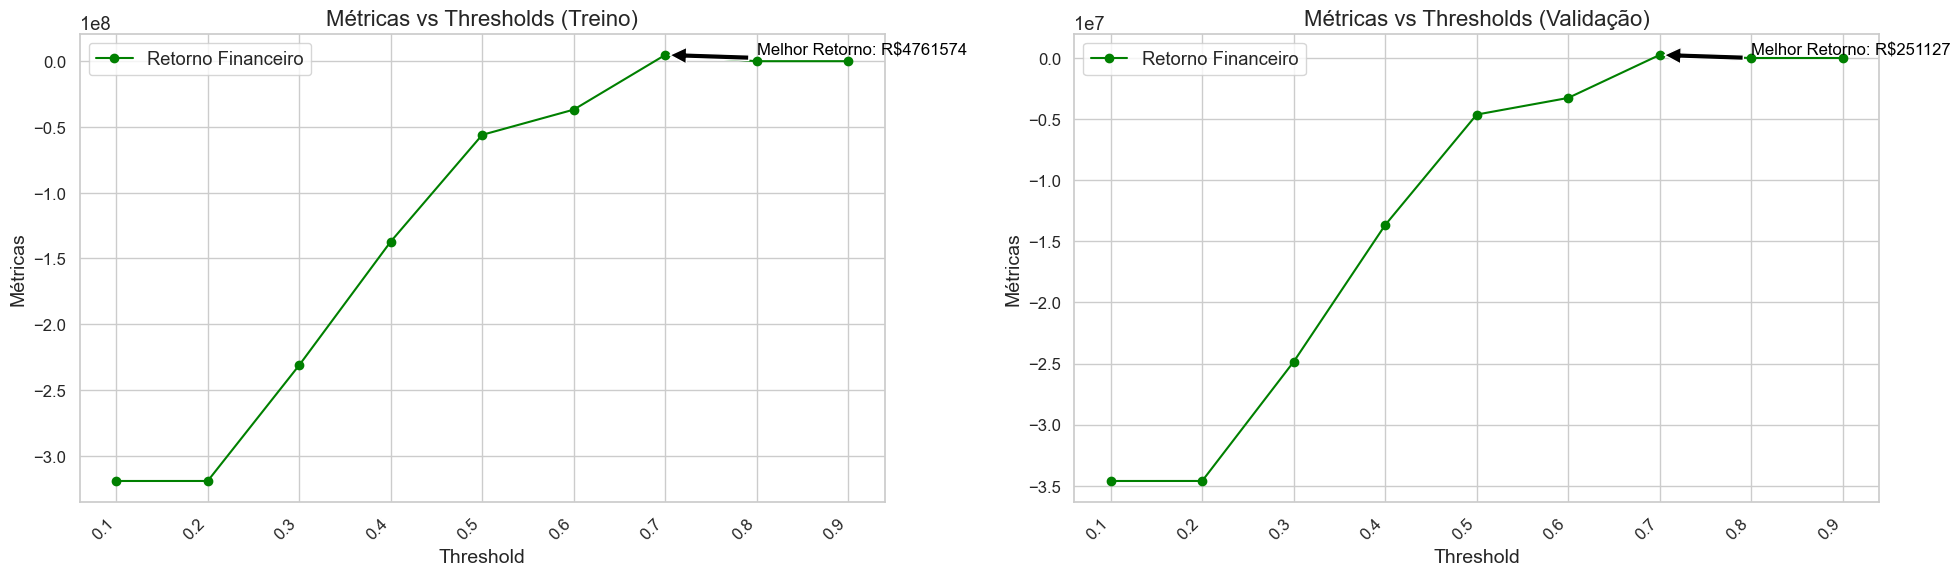

In [198]:
define_ponto_de_corte(x_train, y_train, x_valid, y_valid, best_hiperpams)

# <font color='green' style='font-size: 30px;'> 7.6) Resultados Esperados - Problema 1 (Baseando no Teste + OOT)</font>
<hr style='border: 2px solid green;'>

> 1. Com o Modelo, pode-se reter em torno de 12% a 20% dos clientes considerados como CHURN por mês, o que significa um retorno financeiro de R$ 1.8MM de reais no total

> 2. Dado que antes não possuíamos nenhuma solução proativa, o modelo pode ajudar bastante na tomada de decisão

> 3. Além disso, ações reativas podem gerar atrito com o cliente ou até mesmo ser um esforço a toa, portanto, sempre que possível sermos proativos, melhor

In [199]:
def modelo_classificador_churn_oficial(df_train, df_test, df_oot, opcao, best_hiperpams):

    base_train = df_train.copy()
    base_test = df_test.copy()
    base_oot = df_oot.copy()

    # Prepara as Amostras
    base_train['tipo_amostra'] = 'train'
    base_test['tipo_amostra'] = 'test'
    base_oot['tipo_amostra'] = 'oot'
    df = pd.concat([base_train, base_test, base_oot])

    # Prepara DataFrame para Treinamento ou Escoragem
    cols = list(df.drop(['churn', 'msno', 'safra', 'actual_amount_paid', 'tipo_amostra'], axis=1).columns)

    # Treina e Salva o Modelo
    if opcao == 'salvar':

        df_model = df.loc[(df['tipo_amostra'] == 'train')].copy()

        x_model = df_model[cols].copy()
        y_model = df_model['churn'].copy()

        # Define o modelo de XGBoost com a otimização de hiperparâmetros via BayesSearch + Calibração de Probabilidade
        # Melhores Hiperparâmetros
        melhores_hiperparametros = best_hiperpams
        colsample_bytree = round(melhores_hiperparametros['colsample_bytree'][1], 2)
        gamma = round(melhores_hiperparametros['gamma'][1], 2)
        learning_rate = round(melhores_hiperparametros['learning_rate'][1], 2)
        max_depth = int(round(melhores_hiperparametros['max_depth'][1], 2))
        n_estimators = int(round(melhores_hiperparametros['n_estimators'][1], 2))
        reg_alpha = round(melhores_hiperparametros['reg_alpha'][1], 2)
        reg_lambda = round(melhores_hiperparametros['reg_lambda'][1], 2)
        scale_pos_weight = int(round(melhores_hiperparametros['scale_pos_weight'][1], 2))
        subsample = round(melhores_hiperparametros['subsample'][1], 2)

        model = make_pipeline(
            XGBClassifier(
                random_state=42,            # Semente aleatória para reproducibilidade dos resultados
                tree_method = 'gpu_hist',
                n_estimators=n_estimators,           # Número de árvores no modelo (equivalente ao n_estimators na Random Forest)
                max_depth = max_depth,                # Profundidade máxima de cada árvore
                learning_rate = learning_rate,         # Taxa de aprendizado - controla a contribuição de cada árvore
                eval_metric='logloss',      # Métrica de avaliação durante o treinamento, 'logloss' é comum para problemas de classificação binária
                objective='binary:logistic',# Define o objetivo do modelo, 'binary:logistic' para classificação binária
                scale_pos_weight=scale_pos_weight,  # Peso das classes positivas em casos desequilibrados
                reg_alpha=reg_alpha,                # Termo de regularização L1 (penalidade nos pesos)
                reg_lambda=reg_lambda,               # Termo de regularização L2 (penalidade nos quadrados dos pesos)
                gamma=gamma,                    # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
                colsample_bytree=colsample_bytree,       # Fração de características a serem consideradas ao construir cada árvore
                subsample=subsample,              # Fração de amostras a serem usadas para treinar cada árvore
            )
        )

        # Treina o modelo de classificação
        model.fit(x_model, y_model)

        joblib.dump(model, "../00_DataMaster/models/classificador_churn.pkl")

        return print('Modelo de Churn Treinado e Salvo com Sucesso!')

    else:
        # Carrega o Classificador e Escora para as bases de Teste e OOT
        classificador_churn = joblib.load("../00_DataMaster/models/classificador_churn.pkl")
        df_scoring = df.loc[df['tipo_amostra'].isin(['test', 'oot'])].copy()
        df_scoring['churn_predict'] = classificador_churn.predict(df_scoring[cols])
        df_scoring['churn_predict_proba_0'] = classificador_churn.predict_proba(df_scoring[cols])[:, 0]
        df_scoring['churn_predict_proba_1'] = classificador_churn.predict_proba(df_scoring[cols])[:, 1]
        df_scoring['churn_predict_calib'] = np.where(df_scoring['churn_predict_proba_1'] <= 0.7, 0, 1)
        df_scoring = df_scoring[['tipo_amostra', 'msno', 'safra', 'actual_amount_paid', 'churn', 'churn_predict', 'churn_predict_calib', 'churn_predict_proba_0', 'churn_predict_proba_1']]

        return df_scoring


In [200]:
def metricas_estabilidade_final(classificador, df):

    def metricas_classificacao_modelos_juntos(lista_modelos):
        if len(lista_modelos) > 0:
            metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
        else:
            metricas_modelos = lista_modelos[0]
        # Redefina o índice para torná-lo exclusivo
        df = metricas_modelos.reset_index(drop=True)
        df = df.round(2)

        # Função para formatar as células com base na Etapa
        def color_etapa(val):
            color = 'black'
            if val == 'treino':
                color = 'blue'
            elif val == 'teste':
                color = 'red'
            return f'color: {color}; font-weight: bold;'

        # Função para formatar os valores com até duas casas decimais
        def format_values(val):
            if isinstance(val, (int, float)):
                return f'{val:.2f}'
            return val

        # Estilizando o DataFrame
        styled_df = df.style\
            .format(format_values)\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
            .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
            .set_table_styles([
                {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
            ])

        # Mostrando o DataFrame estilizado
        styled_df
        return styled_df

    def retorno_financeiro(df_modelo, y_predict):
        df_aux = df_modelo.loc[df_modelo['safra'].isin(['201603', '201604', '201605', '201606', '201607', '201608', '201609'])].copy()
        df_aux['y_predict'] = y_predict

        TN = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 0)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
        FN = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 0)].shape[0] # O CARA É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
        FP = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE É CHURN
        TP = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)].shape[0] # O CARA É CHURN E O MEU MODELO FALA QUE ELE É CHURN

        df_aux['retorno_financeiro'] = (
            np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 0), 0, # Não sofre nenhuma medida, então não temos retorno nem custo
            np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 0), 0, # Embora não tenhamos identificado que era CHURN, não oferecemos nenhum serviço e portanto não houve custo
            np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 1), 3*df_aux['actual_amount_paid'], # Implementamos a ação incorretamente, logo, estaremos fornecendo 3 meses de assinatura grátis e tendo custo
            np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 1), 9*df_aux['actual_amount_paid'], # Implementamos a ação corretamente, logo, estaremos retendo 50% desses casos e garantindo a assinatura deles por mais 3 meses
            0 # Não ganho nada
        )))))

        quantidade_de_clientes_retidos = 0.5*TP
        taxa_de_clientes_retidos = round((0.5*TP)/(FN+TP)*100, 2) # O RECALL FORNECE A QUANTIDADE DE CLIENTES RETIDOS, MAS PRECISAMOS DIVIDIR O VALOR POR 2 POR CONTA DO ENUNCIADO
        retorno_financeiro_acao_correta = (
            df_aux.loc[
                (df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)
            ]
            ['retorno_financeiro'].sum()
        )*0.5

        retorno_financeiro_acao_incorreta = (
            df_aux.loc[
                (df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)
            ]
            ['retorno_financeiro'].sum()
        )

        retorno_financeiro = round(retorno_financeiro_acao_correta - retorno_financeiro_acao_incorreta, 0)

        return quantidade_de_clientes_retidos, taxa_de_clientes_retidos, retorno_financeiro

    df_estabilidade = df.copy()

    # Teste
    df_estabilidade_teste = df_estabilidade.loc[df_estabilidade['safra'] != '201609'].copy()
    accuracy = accuracy_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    precision = precision_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    recall = recall_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    f1 = f1_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    roc_auc = roc_auc_score(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    fpr, tpr, thresholds = roc_curve(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    ks = max(tpr - fpr)
    logloss = log_loss(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy, 
            'Precisao': precision, 
            'Recall': recall, 
            'F1-Score': f1, 
            'AUC': roc_auc, 
            'KS': ks, 
            'LogLoss':logloss,
            'Etapa': 'Teste', 
            'Classificador': 'Modelo Final'
        }, 
        index=[0]
    )

    # OOT
    df_estabilidade_oot = df_estabilidade.loc[df_estabilidade['safra'] == '201609'].copy()
    accuracy = accuracy_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    precision = precision_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    recall = recall_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    f1 = f1_score(df_estabilidade['churn'], df_estabilidade['churn_predict_calib'])
    roc_auc = roc_auc_score(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    fpr, tpr, thresholds = roc_curve(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    ks = max(tpr - fpr)
    logloss = log_loss(df_estabilidade['churn'], df_estabilidade['churn_predict_proba_1'])
    metricas_oot = pd.DataFrame(
        {
            'Acuracia': accuracy, 
            'Precisao': precision, 
            'Recall': recall, 
            'F1-Score': f1, 
            'AUC': roc_auc, 
            'KS': ks, 
            'LogLoss':logloss,
            'Etapa': 'OOT', 
            'Classificador': 'Modelo Final'
        }, 
        index=[0]
    )

    metricas_teste_oot = metricas_classificacao_modelos_juntos([metricas_teste, metricas_oot])

    display(metricas_teste_oot)
    
    # Estabilidade
    safras = ['201603', '201604', '201605', '201606', '201607', '201608', '201609']
    metrics = {'safra': [], 'AUC': [], 'Clientes Churn Retidos': []}

    retorno_financeiro_total = 0  # Inicializa o total do retorno financeiro

    for safra in safras:
        df_safras = df.loc[df['safra'] == safra].copy()
        y_true = df_safras['churn']
        y_predict = df_safras['churn_predict_calib']
        y_predict_proba_1 = df_safras['churn_predict_proba_1'].values

        auc = roc_auc_score(y_true, y_predict_proba_1)
        fpr, tpr, _ = roc_curve(y_true, y_predict_proba_1)
        ks = max(tpr - fpr)
        precision = precision_score(y_true, y_predict)

        quantidade_de_clientes_retidos, taxa_clientes_retidos, retorno_financeiro_calculado = retorno_financeiro(df_safras, y_predict)

        metrics['safra'].append(safra)
        metrics['AUC'].append(auc)
        metrics['Clientes Churn Retidos'].append(taxa_clientes_retidos)

        retorno_financeiro_total += retorno_financeiro_calculado

    metrics_df = pd.DataFrame(metrics)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Gráfico das métricas
    ax1.plot(metrics_df['safra'], metrics_df['AUC'] * 100, marker='o', linestyle='-', color='blue', label='AUC')
    ax1.plot(metrics_df['safra'], metrics_df['Clientes Churn Retidos'], marker='o', linestyle='-', color='green', label='Clientes Churn Retidos (%)')

    for i in range(len(metrics_df)):
        ax1.annotate(f'{metrics_df["AUC"].iloc[i] * 100:.2f}', 
                     (metrics_df['safra'].iloc[i], metrics_df['AUC'].iloc[i] * 100), 
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9, color='blue')

        ax1.annotate(f'{metrics_df["Clientes Churn Retidos"].iloc[i]:.2f}%', 
                     (metrics_df['safra'].iloc[i], metrics_df['Clientes Churn Retidos'].iloc[i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9, color='green')

    ax1.set_title(f'AUC e Taxa de Clientes Churn Retidos por Safra ({classificador})')
    ax1.set_xlabel('Safra')
    ax1.set_ylabel('Valor')
    ax1.set_ylim(0, 100)
    ax1.legend(loc='lower right', fontsize='small')
    ax1.grid(True)
    ax1.set_xticks(metrics_df['safra'])
    ax1.set_xticklabels(metrics_df['safra'], rotation=45)

    # Gráfico do retorno financeiro total
    retorno_financeiro_total = round(retorno_financeiro_total, 0)
    ax2.text(0.5, 0.5, f'Retorno Financeiro (50% dos VP):\nR${retorno_financeiro_total:.0f}', 
             fontsize=20, ha='center', va='center', color='black', bbox=dict(facecolor='lightgray', alpha=0.5))
    ax2.set_title('Retorno Financeiro Total')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


Modelo de Churn Treinado e Salvo com Sucesso!


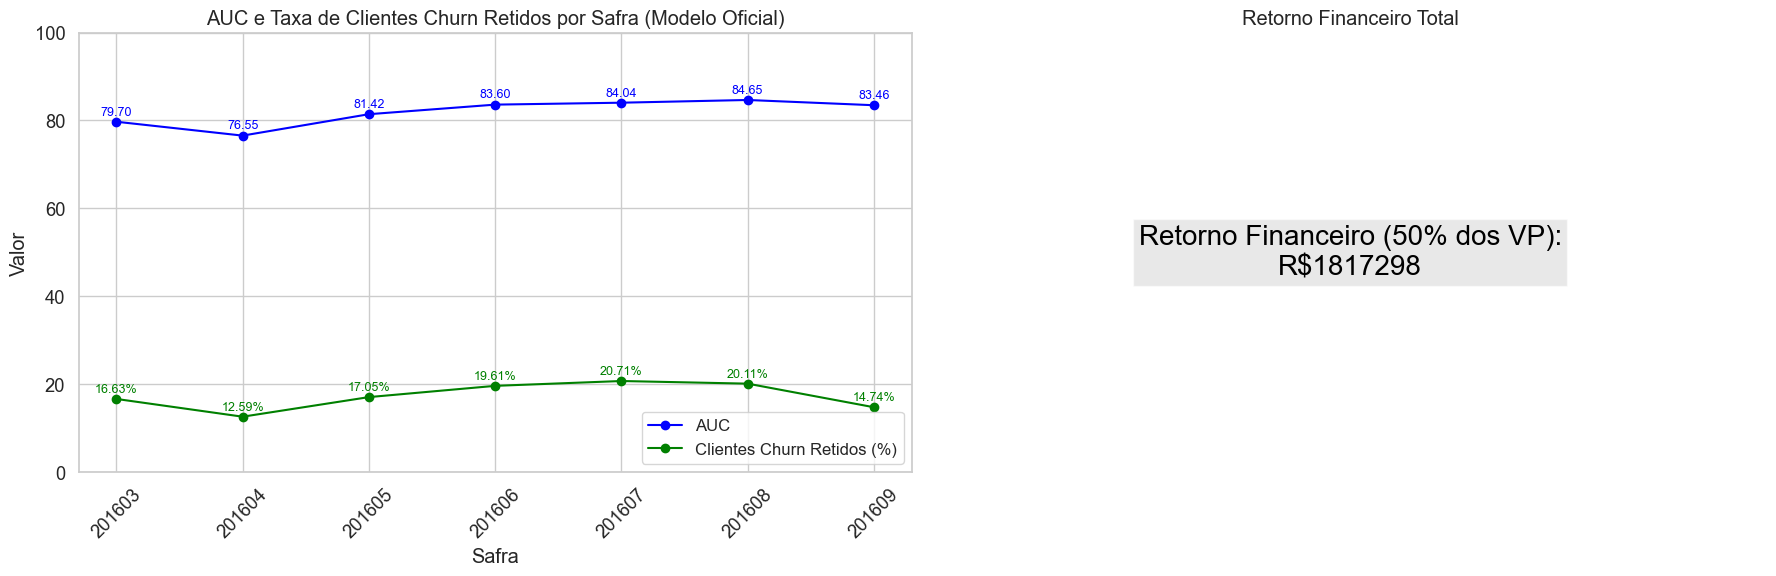

In [201]:
# Treinando o Modelo
modelo_classificador_churn_oficial(df_train, df_test, df_oot, 'salvar', best_hiperpams)

# Escorando o Modelo para a Base Final
df_analise_final = modelo_classificador_churn_oficial(df_train, df_test, df_oot, 'escoragem', best_hiperpams)

# Avaliação Final 
metricas_estabilidade_final(
    'Modelo Oficial', 
    df_analise_final
)

<font color='red' style='font-size: 40px;'> 8) Modelagem (Foco em Aprendizado Não-Supervisionado) </font>
<hr style='border: 2px solid red;'>

In [202]:
######################### FEATURE ENGINEERING #####################################################
def months_as_a_registered(df):

    df["registration_init_time"] = df["registration_init_time"].apply(lambda x:str(x)[:6])

    # Converter as colunas para objetos datetime
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m')
    df['safra'] = pd.to_datetime(df['safra'], format='%Y%m')

    # Calcular a diferença de meses
    df['months_as_a_registered'] = (df['safra'].dt.year - df['registration_init_time'].dt.year) * 12 + (df['safra'].dt.month - df['registration_init_time'].dt.month)
    df["safra"] = df["safra"].apply(lambda x:str(x)[:7].replace("-", ""))

    return df['months_as_a_registered']

def num_more_than_50(df):

    df["num_less_than_50"] = df["num_25"] + df["num_50"]
    df["num_more_than_50"] = df["num_75"] + df["num_985"] + df["num_100"]
    df["%num_more_than_50"] = round(df["num_more_than_50"]/(df["num_more_than_50"]+df["num_less_than_50"])*100, 2)

    return df["%num_more_than_50"]

def agrupa_categorias_cidade_pelo_woe(df):

    df['city'] = (
                np.where(df['city'].isin(['13', '14', '16', '7', '20']), 0, 
                np.where(df['city'].isin(['17', '4', '5', '18']), 1, 
                np.where(df['city'].isin(['19', '3', '15', '10']), 2, 
                np.where(df['city'].isin(['12', '11', '6', '22']), 3, 
                np.where(df['city'].isin(['8', '21', '9', '1']), 4, 
                np.nan)))))
    )

    return df['city']

def agrupa_categorias_metodo_pagamento_pelo_woe(df):

    df['payment_method_id'] = (
                np.where(df['payment_method_id'].isin(['32', '14', '10', '19', '31']), 0, 
                np.where(df['payment_method_id'].isin(['34', '41', '18', '37', '21']), 1, 
                np.where(df['payment_method_id'].isin(['23', '33', '39', '27']), 2, 
                np.where(df['payment_method_id'].isin(['40', '30', '16', '36', '26']), 3, 
                np.where(df['payment_method_id'].isin(['38', '29', '28', '35', '17']), 4, 
                np.nan)))))
    )

    return df['payment_method_id']

def get_temporal_features(df):

    tabela_de_transacoes_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_media_movel.parquet")
    tabela_user_logs_media_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_media_movel.parquet")

    tabela_de_transacoes_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_max_movel.parquet")
    tabela_user_logs_max_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_max_movel.parquet")

    tabela_de_transacoes_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_de_transacoes_min_movel.parquet")
    tabela_user_logs_min_movel = pd.read_parquet("../00_DataMaster/data/tabela_user_logs_min_movel.parquet")

    df = df.merge(tabela_de_transacoes_media_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_media_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_max_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_max_movel, on = ["msno", "safra"], how = "left")

    df = df.merge(tabela_de_transacoes_min_movel, on = ["msno", "safra"], how = "left")
    df = df.merge(tabela_user_logs_min_movel, on = ["msno", "safra"], how = "left")

    return df

######################### PRÉ-PROCESSAMENTO #####################################################

def muda_tipagem_variavel(df, feature, type):

    if type == "int":
        df[feature] = df[feature].apply(lambda x: int(x) if pd.notnull(x) else 999999)
    else:
        df[feature] = df[feature].apply(lambda x: float(x) if pd.notnull(x) else 999999)

    df.replace(999999, np.nan, inplace=True)

    return df[feature]

def pre_processamento_categoricas_nulas(df):
    variaveis_categoricas = ['is_auto_renew', 'gender', 'registered_via', 'city', 'payment_method_id']

    def aplica_tratamento_categorica_nulas(df, feature):
        df[feature] = np.where(df[feature].isnull(), 999, df[feature])
        return df[feature]

    for categorica in variaveis_categoricas:
        df[categorica] = aplica_tratamento_categorica_nulas(df, categorica)

    return df

def pre_processamento_continuas_nulas(df, calcula_mediana=False):
    variaveis_continuas = [
        'bd',
        'months_as_a_registered',
        'payment_plan_days', 
        'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6', 
        'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
        'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
        'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
        'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
        'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
        'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
        '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
    ]

    def calcular_e_salvar_mediana_por_cidade(df):
        variaveis_continuas = [
            'bd',
            'months_as_a_registered',
            'payment_plan_days', 
            'actual_amount_paid', 'actual_amount_paid_mov_avg_m6', 'actual_amount_paid_mov_max_m6', 'actual_amount_paid_mov_min_m6',
            'num_25', 'num_25_mov_avg_m6', 'num_25_mov_max_m6', 'num_25_mov_min_m6',
            'num_50', 'num_50_mov_avg_m6', 'num_50_mov_max_m6', 'num_50_mov_min_m6', 
            'num_75', 'num_75_mov_avg_m6', 'num_75_mov_max_m6', 'num_75_mov_min_m6', 
            'num_985', 'num_985_mov_avg_m6', 'num_985_mov_max_m6', 'num_985_mov_min_m6', 
            'num_100', 'num_100_mov_avg_m6', 'num_100_mov_max_m6', 'num_100_mov_min_m6',
            'num_unq', 'num_unq_mov_avg_m6','num_unq_mov_max_m6', 'num_unq_mov_min_m6',  
            '%num_more_than_50', '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_min_m6'
        ]
        
        cidades = df['city'].unique()
        for cidade in cidades:
            mediana_df = df[df['city'] == cidade][variaveis_continuas].median().reset_index()
            mediana_df.columns = ['variavel', 'mediana']
            mediana_df.to_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx", index=False)

    if calcula_mediana:
        calcular_e_salvar_mediana_por_cidade(df)
        print(f'Salvando a Mediana com dados de treinamento...')

    for cidade in df['city'].unique():
        mediana_dict = pd.read_excel(f"../00_DataMaster/pre_processing/mediana_city_{cidade}.xlsx").set_index('variavel')['mediana'].to_dict()
        for feature in variaveis_continuas:
            percentis = df[feature].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1 = percentis['1%']
            p99 = percentis['99%']
            df[feature] = np.where((df[feature].isnull() | (df[feature] <= p1) | (df[feature] >= p99)), mediana_dict[feature], df[feature])
            
        return df


def target_encoder_woe(df):

    woe_is_auto_renew = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_is_auto_renew.xlsx").set_index('is_auto_renew')['woe'].to_dict()
    woe_gender = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_gender.xlsx").set_index('gender')['woe'].to_dict()
    woe_registered_via = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_registered_via.xlsx").set_index('registered_via')['woe'].to_dict()
    woe_city = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_city.xlsx").set_index('city')['woe'].to_dict()
    woe_payment_method_id = pd.read_excel(f"../00_DataMaster/pre_processing/target_encoder_payment_method_id.xlsx").set_index('payment_method_id')['woe'].to_dict()

    df["is_auto_renew"] = df['is_auto_renew'].map(woe_is_auto_renew)
    df["gender"] = df['gender'].map(woe_gender)
    df["registered_via"] = df['registered_via'].map(woe_registered_via).fillna(0) # CONTINGÊNCIA POIS UMA DAS CATEGORIAS TINHA 20 REGISTROS E NÃO TINHA CHURN, ENTÃO O WOE SERÁ 0 COMO CONTINGÊNCIA
    df["city"] = df['city'].map(woe_city)
    df["payment_method_id"] = df['payment_method_id'].map(woe_payment_method_id)

    return df

def aplica_pre_processamento_feature_eng_feature_selection(df):

    # Aplicando Feature Engineering
    df['months_as_a_registered'] = months_as_a_registered(df)
    df['%num_more_than_50'] = num_more_than_50(df)
    df['city'] = agrupa_categorias_cidade_pelo_woe(df)
    df['payment_method_id'] = agrupa_categorias_metodo_pagamento_pelo_woe(df)
    df = get_temporal_features(df)

    # Aplicando Pré-Processamento
    df["is_auto_renew"] = muda_tipagem_variavel(df, "is_auto_renew", "int")
    df["bd"] = muda_tipagem_variavel(df, "bd", "int")
    df["registered_via"] = muda_tipagem_variavel(df, "registered_via", "int")
    df["payment_plan_days"] = muda_tipagem_variavel(df, "payment_plan_days", "float")
    df["actual_amount_paid"] = muda_tipagem_variavel(df, "actual_amount_paid", "float")

    df = pre_processamento_categoricas_nulas(df)
    df = pre_processamento_continuas_nulas(df)

    df = target_encoder_woe(df)

    # Organizando
    variaveis_selecionadas =  [
        'is_auto_renew', 'payment_method_id', 'months_as_a_registered',
        'num_unq_mov_max_m6', 'num_100_mov_max_m6', 'num_unq_mov_min_m6',
        'num_100_mov_min_m6', '%num_more_than_50_mov_max_m6',
        '%num_more_than_50_mov_avg_m6', '%num_more_than_50_mov_min_m6',
        'num_25_mov_max_m6', 'bd', 'num_50_mov_avg_m6',
        'num_985_mov_avg_m6', 'actual_amount_paid_mov_avg_m6',
        'num_25_mov_min_m6', 'num_75_mov_max_m6', 'num_50_mov_min_m6',
        'num_985_mov_min_m6', 'city', 'num_75_mov_min_m6',
        'registered_via', 'payment_plan_days',
        ]
    mensalidade = ['actual_amount_paid']
    safra = ["safra"]
    target = ["churn"]
    user_id = ["msno"]

    df = df[target + user_id + safra + mensalidade + variaveis_selecionadas]

    return df


def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]

    return x, y

######################### ANÁLISE #####################################################
def analisa_correlacao(metodo, df):
    plt.figure(figsize=(30, 15))
    mask = np.triu(np.ones_like(df.corr(method=metodo), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=metodo), vmin=-1, vmax=1, cmap='magma', annot=True, fmt='.2f', cbar_kws={"shrink": .8}, mask=mask)
    heatmap.set_title(f"Analisando Correlação de {metodo}")
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

def plota_dispersao(df, titulo,  x, y):
    plt.figure(figsize = (10, 5))
    sns.set(style = 'whitegrid')
    sns.scatterplot(data = df, x = x, y = y, color = '#1FB3E5', sizes = 1, alpha = 0.50, marker = '.')
    plt.title(f'{titulo}', fontsize = 14)
    plt.xlabel(f'{x}', fontsize = 14)
    plt.ylabel(f'{y}', fontsize = 14)
    plt.ticklabel_format(style = 'plain')
    plt.grid(True, linestyle=':')
    sns.despine()
    plt.tight_layout()
    plt.show()

def retorno_financeiro(df_modelo, y_predict):
    df_aux = df_modelo.loc[df_modelo['safra'].isin(['201603', '201604', '201605', '201606', '201607', '201608', '201609'])].copy()
    df_aux['y_predict'] = y_predict

    TN = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 0)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
    FN = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 0)].shape[0] # O CARA É CHURN E MEU MODELO FALA QUE ELE NÃO É CHURN
    FP = df_aux.loc[(df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)].shape[0] # O CARA NÃO É CHURN E MEU MODELO FALA QUE ELE É CHURN
    TP = df_aux.loc[(df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)].shape[0] # O CARA É CHURN E O MEU MODELO FALA QUE ELE É CHURN

    df_aux['retorno_financeiro'] = (
        np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 0), 0, # Não sofre nenhuma medida, então não temos retorno nem custo
        np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 0), 0, # Embora não tenhamos identificado que era CHURN, não oferecemos nenhum serviço e portanto não houve custo
        np.where((df_aux['churn'] == 0) & (df_aux['y_predict'] == 1), 3*df_aux['actual_amount_paid'], # Implementamos a ação incorretamente, logo, estaremos fornecendo 3 meses de assinatura grátis e tendo custo
        np.where((df_aux['churn'] == 1) & (df_aux['y_predict'] == 1), 12*df_aux['actual_amount_paid'], # Implementamos a ação corretamente, logo, estaremos retendo 50% desses casos e garantindo a assinatura deles por mais 3 meses
        0 # Não ganho nada
    )))))

    quantidade_de_clientes_retidos = 0.5*TP
    taxa_de_clientes_retidos = round((0.5*TP)/(FN+TP)*100, 2) # O RECALL FORNECE A QUANTIDADE DE CLIENTES RETIDOS, MAS PRECISAMOS DIVIDIR O VALOR POR 2 POR CONTA DO ENUNCIADO
    retorno_financeiro_acao_correta = (
        df_aux.loc[
            (df_aux['churn'] == 1) & (df_aux['y_predict'] == 1)
        ]
        ['retorno_financeiro'].sum()
    )*0.5

    retorno_financeiro_acao_incorreta = (
        df_aux.loc[
            (df_aux['churn'] == 0) & (df_aux['y_predict'] == 1)
        ]
        ['retorno_financeiro'].sum()
    )

    retorno_financeiro = round(retorno_financeiro_acao_correta - retorno_financeiro_acao_incorreta, 0)

######################### ESCORAGEM #####################################################
def escoragem(df):

    # Prepara DataFrame para Treinamento ou Escoragem
    cols = list(df.drop(['churn', 'msno', 'safra', 'actual_amount_paid'], axis=1).columns)

    # Carrega o Classificador e Escora para as bases de Teste e OOT
    classificador_churn = joblib.load("../00_DataMaster/models/classificador_churn.pkl")
    df_scoring = df.copy()
    df_scoring['churn_predict'] = classificador_churn.predict(df_scoring[cols])
    df_scoring['churn_predict_proba_0'] = classificador_churn.predict_proba(df_scoring[cols])[:, 0]
    df_scoring['churn_predict_proba_1'] = classificador_churn.predict_proba(df_scoring[cols])[:, 1]
    df_scoring['churn_predict_calib'] = np.where(df_scoring['churn_predict_proba_1'] <= 0.7, 0, 1)
    df_scoring = df_scoring[['msno', 'safra', 'churn', 'actual_amount_paid', 'churn_predict_calib', 'churn_predict_proba_0', 'churn_predict_proba_1'] + cols]

    return df_scoring

# <font color='green' style='font-size: 30px;'> 8.1) Puxando Dados</font>
<hr style='border: 2px solid green;'>

In [203]:
### Puxando informações de Treino + Validação + Teste + OOT

df_train = pd.read_parquet("../00_DataMaster/data/df_train.parquet")
df_valid = pd.read_parquet("../00_DataMaster/data/df_valid.parquet")
df_test = pd.read_parquet("../00_DataMaster/data/df_test.parquet")
df_oot = pd.read_parquet("../00_DataMaster/data/df_oot.parquet")

### Aplicando Transformações necessárias

df_train = aplica_pre_processamento_feature_eng_feature_selection(df_train)
df_valid = aplica_pre_processamento_feature_eng_feature_selection(df_valid)
df_test = aplica_pre_processamento_feature_eng_feature_selection(df_test)
df_oot = aplica_pre_processamento_feature_eng_feature_selection(df_oot)

## Escorando Bases de Treino e Teste
df_train = pd.concat([df_train, df_valid]).sort_values(by = ['msno', 'safra'], ascending = True)
df_test = pd.concat([df_test, df_oot]).sort_values(by = ['msno', 'safra'], ascending = True)

df_train_scored = escoragem(df_train)
df_test_scored = escoragem(df_test)


# <font color='green' style='font-size: 30px;'> 8.2) Compreensão das características dos clientes </font>
<hr style='border: 2px solid green;'>

### Desafio --> Análise de clientes com diferentes perfis de uso da plataforma + estimativa de rentabilidade e churn para cada cluster

> 1. Para compreender as características dos clientes, podemos segmentá-las em:

- Perfil de uso: Como o cliente consome o serviço?
- Perfil do tempo: Há quanto tempo o cliente está registrado?
- Perfil do cadastro: Qual a idade do cliente?
- Perfil de pagamento: Qual a mensalidade do cliente?

> 2. Para definir as variáveis e o melhor número de Clusters:

- O PCA foi aplicado para reduzir a dimensionalidade. Clusters com alta dimensionalidade ficam muito complexos e computacionalmente caro, portanto, aplicar PCA é interessante
- Essa técnica é capaz de reduzir a dimensionalidade mantendo grande parte da variância das variáveis originais ou, em outras palavras, reduz o número de variáveis mantendo grande parte de sua explicabilidade
- Optou-se por manter 8 componentes pois elas possuíam 90% da variância, número o qual julguei ser o suficiente
- Em relação ao KMeans, escolheu-se esse algoritmo por conta do seu baixo custo computacional e fácil compreensão, dado que o desafio é de explicabilidade e o KMeans é fácil de ser entendido
- O número de Clusters ideal foi 3, pois foi o número que maximiza o Silhouette Score (uma métrica que avalia o quão bem agrupados estão os dados de um cluster e o quão distante estão os clusters entre si) e redução da distância intra-cluster (avalia o quão compacto estão os dados dentro de um mesmo cluster)

In [204]:
def analise_cluster(df):

    features = [
       'num_unq_mov_max_m6',
       'num_100_mov_max_m6', 'num_unq_mov_min_m6', 'num_100_mov_min_m6',
       '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_avg_m6',
       '%num_more_than_50_mov_min_m6', 'num_25_mov_max_m6', 'num_50_mov_avg_m6', 'num_985_mov_avg_m6', 'num_25_mov_min_m6',
       'num_75_mov_max_m6', 'num_50_mov_min_m6', 'num_985_mov_min_m6', 'num_75_mov_min_m6', 'months_as_a_registered', 'payment_method_id', 'bd', 'city'
    ]

    # Padronização dos dados com MinMaxScaler
    scaler = MinMaxScaler()
    padronizado = scaler.fit_transform(df[features])
    
    # Aplicando o PCA
    pca = PCA()
    pca.fit(padronizado)
    
    # Variância explicada acumulada
    variancia_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)
    
    # Aplicando o PCA e selecionando as primeiras componentes principais
    principais_componentes = pca.transform(padronizado)
    
    # Listas para armazenar os scores do Silhouette e WCSS
    silhouette_scores = []
    wcss = []
    
    for n_clusters in np.arange(2, 11):  # Começa em 2 porque não faz sentido calcular para 1 cluster
        kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=42, max_iter=100)
        kmeans.fit(principais_componentes)
    
        score = silhouette_score(principais_componentes, kmeans.labels_)
        silhouette_scores.append(score)
        wcss.append(kmeans.inertia_)
    
    # Plotagem dos gráficos
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # Gráfico de variância acumulada
    ax[0].plot(np.arange(1, len(variancia_explicada_acumulada) + 1), variancia_explicada_acumulada, marker='o', color='orange', label='Variância Explicada Acumulada')
    for i, valor in enumerate(variancia_explicada_acumulada):
        ax[0].text(i + 1, valor - 0.02, f'{valor:.2f}', ha='center', va='bottom', color='orange')
    ax[0].set_title('PCA - Variância Explicada Acumulada')
    ax[0].set_xlabel('Número de Componentes Principais')
    ax[0].set_ylabel('Proporção da Variância Explicada Acumulada')
    ax[0].legend(loc='center right', bbox_to_anchor=(0.9, 0.5), frameon=False)
    ax[0].grid(True)

    # Gráfico do Silhouette Score e WCSS
    ax[1].plot(np.arange(2, 11), silhouette_scores, marker='o', color='blue', label='Silhouette Score')
    ax[1].set_title('Definição do Melhor Número de Clusters')
    ax[1].set_xlabel('Número de Clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid(True)

    ax2 = ax[1].twinx()
    ax2.plot(np.arange(2, 11), wcss, marker='x', color='red', linestyle='--', label='WCSS')
    ax2.set_ylabel('WCSS')

    ax2.spines['right'].set_color('none')
    ax2.yaxis.set_ticks([])

    ax[1].legend(loc='center right', bbox_to_anchor=(0.9, 0.8), frameon=False)
    ax2.legend(loc='center right', bbox_to_anchor=(0.9, 0.7), frameon=False)

    plt.tight_layout()
    plt.show()

def train_min_max_scaler_cluster(df, tipo):

    features = [
       'num_unq_mov_max_m6',
       'num_100_mov_max_m6', 'num_unq_mov_min_m6', 'num_100_mov_min_m6',
       '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_avg_m6',
       '%num_more_than_50_mov_min_m6', 'num_25_mov_max_m6', 'num_50_mov_avg_m6', 'num_985_mov_avg_m6', 'num_25_mov_min_m6',
       'num_75_mov_max_m6', 'num_50_mov_min_m6', 'num_985_mov_min_m6', 'num_75_mov_min_m6', 'months_as_a_registered', 'payment_method_id', 'bd', 'city'
    ]

    df_scaler = df[features].copy()
    scaler = MinMaxScaler()
    scaler.fit(df_scaler)

    joblib.dump(scaler, f"../00_DataMaster/models/scaler_cluster_{tipo}.pkl")

    print('Scaler Treinado e Salvo com sucesso!')

def train_PCA(df, tipo):

    features = [
       'num_unq_mov_max_m6',
       'num_100_mov_max_m6', 'num_unq_mov_min_m6', 'num_100_mov_min_m6',
       '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_avg_m6',
       '%num_more_than_50_mov_min_m6', 'num_25_mov_max_m6', 'num_50_mov_avg_m6', 'num_985_mov_avg_m6', 'num_25_mov_min_m6',
       'num_75_mov_max_m6', 'num_50_mov_min_m6', 'num_985_mov_min_m6', 'num_75_mov_min_m6', 'months_as_a_registered', 'payment_method_id', 'bd', 'city'
    ]

    # Padronização dos dados
    scaler = joblib.load(f"../00_DataMaster/models/scaler_cluster_{tipo}.pkl")
    padronizado = scaler.transform(df[features])
    
    # Aplicando o PCA
    pca = PCA()
    pca.fit(padronizado)
    
    # Salvando o PCA
    joblib.dump(pca, f"../00_DataMaster/models/pca_cluster_{tipo}.pkl")
    print('PCA Treinado e Salvo com sucesso!')

def Clusterizador(df, tipo):
    scaler = joblib.load(f"../00_DataMaster/models/scaler_cluster_{tipo}.pkl")
    pca = joblib.load(f"../00_DataMaster/models/pca_cluster_{tipo}.pkl")

    features = [
       'num_unq_mov_max_m6',
       'num_100_mov_max_m6', 'num_unq_mov_min_m6', 'num_100_mov_min_m6',
       '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_avg_m6',
       '%num_more_than_50_mov_min_m6', 'num_25_mov_max_m6', 'num_50_mov_avg_m6', 'num_985_mov_avg_m6', 'num_25_mov_min_m6',
       'num_75_mov_max_m6', 'num_50_mov_min_m6', 'num_985_mov_min_m6', 'num_75_mov_min_m6', 'months_as_a_registered', 'payment_method_id', 'bd', 'city'
    ]

    # Aplicando o Min Max Scaler, PCA e selecionando as primeiras componentes principais
    padronizado = scaler.transform(df[features])
    principais_componentes = pca.transform(padronizado)[:, :8]
    kmeans = KMeans(n_clusters=3, init='random', random_state=42, max_iter=100)
    kmeans.fit(principais_componentes)

    joblib.dump(kmeans, f"../00_DataMaster/models/kmeans_cluster_{tipo}.pkl")

    print('KMeans Treinado e Salvo com sucesso!')


def modelo_clusterizador_churn_oficial(df, tipo):

    scaler = joblib.load(f"../00_DataMaster/models/scaler_cluster_{tipo}.pkl")
    pca = joblib.load(f"../00_DataMaster/models/pca_cluster_{tipo}.pkl")
    kmeans = joblib.load(f"../00_DataMaster/models/kmeans_cluster_{tipo}.pkl")

    features = [
       'num_unq_mov_max_m6',
       'num_100_mov_max_m6', 'num_unq_mov_min_m6', 'num_100_mov_min_m6',
       '%num_more_than_50_mov_max_m6', '%num_more_than_50_mov_avg_m6',
       '%num_more_than_50_mov_min_m6', 'num_25_mov_max_m6', 'num_50_mov_avg_m6', 'num_985_mov_avg_m6', 'num_25_mov_min_m6',
       'num_75_mov_max_m6', 'num_50_mov_min_m6', 'num_985_mov_min_m6', 'num_75_mov_min_m6', 'months_as_a_registered', 'payment_method_id', 'bd', 'city'
    ]

    df_cluster = df[features].copy()
    df_features = scaler.transform(df[features])
    df_features = pca.transform(df_features)[:, :8]
    clusters = kmeans.predict(df_features)

    return clusters

def transform_to_percentiles(df, n, variavel_continua):
    # Calcula os limites dos percentiles
    percentile_limits = [i / n for i in range(n+1)] 
    
    # Aplica a função qcut para transformar a variável em percentiles
    percentiles = pd.qcut(df[variavel_continua], q=n, labels=False, duplicates='drop')
    
    return percentiles



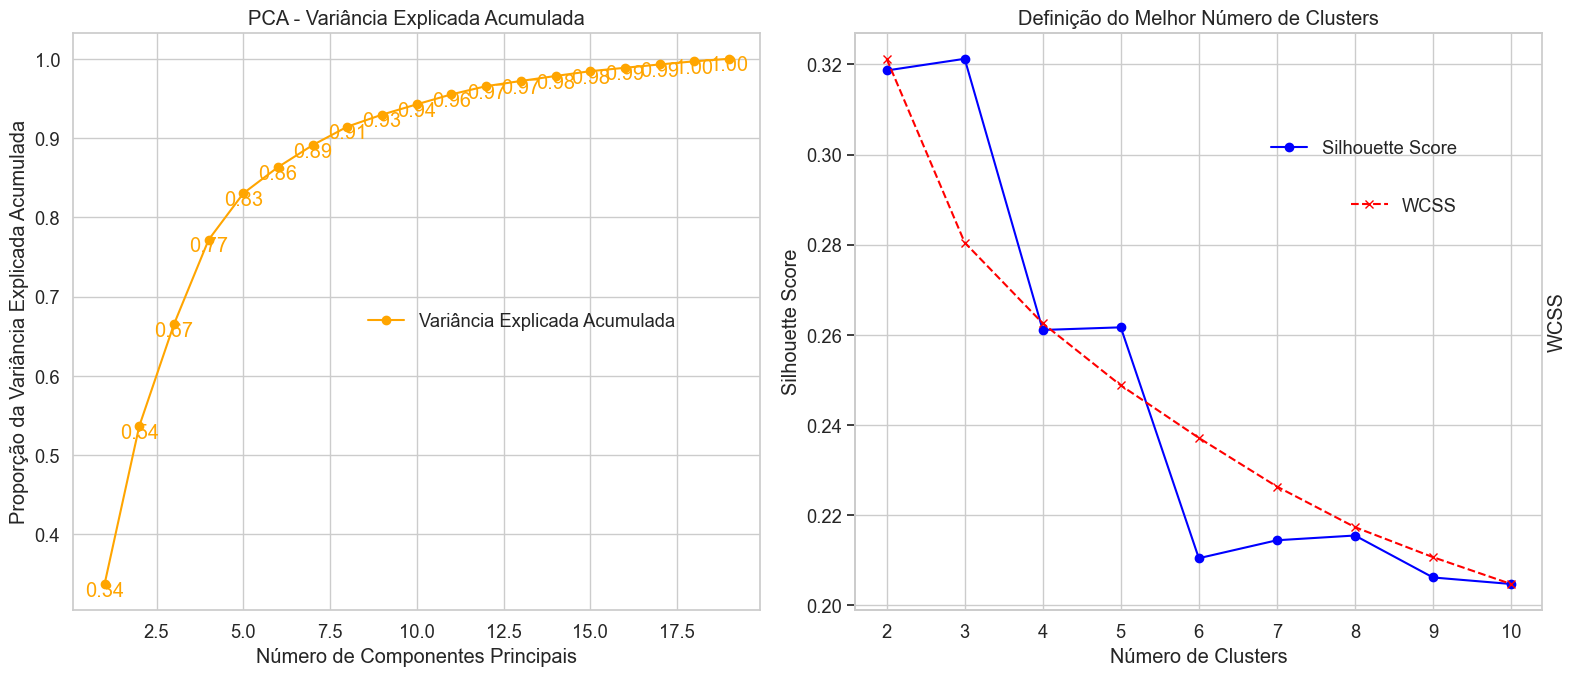

In [205]:
############ AVALIANDO NÚMERO DE COMPONENTES DO PCA + NÚMERO DE CLUSTERS IDEAL
analise_cluster(df_train_scored.sample(frac = 0.05))

In [206]:
# Min-Max Scaler
train_min_max_scaler_cluster(df_train_scored, 'perfil_cliente')
# PCA
train_PCA(df_train_scored, 'perfil_cliente')
# KMeans
Clusterizador(df_train_scored, 'perfil_cliente')

Scaler Treinado e Salvo com sucesso!
PCA Treinado e Salvo com sucesso!
KMeans Treinado e Salvo com sucesso!


In [207]:
# Definição dos Clusters
df_test_scored['cluster'] = modelo_clusterizador_churn_oficial(df_test_scored, 'perfil_cliente')

# Cálculo do Retorno Financeiro
df_test_scored['retorno_financeiro'] =( 
    np.where((df_test_scored['churn'] == 0) & (df_test_scored['churn_predict_calib'] == 0), 0, 
    np.where((df_test_scored['churn'] == 1) & (df_test_scored['churn_predict_calib'] == 0), 0,
    np.where((df_test_scored['churn'] == 0) & (df_test_scored['churn_predict_calib'] == 1), -3 * df_test_scored['actual_amount_paid'],
    np.where((df_test_scored['churn'] == 1) & (df_test_scored['churn_predict_calib'] == 1), 9 * df_test_scored['actual_amount_paid'],0))))
)

# Criação dos Ranking de Churn
df_test_scored['ranking_churn'] = transform_to_percentiles(df_test_scored, 3, 'churn_predict_proba_1')
df_test_scored['ranking_churn'] = (
    np.where(df_test_scored['ranking_churn'] == 0, '1. BAIXO',
    np.where(df_test_scored['ranking_churn'] == 1, '2. MÉDIO',
    np.where(df_test_scored['ranking_churn'] == 2, '3. ALTO', 'OUTROS')))
)

# Criação do Ranking de Retorno Financeiro
df_test_scored['ranking_retorno_financeiro'] = transform_to_percentiles(df_test_scored, 2, 'retorno_financeiro')
df_test_scored['ranking_retorno_financeiro'] = (
    np.where(df_test_scored['ranking_retorno_financeiro'] == 0, '1. PREJUIZO',
    np.where(df_test_scored['ranking_retorno_financeiro'] == 1, '2. LUCRO','OUTROS'))
)

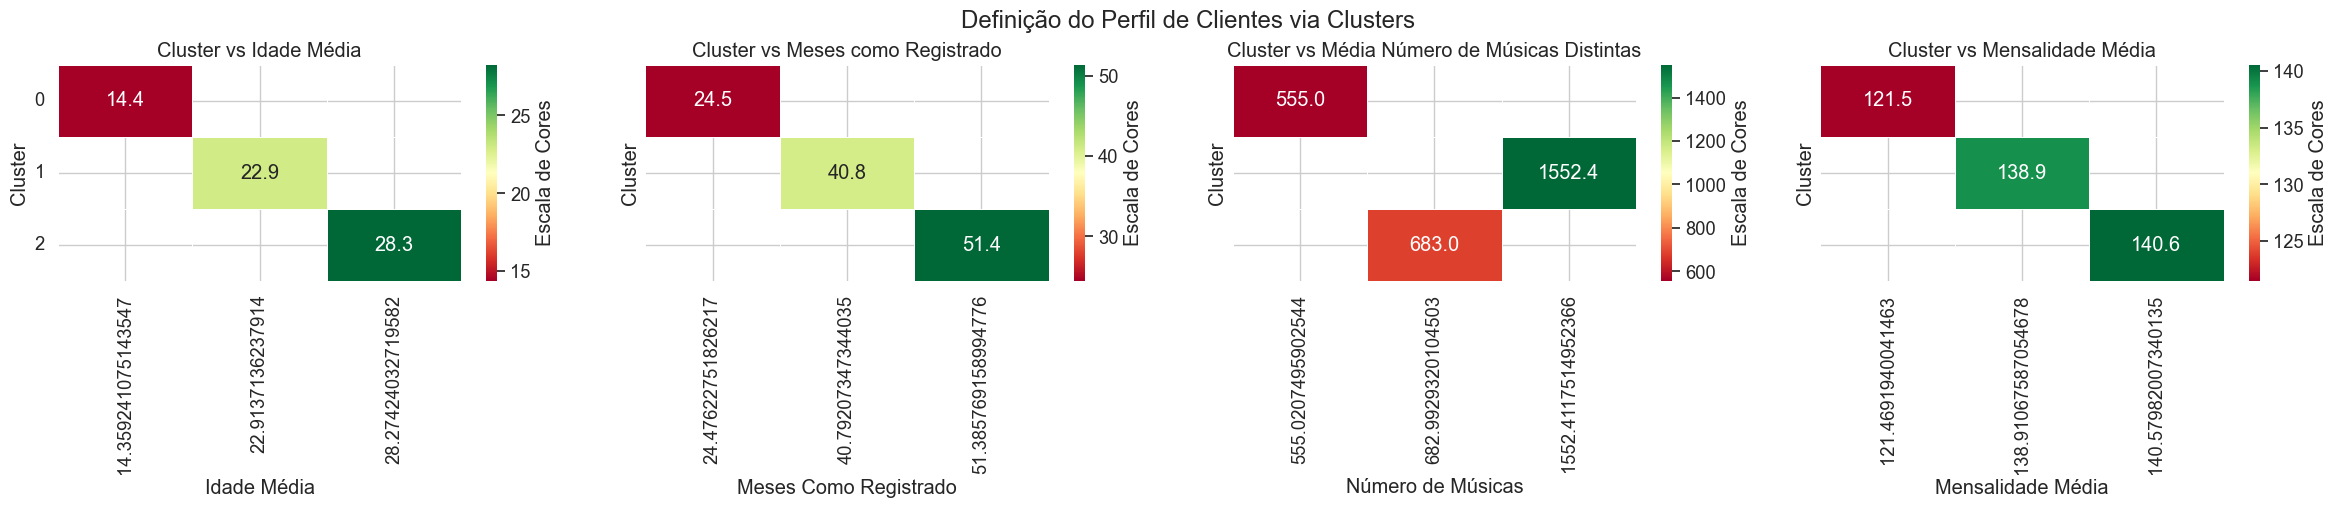

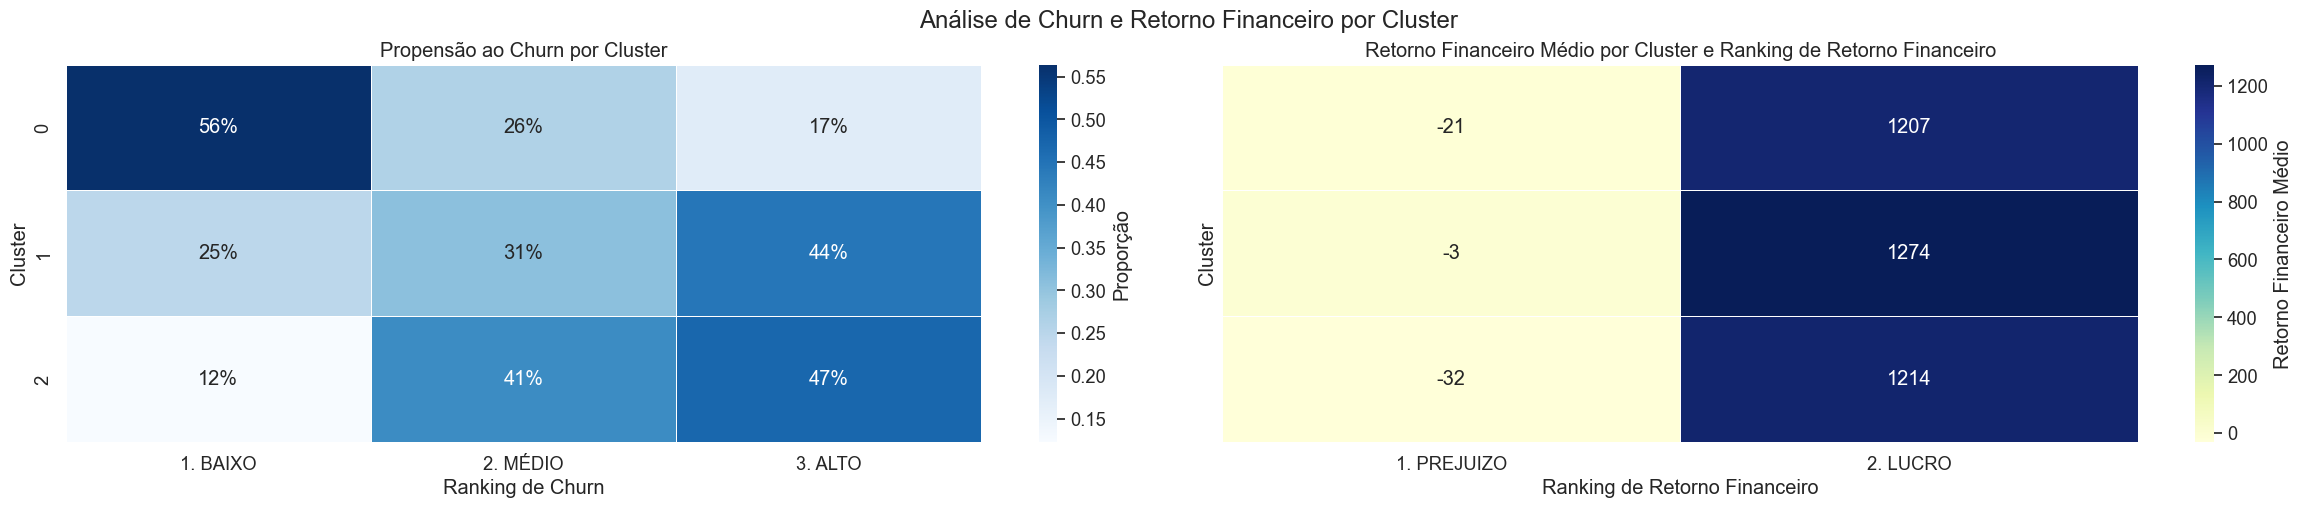

In [210]:
########################################## ANÁLISE DE PERFIL

entendendo_clusters = (
    df_test_scored
    .groupby('cluster', as_index = False)
    .agg(
        {
            'msno':'count', 
            'bd':'mean', 
            'months_as_a_registered':'mean', 
            'num_unq_mov_max_m6':'mean', 
            'actual_amount_paid':'mean',
        }
    )
    .rename(
        {
            'msno':'qt_clientes', 
            'bd':'idade_media', 
            'months_as_a_registered':'meses_como_registrado', 
            'num_unq_mov_max_m6':'media_numero_de_musicas_unicas_escutadas', 
            'actual_amount_paid':'mensalidade_media',
        },
        axis = 1
    )
)

fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# Cluster vs Idade Média
pivot_idade = entendendo_clusters[['cluster', 'idade_media', 'meses_como_registrado', 'media_numero_de_musicas_unicas_escutadas', 'mensalidade_media']].pivot(index='cluster', columns='idade_media', values='idade_media')
sns.heatmap(
    pivot_idade,
    annot=pivot_idade,
    fmt=".1f",
    cmap='RdYlGn',
    linewidths=.5,
    cbar_kws={'label': 'Escala de Cores'},
    ax=axes[0]
)
axes[0].set_title('Cluster vs Idade Média')
axes[0].set_xlabel('Idade Média')
axes[0].set_ylabel('Cluster')
axes[0].set_yticklabels(pivot_idade.index, rotation=0)
axes[0].yaxis.set_ticks_position('none')  # Ocultar ticks do eixo Y

# Cluster vs Meses
pivot_meses = entendendo_clusters[['cluster', 'idade_media', 'meses_como_registrado', 'media_numero_de_musicas_unicas_escutadas', 'mensalidade_media']].pivot(index='cluster', columns='meses_como_registrado', values='meses_como_registrado')
sns.heatmap(
    pivot_meses,
    annot=pivot_meses,
    fmt=".1f",
    cmap='RdYlGn',
    linewidths=.5,
    cbar_kws={'label': 'Escala de Cores'},
    ax=axes[1]
)
axes[1].set_title('Cluster vs Meses como Registrado')
axes[1].set_xlabel('Meses Como Registrado')
axes[1].set_ylabel('Cluster')
axes[1].set_yticklabels(pivot_meses.index, rotation=0)
axes[1].yaxis.set_ticks_position('none')  # Ocultar ticks do eixo Y

# Cluster vs Número de Músicas
pivot_musicas = entendendo_clusters[['cluster', 'idade_media', 'meses_como_registrado', 'media_numero_de_musicas_unicas_escutadas', 'mensalidade_media']].pivot(index='cluster', columns='media_numero_de_musicas_unicas_escutadas', values='media_numero_de_musicas_unicas_escutadas')
sns.heatmap(
    pivot_musicas,
    annot=pivot_musicas,
    fmt=".1f",
    cmap='RdYlGn',
    linewidths=.5,
    cbar_kws={'label': 'Escala de Cores'},
    ax=axes[2]
)
axes[2].set_title('Cluster vs Média Número de Músicas Distintas')
axes[2].set_xlabel('Número de Músicas')
axes[2].set_ylabel('Cluster')
axes[2].set_yticklabels(pivot_musicas.index, rotation=0)
axes[2].yaxis.set_ticks_position('none')  # Ocultar ticks do eixo Y

# Cluster vs Mensalidade Média
pivot_mensalidade = entendendo_clusters[['cluster', 'idade_media', 'meses_como_registrado', 'media_numero_de_musicas_unicas_escutadas', 'mensalidade_media']].pivot(index='cluster', columns='mensalidade_media', values='mensalidade_media')
sns.heatmap(
    pivot_mensalidade,
    annot=pivot_mensalidade,
    fmt=".1f",
    cmap='RdYlGn',
    linewidths=.5,
    cbar_kws={'label': 'Escala de Cores'},
    ax=axes[3]
)
axes[3].set_title('Cluster vs Mensalidade Média')
axes[3].set_xlabel('Mensalidade Média')
axes[3].set_ylabel('Cluster')
axes[3].set_yticklabels(pivot_mensalidade.index, rotation=0)
axes[3].yaxis.set_ticks_position('none')  # Ocultar ticks do eixo Y

plt.tight_layout()
plt.suptitle('Definição do Perfil de Clientes via Clusters', y=1.02)
plt.show()

########################################## ANÁLISE DE CHURN E RENTABILIDADE

# Criar a Tabela Dinâmica para a quantidade de pessoas por Cluster e Ranking de Churnk
pivot_table_count = df_test_scored.pivot_table(
    index='cluster',
    columns='ranking_churn',
    values='msno',
    aggfunc='count',
    fill_value=0
)

pivot_table_proportion_by_row = pivot_table_count.div(pivot_table_count.sum(axis=1), axis=0)

# Criar a Tabela Dinâmica para o retorno financeiro médio por Cluster e Ranking de Retorno Financeiro
pivot_table_ret_fin_mean = df_test_scored.pivot_table(
    index='cluster',
    columns='ranking_retorno_financeiro',
    values='retorno_financeiro',
    aggfunc='mean',
    fill_value=0
)

# Plota o gráfico
fig, axes = plt.subplots(1, 2, figsize=(24, 5), sharey=True)
sns.heatmap(
    pivot_table_proportion_by_row,
    annot=True,
    fmt='.0%',
    cmap='Blues',
    linewidths=.5,
    ax=axes[0],
    cbar_kws={'label': 'Proporção'}
)
axes[0].set_title('Propensão ao Churn por Cluster')
axes[0].set_xlabel('Ranking de Churn')
axes[0].set_ylabel('Cluster')

sns.heatmap(
    pivot_table_ret_fin_mean,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    linewidths=.5,
    ax=axes[1],
    cbar_kws={'label': 'Retorno Financeiro Médio'}
)
axes[1].set_title('Retorno Financeiro Médio por Cluster e Ranking de Retorno Financeiro')
axes[1].set_xlabel('Ranking de Retorno Financeiro')
axes[1].set_ylabel('Cluster')

plt.tight_layout()
plt.suptitle('Análise de Churn e Retorno Financeiro por Cluster', y=1.02)
plt.show()



### Cluster 0 --> O DE MAIOR RENTABILIDADE MÉDIA e MENOR PROPENSÃO AO CHURN

- Adolescentes,
- Relativamente recentes na plataforma,
- Ainda não ouviram tantas músicas ,
- Provavelmente optam pelo plano mais baixo (mensalidade menor)

### Cluster 1 ---> O DE MÉDIA RENTABILIDADE MÉDIA E MÉDIA PROPENSÃO AO CHURN

- Jovens Universitários ou que começaram a carreira agora,
- Estão relativamente há um bom tempo na plataforma,
- Consomem muito dela,
- inclusive aceitando um plano intermediário (mensalidade média)

### Cluster 2 --> O DE MENOR RENTABILIDADE MÉDIA E ALTA PROPENSÃO A CHURN

- Jovens mais avançados na carreira e pessoas mais velhas provavelmente,
- Estão há bastante tempo na plataforma,
- Aparentemente não a utilizam tanto dado o número de músicas,
- Como estão em um patamar maior na carreira optam pelo plano mais caro (as vezes pagam esse valor pois pode ser um plano família ou algo do tipo)
